# TMDb Movie Box Office Prediction Model

## Introduction

This project was completed in full by Nick Mitchell and Cole Leppert. This is the first full scale machine learning project that either of them had ever worked on and proved to be an incredibly useful learning experience. We learned a lot as we went and truly gave it our best efforts, however, mistakes are a natural part of the learning process and we likely made some. All feedback and constructive criticism is not only welcomed, but encouraged.

## Background

The film industry is quite popular in today's society and only growing more popular each year. So many major blockbuster hits release every year, making hundreds of millions of dollars (sometimes even over 1 billion), that are exceedingly successful. But for all of the successful movies, there are plenty more that absolutely flop in the box office and are dissappointing by every metric. The goal of this project is to analyze what makes particular movies successful, and others not so much, by a measure of worldwide box office revenue. Futhermore, after analyzing the data on these movies, we aim to sccuessfully predict the revenue for movies as well, as it proves to be extremely useful in industry to know what the significant factors of success may be. This challenge was presented on Kaggle roughly a year ago, so we are a bit late to the party, however we decided it was a fun challenge to do and came up with the idea independently before finding the dataset and challenge. Since it was already avaiable to us and seemed like a great initial project for us to take on, we decided to dive into it. The data comes from TMDb (The Movie Database). This notebook is the result, including full exploratory data analysis, feature engineering and selection, and modeling. Thank you for taking the time to look at our work and we hope you enjoy!

## References

Here is a link to the original challenge on Kaggle as well as some useful notebooks that provided guidance and inspiration for our work at times. Since this was our first project, it proved to be incredibly useful to be able to see the unique ways others approached aspects of the challenge, so we owe some credit to the following notebooks as well.

Original Kaggle Challenge: 

https://www.kaggle.com/c/tmdb-box-office-prediction


Andrew Lukyanenko's impressive submission, one of the highest rated notebooks in the competition:    

https://www.kaggle.com/artgor/eda-feature-engineering-and-model-interpretation


Praxitelisk's GitHub Repo that we referenced as well:

https://github.com/praxitelisk/TMDB-Box-Office-Prediction

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, accuracy_score
import shap
plt.style.use('ggplot')
pd.options.mode.chained_assignment = None  # default='warn'

## Loading the data

In [2]:
#Load in the data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

First we load in the data, and again this is a dataset provided by a Kaggle challenge, meaning that it was provided to us already split into a train and test set. This is unconventional but we kept the datasets as is and used just the train set in our modeling, further splitting it up, and then the test set is only meant to be used for submission.

## Initial Inspection of the Data

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [4]:
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print ('---------------------------------------------')
print ('The test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

The train data has 3000 rows and 23 columns
---------------------------------------------
The test data has 4398 rows and 22 columns


The test set is one column shorter since it is missing the 'revenue' column, because this is our target value. The test set also has a lot more rows, which is unfortunate since we are not actually competing in the Kaggle competition, so the test set is not very useful to us. But we will clean it regardless.

In [5]:
train.head(10)

id                              belongs_to_collection    budget  \
0   1  [{'id': 313576, 'name': 'Hot Tub Time Machine ...  14000000   
1   2  [{'id': 107674, 'name': 'The Princess Diaries ...  40000000   
2   3                                                NaN   3300000   
3   4                                                NaN   1200000   
4   5                                                NaN         0   
5   6                                                NaN   8000000   
6   7                                                NaN  14000000   
7   8                                                NaN         0   
8   9  [{'id': 256377, 'name': 'The Muppet Collection...         0   
9  10                                                NaN   6000000   

                                              genres  \
0                     [{'id': 35, 'name': 'Comedy'}]   
1  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
2                      [{'id': 18, 'name': 'Drama'}]   
3  [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...   
4  [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...   
5  [{'id': 16, 'name': 'Animation'}, {'id': 12, '...   
6  [{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...   
7                [{'id': 99, 'name': 'Documentary'}]   
8  [{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...   
9  [{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...   

                             homepage    imdb_id original_language  \
0                                 NaN  tt2637294                en   
1                                 NaN  tt0368933                en   
2   http://sonyclassics.com/whiplash/  tt2582802                en   
3          http://kahaanithefilm.com/  tt1821480                hi   
4                                 NaN  tt1380152                ko   
5                                 NaN  tt0093743                en   
6  http://www.thepossessionmovie.com/  tt0431021                en   
7                                 NaN  tt0391024                en   
8                                 NaN  tt0117110                en   
9                                 NaN  tt0310281                en   

                             original_title  \
0                    Hot Tub Time Machine 2   
1  The Princess Diaries 2: Royal Engagement   
2                                  Whiplash   
3                                   Kahaani   
4                                      마린보이   
5    Pinocchio and the Emperor of the Night   
6                            The Possession   
7                              Control Room   
8                    Muppet Treasure Island   
9                             A Mighty Wind   

                                            overview  popularity  ...  \
0  When Lou, who has become the "father of the In...    6.575393  ...   
1  Mia Thermopolis is now a college graduate and ...    8.248895  ...   
2  Under the direction of a ruthless instructor, ...   64.299990  ...   
3  Vidya Bagchi (Vidya Balan) arrives in Kolkata ...    3.174936  ...   
4  Marine Boy is the story of a former national s...    1.148070  ...   
5  Pinocchio and his friends, a glow worm and a m...    0.743274  ...   
6  A young girl buys an antique box at a yard sal...    7.286477  ...   
7  A chronicle which provides a rare window into ...    1.949044  ...   
8  After telling the story of Flint's last journe...    6.902423  ...   
9  In "A Mighty Wind", director Christopher Guest...    4.672036  ...   

  release_date runtime                                   spoken_languages  \
0      2/20/15    93.0           [{'iso_639_1': 'en', 'name': 'English'}]   
1       8/6/04   113.0           [{'iso_639_1': 'en', 'name': 'English'}]   
2     10/10/14   105.0           [{'iso_639_1': 'en', 'name': 'English'}]   
3       3/9/12   122.0  [{'iso_639_1': 'en', 'name': 'English'}, {'iso...   
4       2/5/09   118.0           [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]   
5       8/6/87    83.0           [{'iso_639_1': 'en', 'name'

In [6]:
print("Training set missing values:\n", train.isna().sum())
print("\nTest set missing values:\n", test.isna().sum())

Training set missing values:
 id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

Test set missing values:
 id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0


## Exploratory Data Analysis and Feature Engineering

There are a total of 23 variables in this dataset (including the revenue), so we should take a look at each of them. We will explore each individual variable and perform univariate and bivariate (to revenue) whene necessary. Also through the exploration, we will be doing feature engineering to create features for our models that are more effective or easier to work with.

In [7]:
train_features = []
log_features = []
cols_to_drop = []

Before starting the analysis, we create three lists representing the features we will use, features we will log transfrom, and columns to drop entirely. We will add to these lists as we analyze each variable, making it much easier to get the columns we need in an efficient manner in the end

### Revenue

The revenue variable is our target variable, so we will analyze it first. This column represents the worldwide box office revenue of the film.

#### Univariate Analysis

In [8]:
print('Movies missing revenue:',train.revenue.isna().sum())

Movies missing revenue: 0


In [9]:
print("Mean revenue: %.2f" % train.revenue.mean())
print("Median revenue: %.2f" % train.revenue.median())

Mean revenue: 66725851.89
Median revenue: 16807068.00


In [10]:
train.revenue.nsmallest(20)

347      1
1754     1
1874     1
1917     1
695      2
334      3
1541     3
2383     3
2117     4
1346     5
2490     6
1190     7
639      8
2251     8
2582     8
280     10
665     10
1141    11
312     12
450     12
Name: revenue, dtype: int64

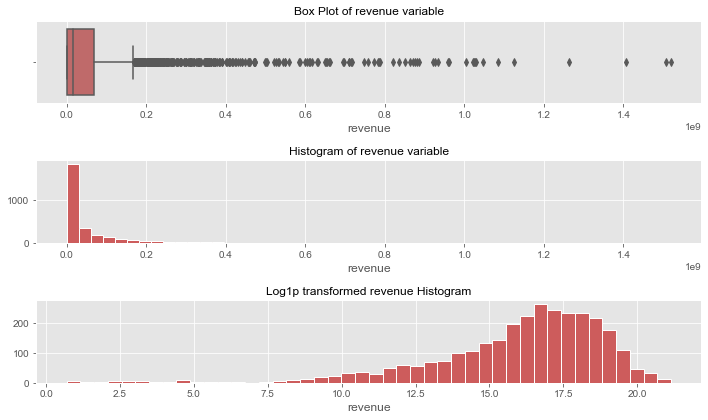

In [11]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.revenue, ax = ax[0], color='indianred')
ax[0].set_title("Box Plot of revenue variable")
sns.distplot(a=train.revenue, kde = False, ax = ax[1], color='indianred', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of revenue variable")
sns.distplot(a=np.log1p(train.revenue), kde = False, ax = ax[2], color='indianred', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed revenue Histogram")
f.tight_layout()



In [12]:
log_features.append("revenue")

We first look at our target variable, revenue, and can see the distribution is heavily skewed to the right. This makes sense beacause the average movie is making nearly $67 million, but there are so many movies that make hundreds of millions every year, ebing the most major hits in the box office. All of these major releases heavily skew teh revenue data, so the distribution is much more managable after a log transform.

### Belongs to Collection 

This column represents whether the film belongs to a collection, meaning it is a part of a greater series or collection of movies rather than standalone. The movies that belong to a collection have the collection listed as a string in the column, whereas if there is no collection then it is left as NA. We will modify the column to be a 1 if the movie is in a collection and 0 if it is not so it is easier to work with.

In [13]:
train.belongs_to_collection = train.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)
test.belongs_to_collection = test.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)

In [14]:
print(train.belongs_to_collection.value_counts())

0    2396
1     604
Name: belongs_to_collection, dtype: int64


The majority of the movies seem to be standalone, which is what would be expected

#### Univariate Analysis

In [15]:
# plotting belongs to collection data
labels = 'Belongs to Collection', 'Not in Collection'
btc_1 = [sum(train.belongs_to_collection), (train.belongs_to_collection == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['mediumorchid', 'darkmagenta']

# plot
fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))


From a total of 3000 data points, 604 or 20.1% were a part of a collection of films, while the other 2396 or 79.9% were not. Belonging to a collection has the potential to be an important feature when predicting revenue as customers may be more likely to pay for a movie-going experience when it is the next iteration of a series into which they have already invested time and money. The origin of serial media is largely accredited to The Pickwick Papers, written by Charles Dickens in 1836, and has since boomed all the way into the 21st century. Given the current and historic popularity of the format, it is hypothesized that belonging to a collection will indicate a positive correlation with revenue.

In [16]:
train.isna().sum()

id                          0
belongs_to_collection       0
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

#### Bivariate Analysis

0    2396
1     604
Name: belongs_to_collection, dtype: int64


[Text(0, 0, 'Not in Collection'), Text(0, 0, 'Belongs to Collection')]

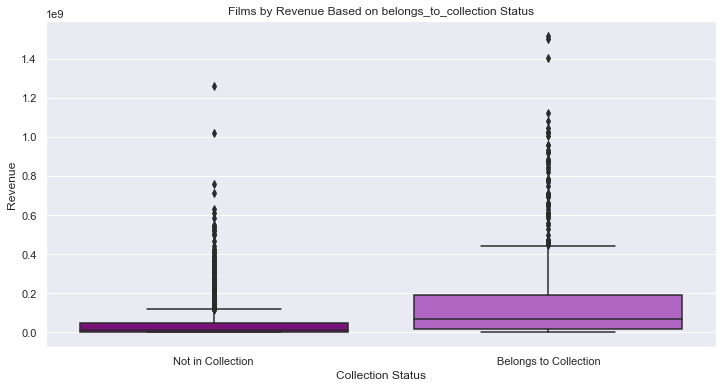

In [17]:
# bivariate analysis of revenue with belongs_to_collection
print(train['belongs_to_collection'].value_counts())

labels = 'Not in Collection', 'Belongs to Collection'

pal1 = ['darkmagenta', 'mediumorchid']

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(x='belongs_to_collection', y='revenue', data=train, palette=pal1)
plt.title('Films by Revenue Based on belongs_to_collection Status')
plt.ylabel("Revenue")
plt.xlabel("Collection Status")

ax.set_xticklabels(labels)

The graph above supports the hypothesis that belonging to a collection enhances a film's revenue in a positive correlation. More work could be done to quantify the precise benefit associated with a film's status as 'Belongs in Collection.'

In [18]:
train_features.append('belongs_to_collection')

In [19]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['belongs_to_collection'], train['revenue'])
print('Pearsons correlation between belongs_to_collection and revenue: %.3f' % corr)
corr, _ = pearsonr(train['belongs_to_collection'], np.log1p(train['revenue']))
print('Pearsons correlation between belongs_to_collection and the log transformed revenue: %.3f' % corr)

Pearsons correlation between belongs_to_collection and revenue: 0.339
Pearsons correlation between belongs_to_collection and the log transformed revenue: 0.257


As hypothesized, there does turn out to be a small positive correlation between the film's belonging to a collection and the revenue

### Budget

This column represents the budget of the film, meaning how much money they put into it. Intuitively, this seems like it would be a very important variable in regards to revenue, because likely the higher budget, and higher production movies, will do better, but this is certainly not always the case and worth further exploration 

#### Univariate Analysis

In [20]:
print('Movies missing a budget:',train.budget.isna().sum())

Movies missing a budget: 0


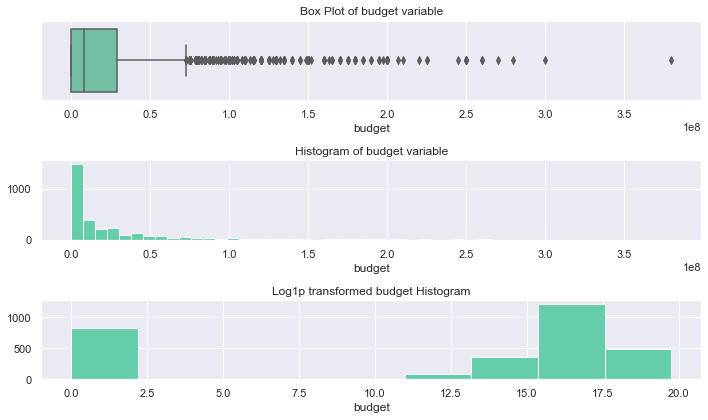

In [21]:
#plotting the data
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.budget, ax = ax[0], color='mediumaquamarine')
ax[0].set_title("Box Plot of budget variable")
sns.distplot(a=train.budget, kde = False, ax = ax[1], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of budget variable")
sns.distplot(a=np.log1p(train.budget), kde = False, ax = ax[2], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed budget Histogram")
f.tight_layout()

In [22]:
print('Movies with budget listed as 0: ',(train.budget == 0).sum())

Movies with budget listed as 0:  812


The distribution on budget in the training set is also heavily skewed right for similar reasons to revenue, so we also look at the log transformed distribution. Additionally, while there are no movies missing a budget, there are over 800 movies in our training set that have a budget of 0. This is highly unlikely to be accurate and every film has some kind of budget, so it is likely that the films where the budget was not found were replaced with 0. To clean up this data, we will replace these 0 values with the median budget to reduce the skew.

In [23]:
median = train.loc[train['budget'] > 0, 'budget'].median()
train["budget_processed"] = train["budget"].mask(train["budget"] == 0, median)
test["budget_processed"] = test["budget"].mask(test["budget"] == 0, median)

In [24]:
train.nsmallest(10, 'budget_processed')['budget_processed']

334     1
695     1
849     1
1346    1
2255    1
1754    2
2032    4
1198    5
1800    5
639     6
Name: budget_processed, dtype: int64

There seem to be a lot of bad values beyond just the ones that equal 0. We will also replace all values for budget under 10,000 USD since this is a reasonabe minimum value. No major feature films are produced for under 10,000 USD, and one of the most famous examples of a successful low budget film was The Blair Witch Project, which still had a 40,000 USD budget.

In [25]:
median = train.loc[train['budget'] >= 10000, 'budget'].median()
train["budget_processed"] = train["budget"].mask(train["budget"] < 10000, median)
test["budget_processed"] = test["budget"].mask(test["budget"] < 10000, median)

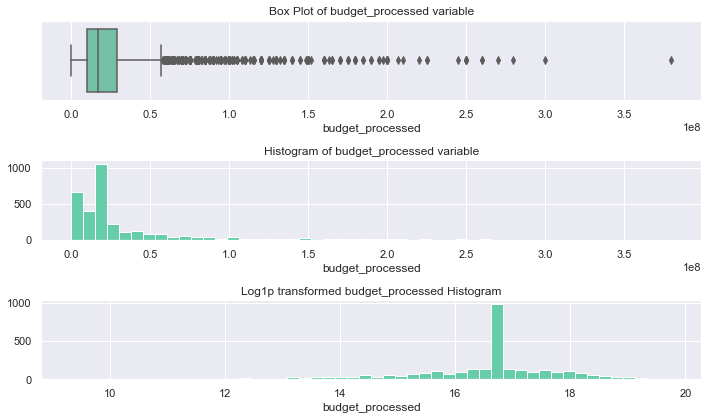

In [26]:
#plotting the data
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.budget_processed, ax = ax[0], color='mediumaquamarine')
ax[0].set_title("Box Plot of budget_processed variable")
sns.distplot(a=train.budget_processed, kde = False, ax = ax[1], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of budget_processed variable")
sns.distplot(a=np.log1p(train.budget_processed), kde = False, ax = ax[2], color='mediumaquamarine', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed budget_processed Histogram")
f.tight_layout()


Since there were so many values that are under 10,000 in the budget column, there is a huge cluster of data at this median value. This distribution still is not ideal, so we will find a better way to replace these values later on.

#### Bivariate Analysis

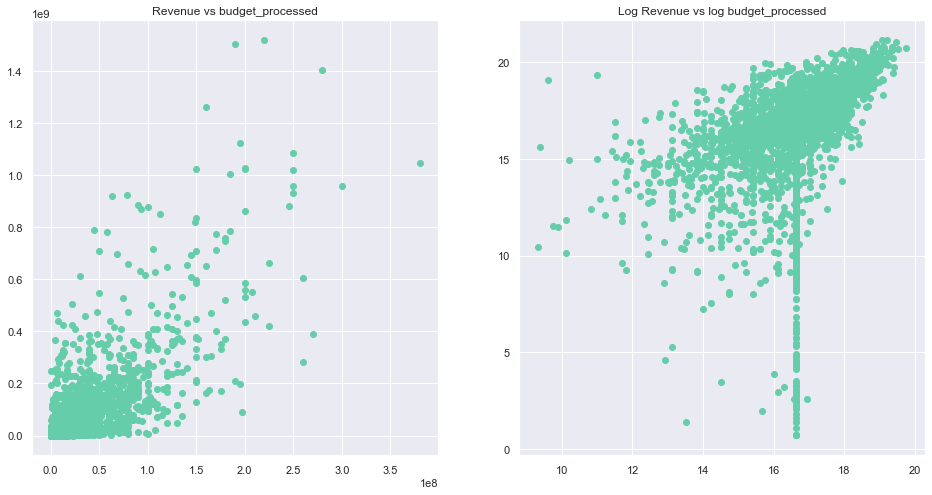

In [27]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget_processed'], train['revenue'], color='mediumaquamarine')
plt.title('Revenue vs budget_processed');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget_processed']), np.log1p(train['revenue']), color='mediumaquamarine')
plt.title('Log Revenue vs log budget_processed');

In [28]:
log_features.append('budget_processed')

In [29]:
#analysis of correlation and create log feature probably
corr, _ = pearsonr(train['budget_processed'], train['revenue'])
print('Pearsons correlation between budget_processed and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['budget_processed']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed transformed budget_processed and log transformed revenue: %.3f' % corr)

Pearsons correlation between budget_processed and revenue: 0.746
Pearsons correlation between log transformed transformed budget_processed and log transformed revenue: 0.373


We can see there is a fairly strong correlation between the budget and the revenue variables

### Genres

This column represents the genre(s) of a film. Different genres may expect perform differently in the box office, so this may an interesting variable to explore and see if there is a relation to revenue.

In [30]:
train['genres'].head()

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [31]:
print("Movies misssing genres: ",train['genres'].isna().sum())

Movies misssing genres:  7


The genres column is pretty messy and has a lot of excess information that we do not need. We will first need to do some preprocessing to work with the data. We utilize a regular expression to extract the genre names and create a list of the genres for each film in a new column. We will also fill in the NA values with a blank string.

#### Pre-processing

In [32]:
train['genres'] = train['genres'].fillna('')
train['genres_reform'] = train['genres'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

test['genres'] = test['genres'].fillna('')
test['genres_reform'] = test['genres'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

Now that we have the list of genres for each film, we will unpack all of the genres into a new dataframe in order to explore the data more easily

In [33]:
# Function to unpack all of the different genres into unique columns
def unpackCol(list, df):
    for i in range(len(df)):
        for name in list[i]:
            if name not in df.columns:
                df[name] = 0
            df[name][i] = 1
    return df

In [34]:
df = pd.DataFrame()
df = unpackCol(train['genres_reform'], train)

print(df.columns)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'budget_processed', 'genres_reform', 'Comedy', 'Drama', 'Family',
       'Romance', 'Thriller', 'Action', 'Animation', 'Adventure', 'Horror',
       'Documentary', 'Music', 'Crime', 'Science Fiction', 'Mystery',
       'Foreign', 'Fantasy', 'War', 'Western', 'History', 'TV Movie'],
      dtype='object')


In [35]:
# new feature for a count of the number of genres
train['num_genres'] = train.genres_reform.apply(lambda x: len(x))
test['num_genres'] = test.genres_reform.apply(lambda x: len(x))

train['num_genres'].value_counts()

2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: num_genres, dtype: int64

We create a new column to count the number of genres listed for a movie, this may be interesting to see if there is any correlation with revenue

#### Univariate Analysis

Text(0.5, 0, 'Genre')

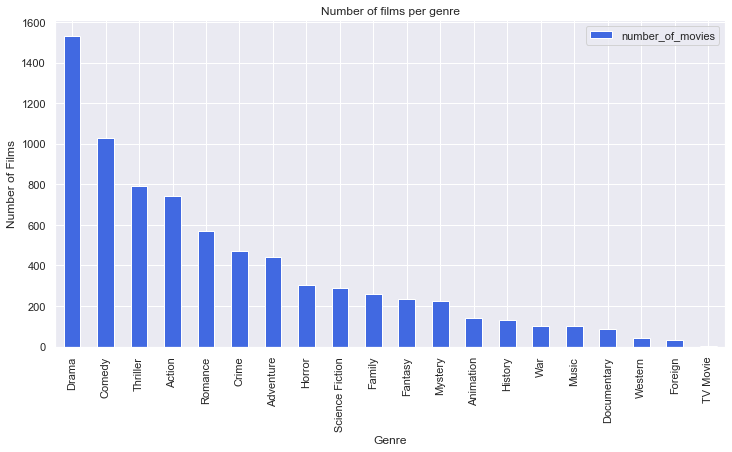

In [36]:
# plotting genres in order of number of instances in the df.csv dataset
genresDict = dict()

for genre in df["genres_reform"]:
    for elem in genre:
        if elem not in genresDict:
            genresDict[elem] = 1
        else:
            genresDict[elem] += 1


sns.set(rc={'figure.figsize':(12,6)})
genres_df = pd.DataFrame.from_dict(genresDict, orient='index')
genres_df.columns = ["number_of_movies"]
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)
genres_df.plot.bar(color='royalblue')
plt.title("Number of films per genre")
plt.ylabel("Number of Films")
plt.xlabel("Genre")

Genres of movies follow certain trends in popularity; such as the latest boom of superhero movies originating in the 1990s with 20th Century Fox's X-Men series. Although superhero films have been around since at least 1978 with Richard Donner's Superman, the recent trend has helped define the film industry over the past two decades. For the purposes of this report, Action/Adventure films (and Fantasy) encompass superhero films, but also many other types of popular films subgenres.

Action and Adventure do relatively well in terms of number of films, so it could be hypothesized that more common genres are more popular, meaning that Drama, Comedy, and Thriller movies should see the highest respective revenues. Regardless, the importance of genre for determining the revenue of a film (and likewise predicting future success) will be highly useful given the sometimes nebulous patterns of viewership. 

In [37]:
# list of film genres by order of number of films in set
print(df['Drama'].sum())
print(df['Comedy'].sum())
print(df['Thriller'].sum())
print(df['Action'].sum())
print(df['Romance'].sum())
print(df['Crime'].sum())
print(df['Adventure'].sum())
print(df['Horror'].sum())
print(df['Science Fiction'].sum())
print(df['Family'].sum())
print(df['Fantasy'].sum())
print(df['Mystery'].sum())
print(df['Animation'].sum())
print(df['History'].sum())
print(df['War'].sum())
print(df['Music'].sum())
print(df['Documentary'].sum())
print(df['Western'].sum())
print(df['Foreign'].sum())
print(df['TV Movie'].sum())

1531
1028
789
741
571
469
439
301
290
260
232
225
141
132
100
100
87
43
31
1


In the case of genres, we see a near logarithmic function from Drama (1531 films) to TV Movies (1). It is assumed that this dataset is representative of broader filmography trends for the purposes of constructing hypotheses about the data. The more popular genres should typically see a likewise correlation in revenue given the increased popularity. However, it is worth considering the unique attraction of 'rare genre' films. Musicals like La La Land grossed S446.1 million for its Box Office total and did so with only a $30 million budget. Therefore, the possibility for outliers or even inverse hypotheses are worth considering.

#### Bivariate Analysis

In [38]:
# bivariate analysis of revenue with genre
# creating a callable index for genres
genres_df.index.values
for g in genres_df.index.values:
    df[g] = df['genres_reform'].apply(lambda x: 1 if g in x else 0)

# median revenue per genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "median_rev"] = df[df[g]==1].revenue.median()
    
genres_df.sort_values(by=["number_of_movies", "median_rev"], ascending=False).head(10)

# mean revenue for genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "mean_rev"] = df[df[g]==1].revenue.mean()

genres_df.sort_values(by=["number_of_movies", "mean_rev"], ascending=False).head(10)

number_of_movies  median_rev      mean_rev
Drama                        1531  11293663.0  4.540607e+07
Comedy                       1028  18809184.0  6.087574e+07
Thriller                      789  21890845.0  6.833664e+07
Action                        741  36000000.0  1.110434e+08
Romance                       571  14016568.0  5.270501e+07
Crime                         469  24048000.0  5.949128e+07
Adventure                     439  59700000.0  1.758095e+08
Horror                        301  17037887.0  5.270907e+07
Science Fiction               290  35109301.5  1.223672e+08
Family                        260  57470029.5  1.388978e+08

Text(0.5, 0, 'Genre')

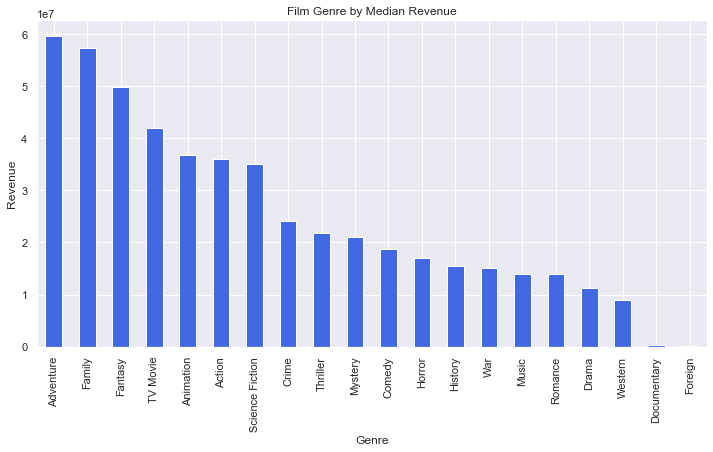

In [39]:
# genres by median revenue
genres_df.sort_values(by=["median_rev"], ascending=False).median_rev.plot.bar(color='royalblue')
plt.title("Film Genre by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

Text(0.5, 0, 'Genre')

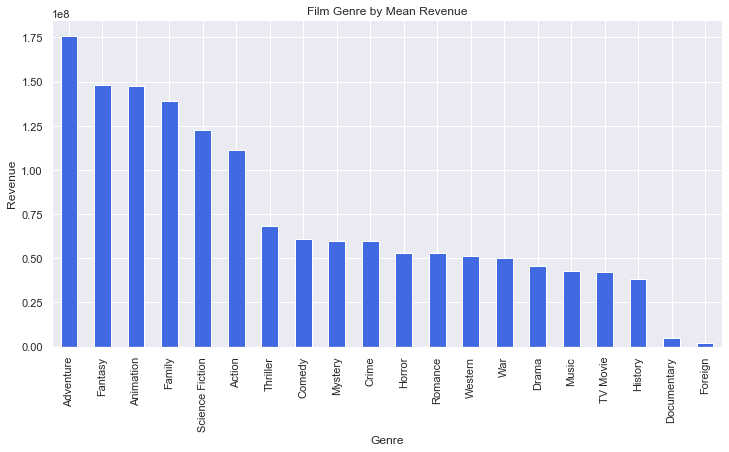

In [40]:
# genres by mean revenue
genres_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.plot.bar(color='royalblue')
plt.title("Film Genre by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

In both 'Film Genre by Median Revenue' and 'Film Genre by Mean Revenue' Adventure films have the highest revenue values, with fairly consistent ordering down save a few notable changes. For example, using 'median_rev' the TV Movie genre scores fourth highest revenue, while using 'mean_rev' lowers the genre to fourth lowest revenue. History loses five places from 'median_rev' to 'mean_rev' and Comedy goes up three.

Although some common film genres (those with higher numbers of films in the training data) do well with regards to revenue, the overall hypothesis that commonality of a film would correlate positively to revenue is disproven with the relatively lower revenues for Dramas, Comedies, and Thrillers (the top three most numerous film genres). This could be a result of saturated genre demand, or it could be unrelated. What is certain is that Adventure, Family, Fantasy, and Animation score well with regards to median and mean revenue.

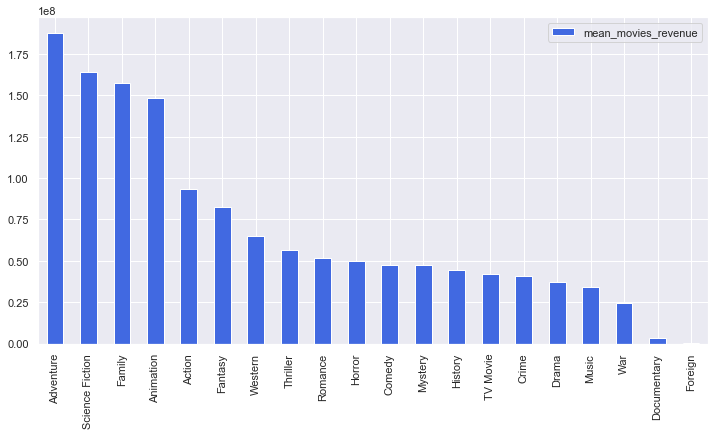

In [41]:
topGenreDict = {}
for element in train[["revenue", "genres_reform"]].values:
   # compare results when looking at top genre
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in topGenreDict:
            topGenreDict[element[1][i]] = [element[0], 1]
        else:
            topGenreDict[element[1][i]][0] += element[0]
            topGenreDict[element[1][i]][1] += 1    

for genre in topGenreDict:
    topGenreDict[genre][0] = topGenreDict[genre][0]/topGenreDict[genre][1]
    topGenreDict[genre] = topGenreDict[genre][0]


    
    
genres_df = pd.DataFrame.from_dict(topGenreDict, orient='index', columns=["mean_movies_revenue"])
genres_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='royalblue')

In [42]:
# Sort both of our dicts of genres and top genres to more easily access the 'most successful genres'
topGenreDict = {k: v for k, v in sorted(topGenreDict.items(), key=lambda item: item[1], reverse = False)}
genresDict = {k: v for k, v in sorted(genresDict.items(), key=lambda item: item[1], reverse = True)}
print(topGenreDict)
print(genresDict)

{'Foreign': 140650.0, 'Documentary': 3538249.971830986, 'War': 24388514.85, 'Music': 33890384.55, 'Drama': 37298750.1133758, 'Crime': 40820052.02040816, 'TV Movie': 42000000.0, 'History': 44237822.875, 'Mystery': 47674838.90909091, 'Comedy': 47754836.36092715, 'Horror': 49586852.62352941, 'Romance': 51648567.82089552, 'Thriller': 56574423.54310345, 'Western': 64905713.538461536, 'Fantasy': 82345105.41176471, 'Action': 93596599.80576923, 'Animation': 148089684.90789473, 'Family': 157347482.6111111, 'Science Fiction': 163833801.36585367, 'Adventure': 187715537.32085562}
{'Drama': 1531, 'Comedy': 1028, 'Thriller': 789, 'Action': 741, 'Romance': 571, 'Crime': 469, 'Adventure': 439, 'Horror': 301, 'Science Fiction': 290, 'Family': 260, 'Fantasy': 232, 'Mystery': 225, 'Animation': 141, 'History': 132, 'Music': 100, 'War': 100, 'Documentary': 87, 'Western': 43, 'Foreign': 31, 'TV Movie': 1}


In [43]:
def getGenreRank(genres):
    sum = 0
    for g in genres:
        sum += list(topGenreDict.keys()).index(g)
    return (sum / len(genres))

In [44]:
train['genre_rank'] = train['genres_reform'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)
test['genre_rank'] = test['genres_reform'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)

train['genre_rank'].value_counts()

9.000000     273
4.000000     270
8.000000     229
10.000000    216
7.500000     132
            ... 
11.142857      1
14.600000      1
16.600000      1
12.200000      1
10.800000      1
Name: genre_rank, Length: 132, dtype: int64

Using the dictionary of the top genres (by revenue) we effectively create a ranking system that we will use as a feature for our model. The higher the genre ranking of a film (based on an average of all listed genres), the less revenue that genre tends to generate.

In [45]:
log_features.append('genre_rank')
log_features.append('num_genres')

In [46]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['genre_rank'], train['revenue'])
print('Pearsons correlation between genre_rank and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['genre_rank']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed genre_rank and log transformed revenue: %.3f' % corr)

Pearsons correlation between genre_rank and revenue: 0.324
Pearsons correlation between log transformed genre_rank and log transformed revenue: 0.303


In [47]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_genres'], train['revenue'])
print('Pearsons correlation between num_genres and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_genres']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed num_genres and log transformed revenue: %.3f' % corr)

Pearsons correlation between num_genres and revenue: 0.164
Pearsons correlation between log transformed num_genres and log transformed revenue: 0.191


We find that there is a small positive correlation between our created ranking of genres and revenue, and then a weaker correlation between the number of genres and the revenue

### Homepage

This column has the homepage of the film's website, if it has one. This variable is interesting because there is a chance that more well known movies have a homepage, or even that movies with a homepage become more well known, and are more likely to be more successful

#### Univariate Analysis

In [48]:
#homepage
print('Movies missing a homepage:',train.homepage.isna().sum())

Movies missing a homepage: 2054


Since the homepage itself is very unique and specific to each particular film, it not of much use to us and we will not be analyzing the content of the homepage for this project. Instead, we will create a new column representing whether a move has a homepage or not.

In [49]:
#Creating new column
train['has_homepage'] = train.homepage.apply(lambda x: 0 if pd.isnull(x) else 1)
test['has_homepage'] = test.homepage.apply(lambda x: 0 if pd.isnull(x) else 1)
train['has_homepage'].value_counts()

0    2054
1     946
Name: has_homepage, dtype: int64

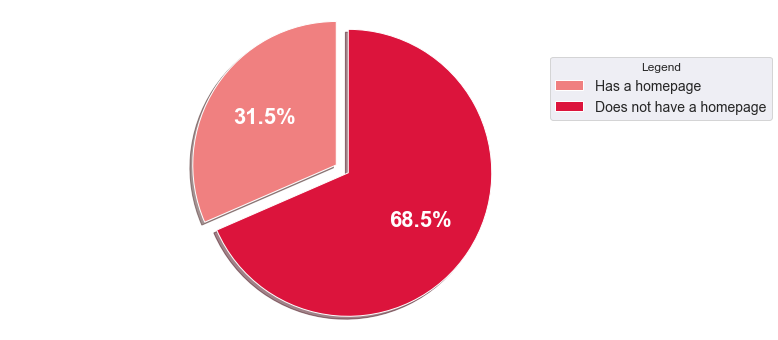

In [50]:
# plotting 'has a homepage' data
labels = 'Has a homepage', 'Does not have a homepage'
btc_1 = [sum(train.has_homepage), (train.has_homepage == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['lightcoral', 'crimson']

fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal')

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

plt.show()


We can see that of the 3000 datapoints in the train set, 2054 of them, or 68.5%, do not have a homepage. The remaining 946, or 31.5%, do have a homepage and this may be the ore known fils, or possibly even higher production movies. It is also possible that more movies do in fact have a homepage or website, however they could just be missing from the dataset as there is no way to tell the difference between missing data and movies that do not have a homepage, since both are marked as NA.

#### Bivariate Analysis

In [51]:
print("Mean revenue for movies with a homepage: %.2f" % train.loc[train['has_homepage'] == 1, "revenue"].mean())
print("Median revenue for movies with a homepage: %.2f" % train.loc[train['has_homepage'] == 1, "revenue"].median())
print()
print("Mean revenue for movies without a homepage: %.2f" % train.loc[train['has_homepage'] == 0, "revenue"].mean())
print("Median revenue for movies without a homepage: %.2f" % train.loc[train['has_homepage'] == 0, "revenue"].median())

Mean revenue for movies with a homepage: 120051698.84
Median revenue for movies with a homepage: 35455217.00

Mean revenue for movies without a homepage: 42165846.43
Median revenue for movies without a homepage: 12328641.50


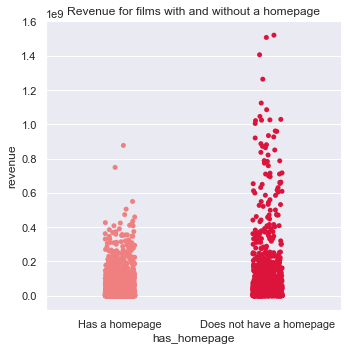

In [52]:
pal1 = ['lightcoral', 'crimson']

ax = sns.catplot(x='has_homepage', y='revenue', data=train, palette=pal1);
plt.title('Revenue for films with and without a homepage');

labels = 'Has a homepage', 'Does not have a homepage'
ax.set_xticklabels(labels)

In [53]:
train_features.append('has_homepage')

In [54]:
corr, _ = pearsonr(train['has_homepage'], train['revenue'])
print('Pearsons correlation between has_homepage and revenue: %.3f' % corr)
corr, _ = pearsonr(train['has_homepage'], np.log1p(train['revenue']))
print('Pearsons correlation between has_homepage and log transformed revenue: %.3f' % corr)

Pearsons correlation between has_homepage and revenue: 0.263
Pearsons correlation between has_homepage and log transformed revenue: 0.143


We can see there is small positive correlation between the precence of a homepage and the revenue. We also observe in the categorical plot that the movies without a homepage do in fact reach much greater revenues, however this is more so likely becasue there is a much greater number of movies in the category. We also do see that the mean revenue is higher for movies without a homepage is much higher, but this is clearly due to the skew since the median revenuw for movies with a homepage turns out to be larger.

### IMDb ID

This column represents the id used by IMDb for a film. This id could be useful if we wanted to gather more data from the IMDb page for each film, but that is outside the scope of this project.This column does not really serve a purpose to us and since it is just an indentification number, there is not a need for any analysis.

In [55]:
cols_to_drop.append("imdb_id")

### Original Language

This column represents the original language that the film was released in

#### Univariate Analysis

In [56]:
print("Counts of each original language:")
print(train['original_language'].value_counts()[:10])

Counts of each original language:
en    2575
fr      78
ru      47
es      43
hi      42
ja      37
it      24
ko      20
cn      20
zh      19
Name: original_language, dtype: int64


Text(0.5, 1, 'Revenue for a movie and its and original_language')

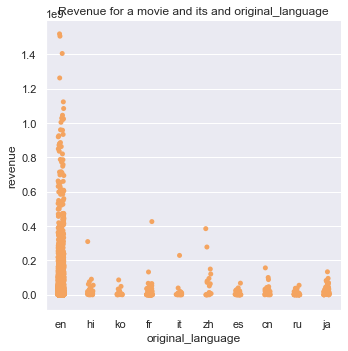

In [57]:
sns.catplot(x='original_language', y='revenue', color='sandybrown', data=train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)])
plt.title('Revenue for a movie and its and original_language')

Since 2575 of the 3000 movies in the training were originally released in English, and all other languages making up only a small portion of the movies, we will create a new dummy variable, simply specifying if the movie was released in english or not. It seems that it is not important what the specific other language is, but rather just that the movie is not english is most significant for our model. Additionally, the films that are in english reach mich higher revenues, so this may be a good feature to include.

In [58]:
#Creating new feature
train['originally_english'] = train.original_language.apply(lambda x: 1 if x == 'en' else 0)
test['originally_english'] = test.original_language.apply(lambda x: 1 if x == 'en' else 0)
train['originally_english'].value_counts()

1    2575
0     425
Name: originally_english, dtype: int64

In [59]:
# plotting original data
labels = 'In English', 'Not in English'
btc_1 = [(train.originally_english == 1).sum(axis=0), (train.originally_english == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['sandybrown', 'peachpuff']

fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

plt.show()


#### Bivariate Analysis

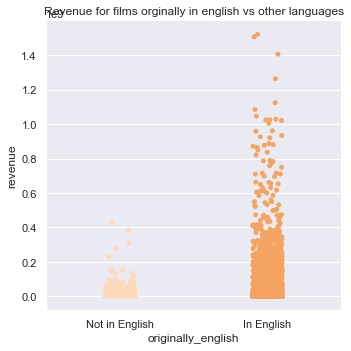

In [60]:
pal2 = ['peachpuff', 'sandybrown']

ax = sns.catplot(x='originally_english', y='revenue', data=train, palette=pal2);
plt.title('Revenue for films orginally in english vs other languages');

labels = 'Not in English', 'In English'
ax.set_xticklabels(labels)

In [61]:
train_features.append('originally_english')

In [62]:
#analysis of correlation and create log feature probably
corr, _ = pearsonr(train['originally_english'], train['revenue'])
print('Pearsons correlation between in_english and revenue: %.3f' % corr)

Pearsons correlation between in_english and revenue: 0.142


We can see there is a weak positive correlation between the films being in english and the revenue of the film. While the films in english reach much greater revenues overall, this may just be simply because there are a far greater number of films released in english.


### Original Title

This column represents the original title of a movie, likely before it is released. There is another column with the final title of the film, making this column fairly useless to our model. We could not come up with any advantages to analyzing this variable, so we will just drop it.

In [63]:
cols_to_drop.append('original_title')

### Overview

This column contains the overview for a film, which is simply a general summary of what the film is about

#### Univariate Analysis

In [64]:
#overview
print('Movies missing an overview:',train.overview.isna().sum())

Movies missing an overview: 8


We will first fill the films that are missing overviews with an empty string, then for the sake of our model we will ust be looking at the length of the overview. The content in the overview could be something that is interesting to analyze, but we will not be looking at it for the scope of this project.

In [65]:
train.overview = train.overview.fillna("")
train['overview_len'] = train.overview.apply(len)
test.overview = test.overview.fillna("")
test['overview_len'] = test.overview.apply(len)

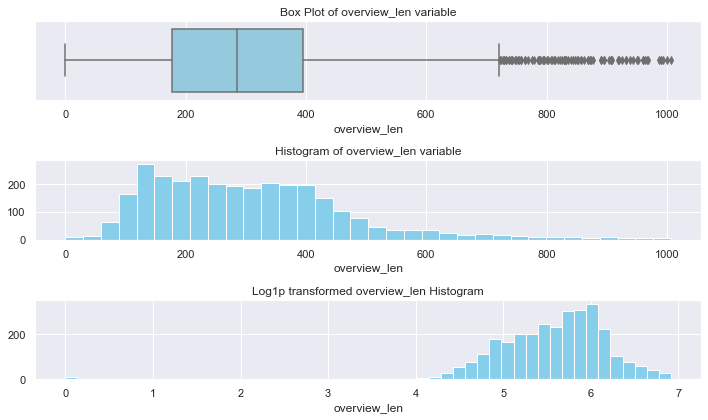

In [66]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.overview_len, ax = ax[0], color='skyblue')
ax[0].set_title("Box Plot of overview_len variable")
sns.distplot(a=train.overview_len, kde = False, ax = ax[1], color='skyblue', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of overview_len variable")
sns.distplot(a=np.log1p(train.overview_len), kde = False, ax = ax[2], color='skyblue', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed overview_len Histogram")
f.tight_layout()

#### Bivariate Analysis

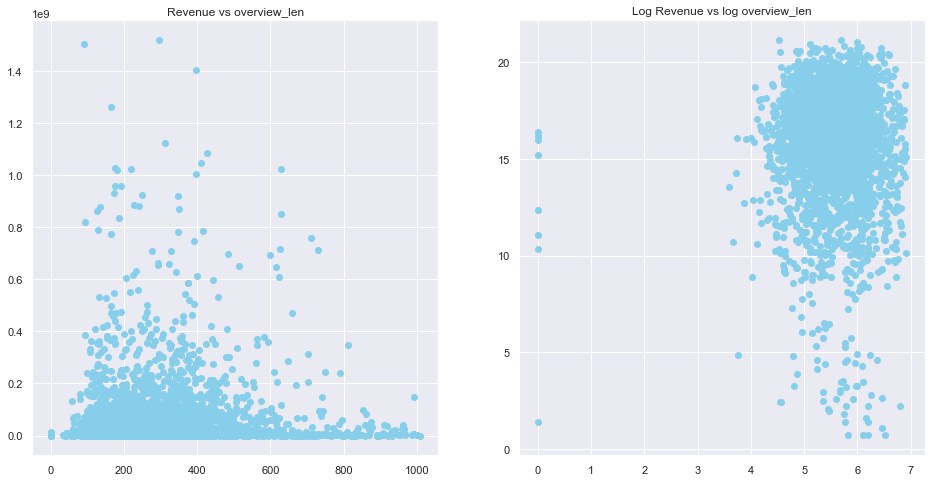

In [67]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['overview_len'], train['revenue'], color='skyblue')
plt.title('Revenue vs overview_len');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['overview_len']), np.log1p(train['revenue']), color='skyblue')
plt.title('Log Revenue vs log overview_len');

In [68]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['overview_len'], train['revenue'])
print('Pearsons correlation between overview_len and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['overview_len']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed  overview_len and log transformed revenue:: %.3f' % corr)

Pearsons correlation between overview_len and revenue: -0.005
Pearsons correlation between log transformed  overview_len and log transformed revenue:: 0.024


There appears to be virtually no correlation between these variables, and although we cannot rule out a relationship based solely on the Pearson's correlation, we will not include it in our model since the length of the overview is rather insignificant. If we were to perform some text analysis, the overview maybe useful and further examining the contents and patternsof the overviews of successful movies may be interesting, but that is outside of the scope of this project so we will drop this for now.

In [69]:
cols_to_drop.append('overview')

### Popularity

This column contains a metric for popularity of a movie, however it is very unclear what this number actually means. We will further explore the variable to gain more insight

#### Univariate Analysis

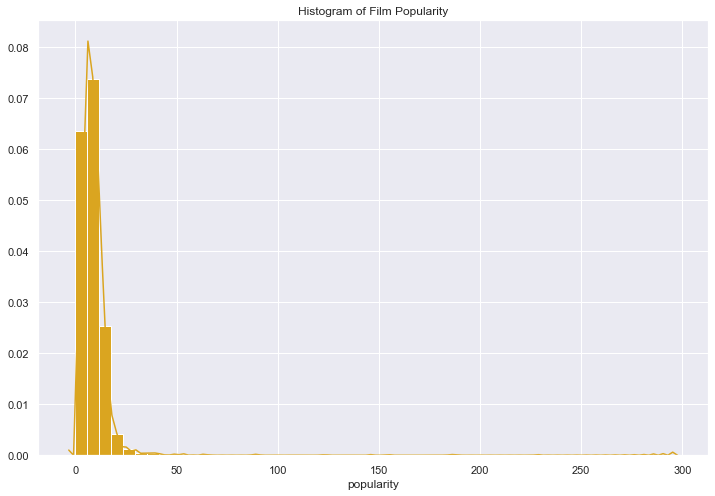

In [70]:
# plotting popularity
sns.distplot(train['popularity'], kde=True, color='goldenrod', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12, 2)})
plt.title('Histogram of Film Popularity')
plt.show();

In [71]:
print(train['popularity'].describe())

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


Popularity is likely to be a significant feature in prediting revenue outcome given the importance of popularity for movie viewership (this is of course contingent upon popularity refering to the 'hype' surrounding a film and not the post-release ratings - if the later than popularity should more directly map to revenue in theory). Because of the more popularity is a good thing for marketing, and thus increased ticket sales, it is hypothesized that popularity and revenue will have a positive correlation. 

Above it is seen that of the 3000 films in the dataset the average popularity was an 8.46 with a minimum of 0.00 and a max of 294.34. The histogram reveals that the bulk of the films fall between a popularity score of 0 and 25, with sparse highly popular outliers. Dealing with these outliers will be addressed later.

#### Bivariate Analysis

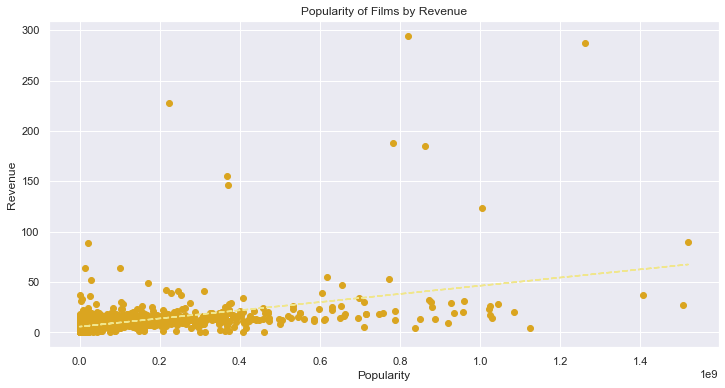

In [72]:
# bivariate: plotting popularity and revenue
sns.set(rc={'figure.figsize':(12, 6)})
cx = train['revenue']
pop = train['popularity']
plt.plot(cx, pop, 'o', color='goldenrod')
plt.ylabel("Revenue")
plt.xlabel("Popularity")
plt.title("Popularity of Films by Revenue")

z = np.polyfit(cx, pop, 1)
p = np.poly1d(z)
plt.plot(cx, p(cx), "--", color='khaki');


In [73]:
#analysis of correlation
corr, _ = pearsonr(train['popularity'], train['revenue'])
print('Pearsons correlation between popularity and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['popularity']), np.log1p(train['revenue']))
print('Pearsons correlation between log popularity and log revenue: %.3f' % corr)

Pearsons correlation between popularity and revenue: 0.461
Pearsons correlation between log popularity and log revenue: 0.542


In comparing popularity against revenue, there is an overall positive correlation. This is to be expected given the influence of popularity on a film's monetary success via more developed viewership. Further investigation should be conducted by playing around with the outlier values; notably, certain highly popular films do not see concurrently higher revenue, which leads to the conclusion that popularity is not a perfect indicator of a movie's revenue.

However, because of the confusion regarding outliers and the scale around which this value is produced, the feature is lacking in clarity. More detrimentally, the popularity can only be judged after the film has been released, which means it is not useful to a film studio as a metric by which to predict box office totals. Instead, popularity could be used as another label (akin to the idea of predicting for a movie's "rating" as opposed to its "revenue"). Regardless, for the purposes of this project the popularity feature will not be included in the model.

In [74]:
cols_to_drop.append('popularity')

### Poster Path

This column contains a path to the movie poster. Movie posters could be interesting to look at in terms of their relationships with revenue, but analyzing the contents of these posters is well outside the scope of this project.

#### Univariate Analysis

In [75]:
#poster_path
print('Movies missing a poster path:',train.poster_path.isna().sum())

Movies missing a poster path: 1


In [76]:
train.poster_path.head(10)

0    /tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg
1    /w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg
2    /lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg
3    /aTXRaPrWSinhcmCrcfJK17urp3F.jpg
4    /m22s7zvkVFDU9ir56PiiqIEWFdT.jpg
5    /6IDqA1D2NBIVhzEEaMMRL28iBrq.jpg
6    /4QjzFuaZmB4btGnLwAgdp23BzIU.jpg
7    /83BV8fGy5p9i8RwE9oj76tZ1Ikp.jpg
8    /5A8gKzOrF9Z7tSUX6xd5dEx4NXf.jpg
9    /xwD4EsPOGLuKP50Q1gwqAsyhAFB.jpg
Name: poster_path, dtype: object

Only 1 movie in the training set is missing a poster path, therefore it is likely not very useful for our model. Since we will not be analyzing the content found at the poster path, this variable is not of use to us and we will drop it.

In [77]:
cols_to_drop.append('poster_path')

### Production Companies

This column contains all of the procution companies that worked on each film. Since there are some incredibly popular studios that have repuations, this may play a role in predicting revenue.

In [78]:
train['production_companies'].head(10)

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                  NaN
4                                                  NaN
5                                                  NaN
6    [{'name': 'Ghost House Pictures', 'id': 768}, ...
7                                                  NaN
8    [{'name': 'Walt Disney Pictures', 'id': 2}, {'...
9    [{'name': 'Castle Rock Entertainment', 'id': 97}]
Name: production_companies, dtype: object

Much like the genres column, the data is a bit of mess and requires some pre-processing so that we can better analyze and work with it. We will utilize the same regular expression to extract studio names.

#### Pre-processing

In [79]:
train['production_companies'].isna()

0       False
1       False
2       False
3        True
4        True
        ...  
2995    False
2996    False
2997    False
2998    False
2999    False
Name: production_companies, Length: 3000, dtype: bool

In [80]:
train['production_companies'] = train['production_companies'].fillna('')
train['production_companies_reform'] = train['production_companies'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

test['production_companies'] = test['production_companies'].fillna('')
test['production_companies_reform'] = test['production_companies'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

df['production_companies'] = df['production_companies'].fillna('')
df['production_companies_reform'] = df['production_companies'].apply(lambda x:re.findall("'name': \'(.+?)\'", x))

The first thing we will look at after sorting out the data is the number of production studios on each film. This could be an interesting feature for our model.

In [81]:
# new column for a count of the number of production studios
train['num_studios'] = train.production_companies_reform.apply(lambda x: len(x))
test['num_studios'] = test.production_companies_reform.apply(lambda x: len(x))
df['num_studios'] = train.production_companies_reform.apply(lambda x: len(x))

train['num_studios'].value_counts()

1     781
2     734
3     582
4     308
5     166
0     157
6     116
7      69
8      36
9      27
10      8
11      6
15      3
12      3
14      2
13      1
16      1
Name: num_studios, dtype: int64

#### Univariate Analysis

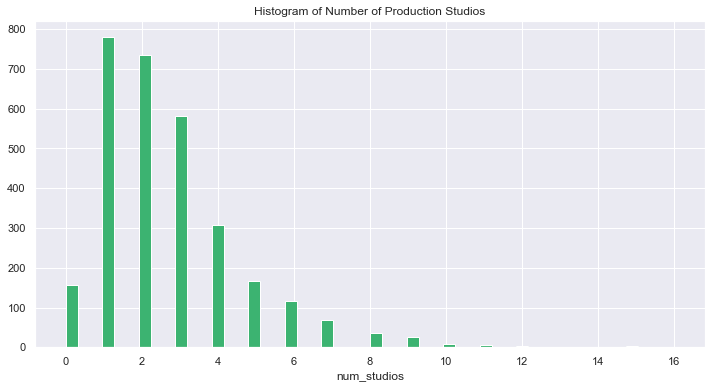

In [82]:
# plotting films by number of production studios
sns.distplot(train['num_studios'], kde=False, color='mediumseagreen', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})
plt.title('Histogram of Number of Production Studios')
plt.show();

Most movies have between 1 and 4 production studios, with fewer films having higher numbers and some even with 0 studio partners (independent films). However, given only the sheer number of production studios it is difficult to produce a reasonable hypothesis regarding the box office success of the film. Instead, determining the larger, more established, or otherwise previously successful production studios and applying those findings toward whether or not the dataset films in question have said studios would be a more useful way to analyze the impact of production companies.

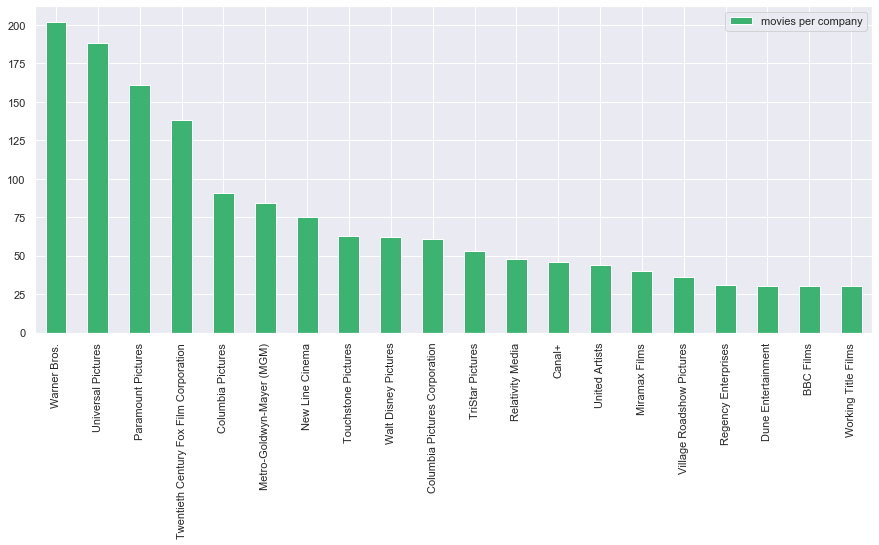

In [83]:
# production companies
companiesDict = {}
for element in train["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict:
            companiesDict[company] = 1
        else:
            companiesDict[company] += 1

companies_train = pd.DataFrame.from_dict(companiesDict, orient='index', columns=["movies per company"])
companies_train.sort_values(by="movies per company", ascending=False).head(20).plot.bar(color='mediumseagreen')

companies_train.columns = ["number_of_studios"]

Using the number of movies per production company may be useful for determining what the biggest studios are, and correlating how the size of a production company influences the success of its films. There are two possibilities; either 1. a larger studio has the funding and means to draw in big-name cast and crew, with the necessary experience to turn that into a successful film project or 2. the studio is too franchised to create successful novel ideas and merely continually pumps out mediocre performing films. While some of both is likely possible, machine learning will help to weigh the relative influence of studio size on the movie's predicted revenue. Marking whether or not one of these major studios is involved in a film will be a useful feature for determining this connection.

#### Bivariate Analysis

In [84]:
# bivariate analysis of revenue with production studios
# production companies copy
companiesDict2 = {}
for element in df["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict2:
            companiesDict2[company] = 1
        else:
            companiesDict2[company] += 1

companies_df = pd.DataFrame.from_dict(companiesDict2, orient='index', columns=["movies per company"])

companies_df.columns = ["number_of_studios"]

# creating a callable index for production studios
companies_df.index.values
for g in companies_df.index.values:
    df[g] = df['production_companies_reform'].apply(lambda x: 1 if g in x else 0)

# median revenue per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "median_rev"] = df[df[g]==1].revenue.median()
    
companies_df.sort_values(by=["number_of_studios", "median_rev"], ascending=False).head(10)

# mean revenue per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "mean_rev"] = df[df[g]==1].revenue.mean()

companies_df.sort_values(by=["number_of_studios", "mean_rev"], ascending=False).head(10)

# total revenue per production studio
for i, g in enumerate(companies_df.index.values):
    companies_df.loc[g, "sum_rev"] = df[df[g]==1].revenue.sum()

companies_df.sort_values(by=["number_of_studios", "sum_rev"], ascending=False).head(10)

number_of_studios   median_rev  \
Warner Bros.                                          202   55653705.5   
Universal Pictures                                    188   59540581.5   
Paramount Pictures                                    161   52034889.0   
Twentieth Century Fox Film Corporation                138   50589532.0   
Columbia Pictures                                      91   77737889.0   
Metro-Goldwyn-Mayer (MGM)                              84   13220811.0   
New Line Cinema                                        75   60740827.0   
Touchstone Pictures                                    63   34808403.0   
Walt Disney Pictures                                   62  160440216.0   
Columbia Pictures Corporation                          61   58853106.0   

                                            mean_rev       sum_rev  
Warner Bros.                            1.203347e+08  2.430760e+10  
Universal Pictures                      1.096708e+08  2.061812e+10  
Paramount Pictures                      1.247831e+08  2.009007e+10  
Twentieth Century Fox Film Corporation  1.139619e+08  1.572674e+10  
Columbia Pictures                       1.202844e+08  1.094588e+10  
Metro-Goldwyn-Mayer (MGM)               6.872146e+07  5.772602e+09  
New Line Cinema                         1.451592e+08  1.088694e+10  
Touchstone Pictures                     7.654655e+07  4.822432e+09  
Walt Disney Pictures                    3.037771e+08  1.883418e+10  
Columbia Pictures Corporation           7.591135e+07  4.630592e+09

Text(0.5, 0, 'Production Studio')

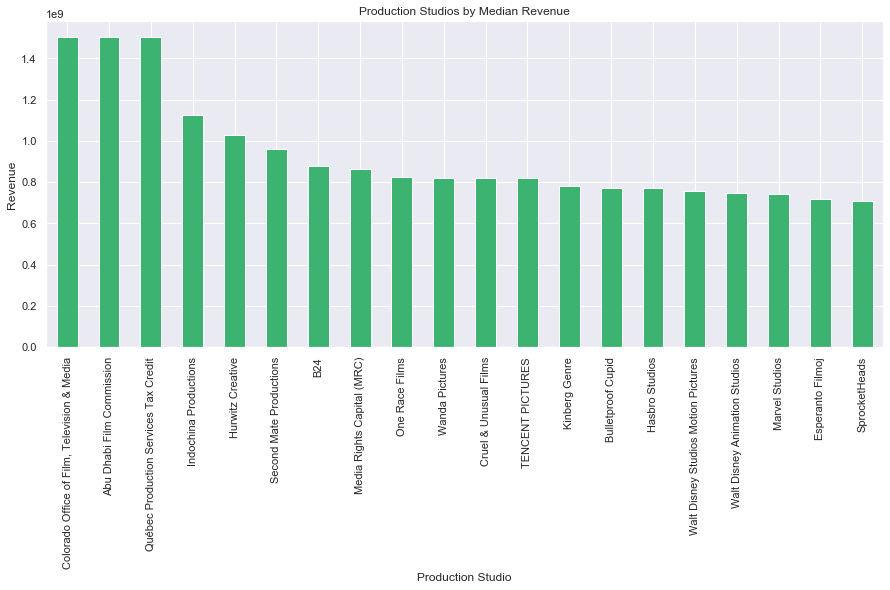

In [85]:
# production studios by median revenue
companies_df.sort_values(by=["median_rev"], ascending=False).median_rev.head(20).plot.bar(color='mediumseagreen')
plt.title("Production Studios by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

Text(0.5, 0, 'Production Studio')

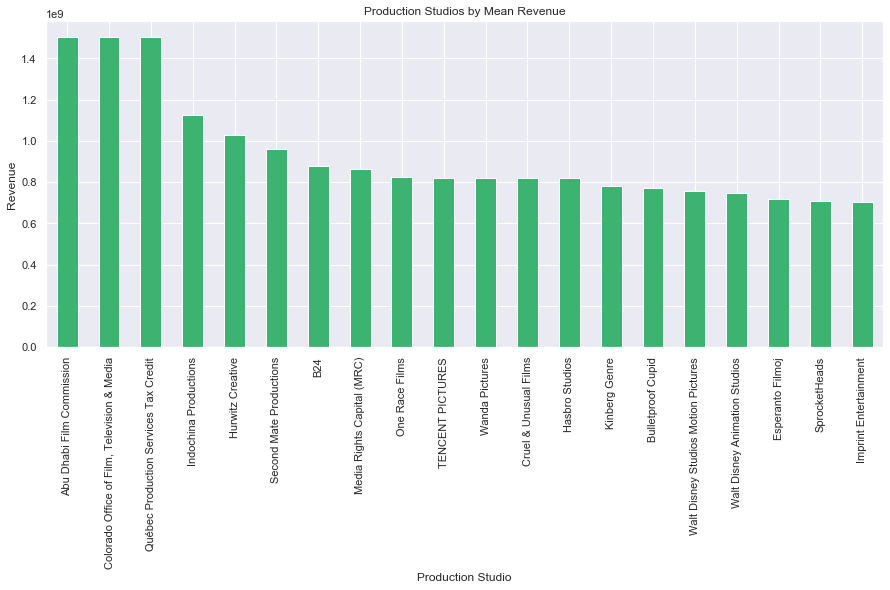

In [86]:
# production studios by mean revenue
companies_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.head(20).plot.bar(color='mediumseagreen')
plt.title("Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

Both mean and median revenue compared against the production studio provide relatively uninformative results. Namely, the Colorado Office of Film, Television & Media appears as a minor production studio for 'Furious 7' of the Fast & Furious Film Franchise. This is the only time it appears on the list, greatly skewing its influence on a film's revenue. Similarly, the Abu Dhabi Film Commision is involved in Furious 7 and seven other films including the highly profitable 'Ghost Rider: Spirit of Vengeance.' These outliers are unduly weighted with greater importance using this system, but other options exist.

Firstly, the total revenue of each production company can be analyzed to see the studio with the overall highest box office totals (although this is expected to mirror the largest studios with the greatest number of films). Secondly, the mean and median revenue values can be applied to only the primary production company working on a film.

Text(0.5, 0, 'Production Studio')

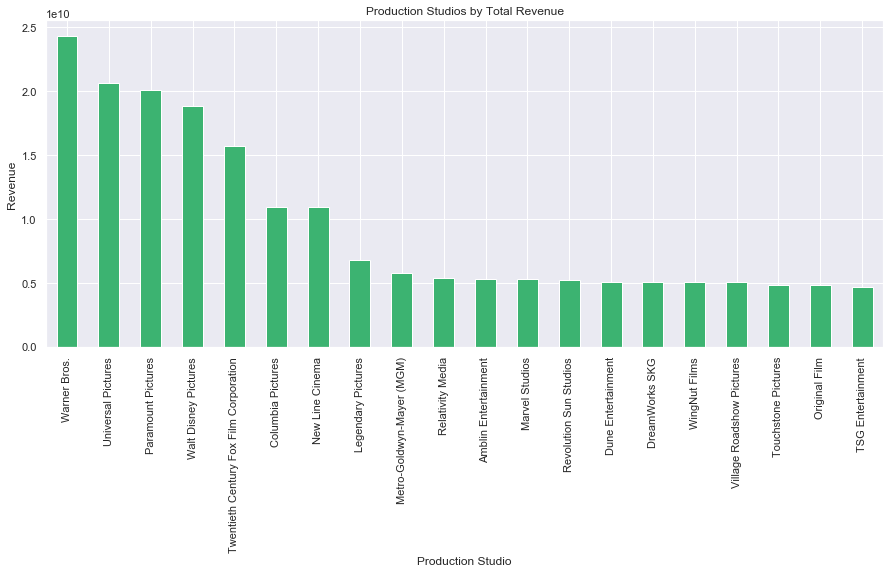

In [87]:
# production studios by total revenue
companies_df.sort_values(by=["sum_rev"], ascending=False).sum_rev.head(20).plot.bar(color='mediumseagreen')
plt.title("Production Studios by Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

As expected, the production studios largely mirror the studios with the largest number of films produced. One notable exception is Walt Disney Pictures which rises from ninth place in terms of films produced to fourth place for total revenue. While other studios change position some, the focus on primary studios should also be tried.

Text(0.5, 0, 'Production Studio')

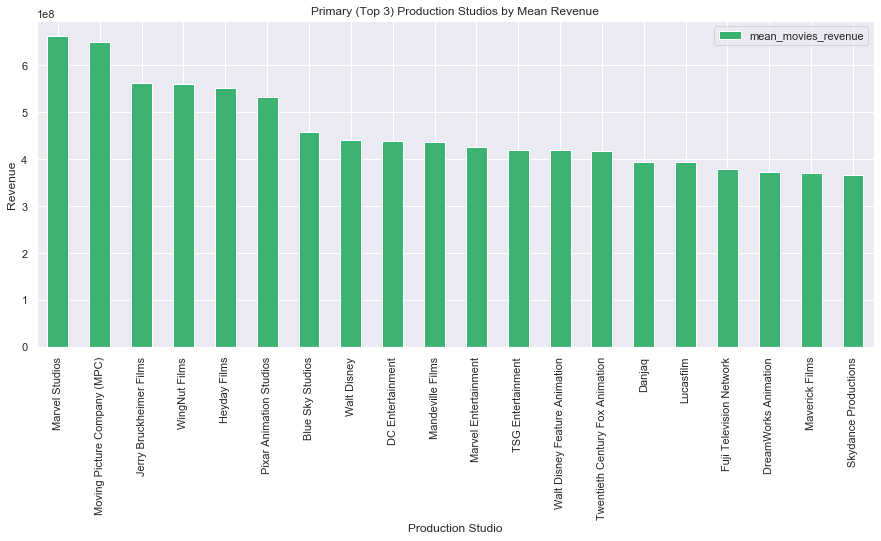

In [88]:
# isolating the primary production studios for the films
studiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
   # compare results when looking at x top production companies in films vs all affiliated studios 
    temp = 3
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in studiosDict:
            studiosDict[element[1][i]] = [element[0], 1]
        else:
            studiosDict[element[1][i]][0] += element[0]
            studiosDict[element[1][i]][1] += 1    

studiosDict = {k: v for k, v in studiosDict.items() if v[1] >= 3}

for company in studiosDict:
    studiosDict[company][0] = studiosDict[company][0]/studiosDict[company][1]
    studiosDict[company] = studiosDict[company][0]


    
    
studios_train = pd.DataFrame.from_dict(studiosDict, orient='index', columns=["mean_movies_revenue"])
studios_train.sort_values(by="mean_movies_revenue", ascending=False).head(20).plot.bar(color='mediumseagreen')
plt.title("Primary (Top 3) Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

When isolating the top three production studios from an example's production_companies feature, a different barplot for production studio by mean revenue is produced. Notably, the film commissions associated with regional media permitting only associated with one or several films with high revenue (see the Colorado Office of Film, Television & Media's listing on 'Furious 7') are eliminated from this method for analyzing the production studios. This allows for a more effective usage of mean revenue based on the primary studios, while also more appropriately treating the issue of studios with immense filmographies (such as Warner Bros.) receiving too high of a value for 'total revenue.'

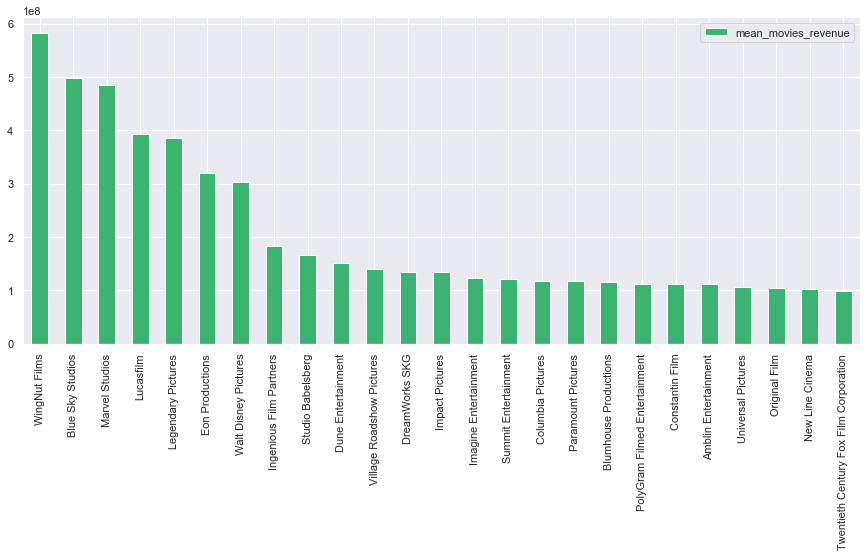

In [89]:
topStudiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
   # compare results when looking at x top studios
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in topStudiosDict:
            topStudiosDict[element[1][i]] = [element[0], 1]
        else:
            topStudiosDict[element[1][i]][0] += element[0]
            topStudiosDict[element[1][i]][1] += 1    

topStudiosDict = {k: v for k, v in topStudiosDict.items() if v[1] >= 5}

for company in topStudiosDict:
    topStudiosDict[company][0] = topStudiosDict[company][0]/topStudiosDict[company][1]
    topStudiosDict[company] = topStudiosDict[company][0]


    
    
studios_df = pd.DataFrame.from_dict(topStudiosDict, orient='index', columns=["mean_movies_revenue"])
studios_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='mediumseagreen')

In [90]:
# Sort both of our dicts of studios and top studios to more easily access the 'most successful studios'
topStudiosDict = {k: v for k, v in sorted(topStudiosDict.items(), key=lambda item: item[1], reverse = True)}
studiosDict = {k: v for k, v in sorted(studiosDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top studio'
def checkTopStudios(studio):
    if len(studio) < 1 or studio[0] not in list(topStudiosDict)[:50]:
        return 0
    else:
        return 1

def checkStudios(studio):
    if len(studio) < 1:
        return 0
    count = 0
    for company in studio[:10]:
        if company in list(studiosDict)[:100]:
            count += 1
    return count

def getStudioRanks(studios):
    if len(studios) < 1:
        return 400
    rank = 0
    for s in studios[:5]:
        if s in list(studiosDict):
            rank += list(studiosDict.keys()).index(s)
    if rank == 0:
        rank = 400
    return rank / len(studios)

#Creating a feature for top production studios
train['topStudio'] = train['production_companies_reform'].apply(lambda x: checkTopStudios(x))
test['topStudio'] = test['production_companies_reform'].apply(lambda x: checkTopStudios(x))
#Creating feature for number of top studios
train['numTopStudios'] = train['production_companies_reform'].apply(lambda x: checkStudios(x))
test['numTopStudios'] = test['production_companies_reform'].apply(lambda x: checkStudios(x))

studiosDict = {k: v for k, v in sorted(studiosDict.items(), key=lambda item: item[1], reverse = True)}

#Creating feature for number of top studios
train['studioRank'] = train['production_companies_reform'].apply(lambda x: getStudioRanks(x))
test['studioRank'] = test['production_companies_reform'].apply(lambda x: getStudioRanks(x))

print(train['topStudio'].value_counts())
print()
print(train['numTopStudios'].value_counts())
print()
print(train['studioRank'].value_counts())

0    1682
1    1318
Name: topStudio, dtype: int64

0    2187
1     597
2     158
3      52
4       4
5       2
Name: numTopStudios, dtype: int64

400.000000    470
200.000000    154
133.333333    104
91.000000      52
109.000000     40
             ... 
13.250000       1
49.500000       1
292.000000      1
229.000000      1
32.714286       1
Name: studioRank, Length: 986, dtype: int64


In [91]:
len(studiosDict)

399

In an attempt to quantify the impact of production studios, we created two dictionaries, one of all of the different studios and one of all of the primary studios (meaning the first one listed), and sorted based on the average revenue. We then created two new columns to help measure the impact of a studio, being topStudio and numTopStudios. The topStudio column represents if the primary studio listed is one of the top 25 primary studios listed, whereas the numTopStudios is a count of the number of top studios (by revenue) that worked on the film.

In [92]:
# analysis of correlation and create log feature
corr, _ = pearsonr(train['topStudio'], train['revenue'])
print('Pearsons correlation between topStudio and revenue: %.3f' % corr)
corr, _ = pearsonr(train['topStudio'], np.log1p(train['revenue']))
print('Pearsons correlation between topStudio and revenue: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['numTopStudios'], train['revenue'])
print('Pearsons correlation between numTopStudios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['numTopStudios']), np.log1p(train['revenue']))
print('Pearsons correlation between numTopStudios and revenue: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['studioRank'], train['revenue'])
print('Pearsons correlation between studioRank and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['studioRank']), np.log1p(train['revenue']))
print('Pearsons correlation between studioRank and revenue: %.3f' % corr)
print()

# analysis of correlation and create log feature
corr, _ = pearsonr(train['num_studios'], train['revenue'])
print('Pearsons correlation between num_studios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_studios']), np.log1p(train['revenue']))
print('Pearsons correlation between num_studios and revenue: %.3f' % corr)

Pearsons correlation between topStudio and revenue: 0.320
Pearsons correlation between topStudio and revenue: 0.436

Pearsons correlation between numTopStudios and revenue: 0.558
Pearsons correlation between numTopStudios and revenue: 0.419

Pearsons correlation between studioRank and revenue: -0.309
Pearsons correlation between studioRank and revenue: -0.412

Pearsons correlation between num_studios and revenue: 0.154
Pearsons correlation between num_studios and revenue: 0.269


We observe a moderate positive correlation between our created columns used to quanitfy the top studios. This is encouraging to see as it may reflect some predictive ability for the revenue. There is also a weaker positive correlation between the number of studios on a movies and the revenue.

In [93]:
train_features.append('topStudio')
log_features.append('numTopStudios')
log_features.append('num_studios')
log_features.append('studioRank')

### Production Countries

This column contains all of the various countries that the movie was produced in. Movies are shot all around the world and there are certain places more popular for shooting movies, so it may be interesting to explore the data here.

In [94]:
train.production_countries.head(10)

0    [{'iso_3166_1': 'US', 'name': 'United States o...
1    [{'iso_3166_1': 'US', 'name': 'United States o...
2    [{'iso_3166_1': 'US', 'name': 'United States o...
3              [{'iso_3166_1': 'IN', 'name': 'India'}]
4        [{'iso_3166_1': 'KR', 'name': 'South Korea'}]
5                                                  NaN
6    [{'iso_3166_1': 'US', 'name': 'United States o...
7                                                  NaN
8    [{'iso_3166_1': 'US', 'name': 'United States o...
9    [{'iso_3166_1': 'US', 'name': 'United States o...
Name: production_countries, dtype: object

As we can see, the data in each row is quite messy, much like some of the other ones we have seen. Again, we utilize the same regular expression to extract the names of countries, as this is the only information we need from each row.

#### Pre-Processing

In [95]:
print('Movies missing production countries:',train.production_countries.isna().sum())

Movies missing production countries: 55


In [96]:
train.production_countries = train.production_countries.fillna("")
train['production_countries_processed'] = train['production_countries'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

train['num_production_countries'] = train['production_countries_processed'].apply(lambda x: len(x))

test.production_countries = test.production_countries.fillna("")
test['production_countries_processed'] = test['production_countries'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

test['num_production_countries'] = test['production_countries_processed'].apply(lambda x: len(x))

In addition to processing the data, we also created a new column with a count of the production countries for each film

#### Univariate Analysis

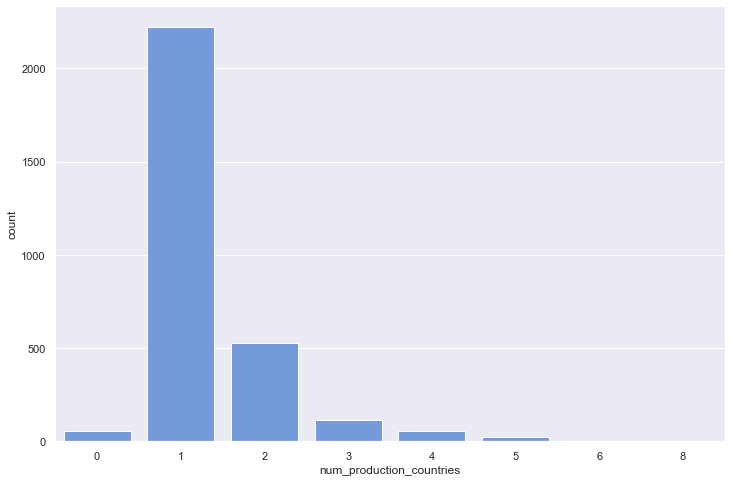

In [97]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x=train.num_production_countries, color='cornflowerblue')

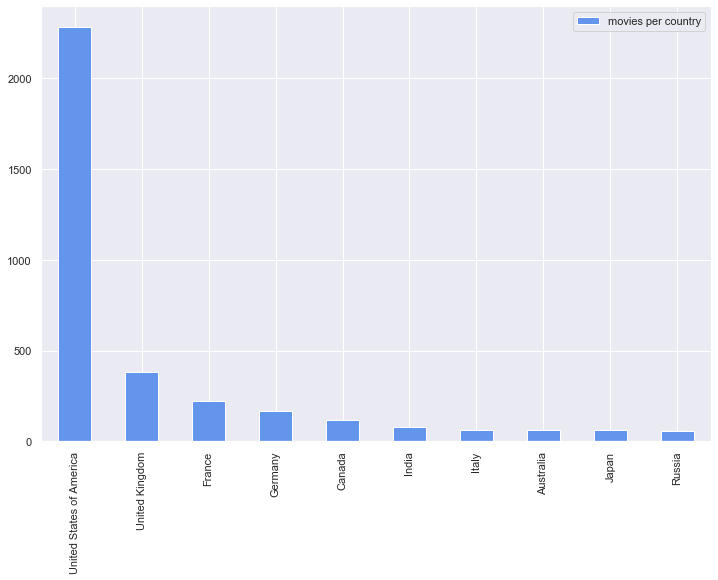

In [98]:
countriesDict = {}
for element in train["production_countries_processed"].values:
    for country in element:
        if country not in countriesDict:
            countriesDict[country] = 1
        else:
            countriesDict[country] += 1

countries_train = pd.DataFrame.from_dict(countriesDict, orient='index', columns=["movies per country"])
countries_train.sort_values(by="movies per country", ascending=False).head(10).plot.bar(color='cornflowerblue')


We can see from the plot that the overwhelming majority of films have the United States listed as a production country, with the second highest (United Kingdom) being incredibly far behind. Because of this observation, we will not look at all of the different production countries, but instead create a new column showing whether or not a film was produced in the United States

In [99]:
#Creating new feature
train['usa_produced'] = train.production_countries_processed.apply(lambda x: 1 if 'United States of America' in x else 0)
test['usa_produced'] = test.production_countries_processed.apply(lambda x: 1 if 'United States of America' in x else 0)
train['usa_produced'].value_counts()

1    2282
0     718
Name: usa_produced, dtype: int64

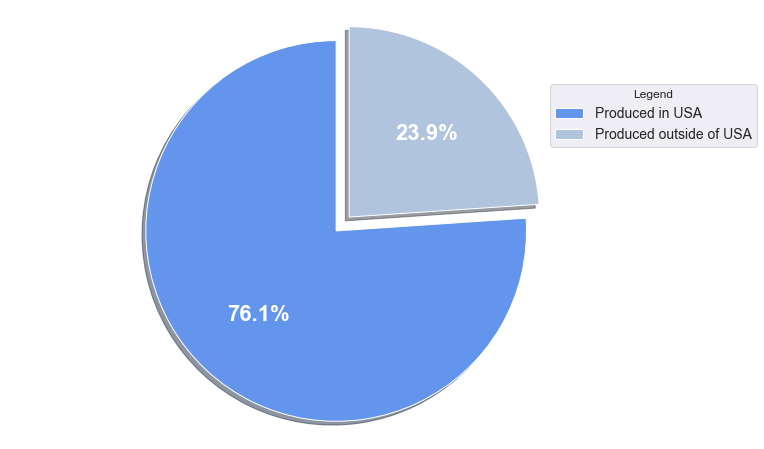

In [100]:
# plotting has a homepage data
labels = 'Produced in USA', 'Produced outside of USA'
btc_1 = [sum(train.usa_produced), (train.usa_produced == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['cornflowerblue', 'lightsteelblue']

fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

plt.show()                                        

#### Bivariate Analysis

Text(0.5, 1.0, 'Revenue based on number of production countries')

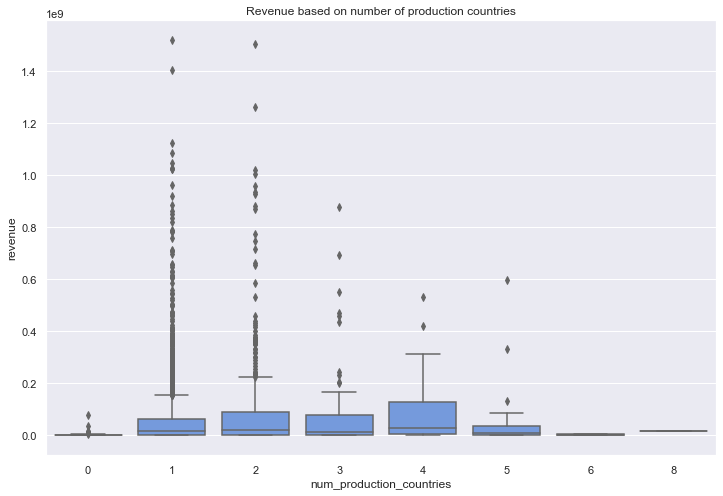

In [101]:
sns.boxplot(x='num_production_countries', y='revenue', data=train, color='cornflowerblue')
plt.title('Revenue based on number of production countries')

In [102]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['num_production_countries'], train['revenue'])
print('Pearsons correlation between num_production_countries and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_production_countries']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed num_production_countries and log transformed revenue: %.3f' % corr)

Pearsons correlation between num_production_countries and revenue: 0.053
Pearsons correlation between log transformed num_production_countries and log transformed revenue: 0.098


We can see there is virtually no correlation between the number of production countries and the revenue, but a relationship cannot be ruled out entirely yet

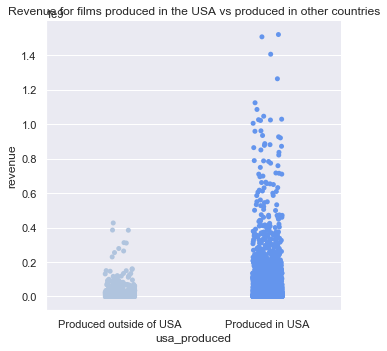

In [103]:
pal3 = ['lightsteelblue', 'cornflowerblue']

ax = sns.catplot(x='usa_produced', y='revenue', data=train, palette=pal3);
plt.title('Revenue for films produced in the USA vs produced in other countries');

labels = 'Produced outside of USA', 'Produced in USA'
ax.set_xticklabels(labels)

In [104]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['usa_produced'], train['revenue'])
print('Pearsons correlation between usa_produced and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['usa_produced']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed usa_produced and log transformed revenue: %.3f' % corr)

Pearsons correlation between usa_produced and revenue: 0.198
Pearsons correlation between log transformed usa_produced and log transformed revenue: 0.300


We observe a small positive correlation between our created feature and the revenue. While the correlation is not incredibly strong, it may be useful to include in our model.

In [105]:
log_features.append('num_production_countries')
train_features.append('usa_produced')

### Release Date

This column represents the date that the film was originally released in theaters. Things such as the time of year, day of week, season, etc can all be derived from the release data and all could matte for how well a movie is expected to do in theaters.

In [106]:
train['release_date'].head(10)

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
5      8/6/87
6     8/30/12
7     1/15/04
8     2/16/96
9     4/16/03
Name: release_date, dtype: object

The column appears to be standard formatted dates, but we will want to break this up a good bit to extract all of the information we want, so we start with some pre-processing

#### Pre-processing

In [107]:
# release date data manipulation
# naming a date-specific dataframe for housekeeping
train_date = train['release_date']

# converting to datetime format, with .dt used for accessing quantities
train_date = pd.to_datetime(train_date)
train_date.dt
print(train_date)

0      2015-02-20
1      2004-08-06
2      2014-10-10
3      2012-03-09
4      2009-02-05
          ...    
2995   1994-04-22
2996   2013-03-28
2997   1996-10-11
2998   2004-01-16
2999   2011-09-22
Name: release_date, Length: 3000, dtype: datetime64[ns]


In [108]:
# possible output options
print(train_date.dt.year) # absolutely necessary
print(train_date.dt.dayofweek) # friday night hits!
print(train_date.dt.dayofyear) # it's a christmas miracle
print(train_date.dt.weekofyear) # of interest

0       2015
1       2004
2       2014
3       2012
4       2009
        ... 
2995    1994
2996    2013
2997    1996
2998    2004
2999    2011
Name: release_date, Length: 3000, dtype: int64
0       4
1       4
2       4
3       4
4       3
       ..
2995    4
2996    3
2997    4
2998    4
2999    3
Name: release_date, Length: 3000, dtype: int64
0        51
1       219
2       283
3        69
4        36
       ... 
2995    112
2996     87
2997    285
2998     16
2999    265
Name: release_date, Length: 3000, dtype: int64
0        8
1       32
2       41
3       10
4        6
        ..
2995    16
2996    13
2997    41
2998     3
2999    38
Name: release_date, Length: 3000, dtype: int64


In [109]:
print(train.release_date.describe())
print()
print(train_date.dt.year.describe())

count        3000
unique       2398
top       9/10/15
freq            5
Name: release_date, dtype: object

count    3000.000000
mean     2004.779667
std        15.664767
min      1970.000000
25%      1995.000000
50%      2006.000000
75%      2012.000000
max      2069.000000
Name: release_date, dtype: float64


#### Univariate Analysis

Text(0.5, 1.0, 'Year of Release Date by Number of Films')

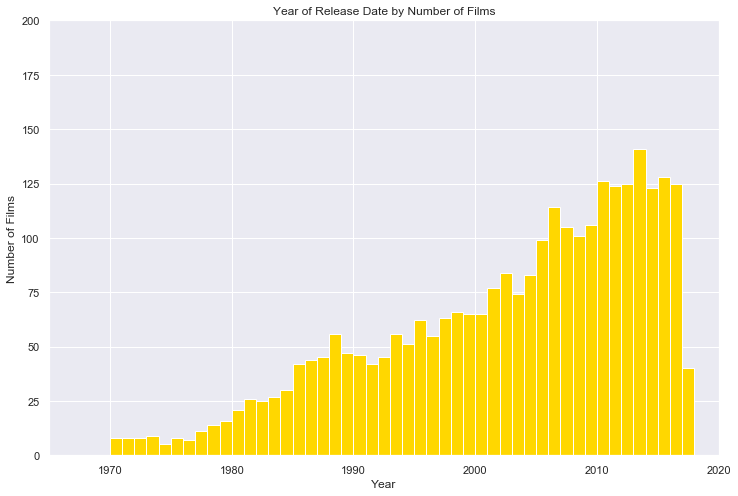

In [110]:
# plotting the year of the films release
fig, dx = plt.subplots()
sns.distplot(train_date.dt.year, bins=99, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12, 6)})

dx.set(xlim=(1965, 2020),ylim=(0,200))
dx.set_xlabel("Year")
dx.set_ylabel("Number of Films")
dx.set_title("Year of Release Date by Number of Films")

The plot for year of release for the dataset shows a general increase in number of films as time progresses, which makes sense for a growing/maturing industry. While mostly linear, there are several peaks throughout. Finding a relationship between the years with above average number films and revenue could be an interesting direction for investigation.

[Text(0, 0, ''),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday'),
 Text(0, 0, '')]

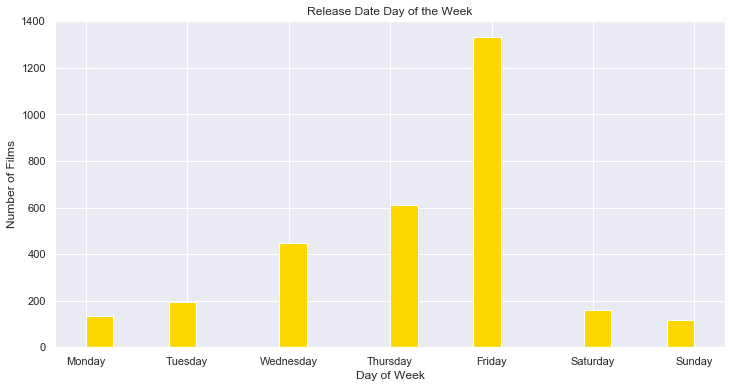

In [111]:
# plotting the films release day of the week
fig, ex = plt.subplots()
sns.distplot(train_date.dt.dayofweek, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Number of Films")
ex.set_title("Release Date Day of the Week")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[1] = 'Monday'
labels[2] = 'Tuesday'
labels[3] = 'Wednesday'
labels[4] = 'Thursday'
labels[5] = 'Friday'
labels[6] = 'Saturday'
labels[7] = 'Sunday'

ex.set_xticklabels(labels)

The dayofweek data shows a clear outlier in Friday release days, which is somewhat obviously tied to the end of the common Monday to Friday five day workweek. Individuals are more likely to attend a several hour long event after work if they have fewer responsibilities the following day. A movie's release is expected to follow market patterns that best benefit the film, so it is hypothesized that Friday release dates will have a positive impact on sales (and by association box office totals). Unexpectedly, Saturday release dates are lower even than Tuesday, Wednesday, and Thursday - it might be logical to assume many movie-goers would attend a film opening on Saturday.

Text(0.5, 1.0, 'Release Date Day of the Year')

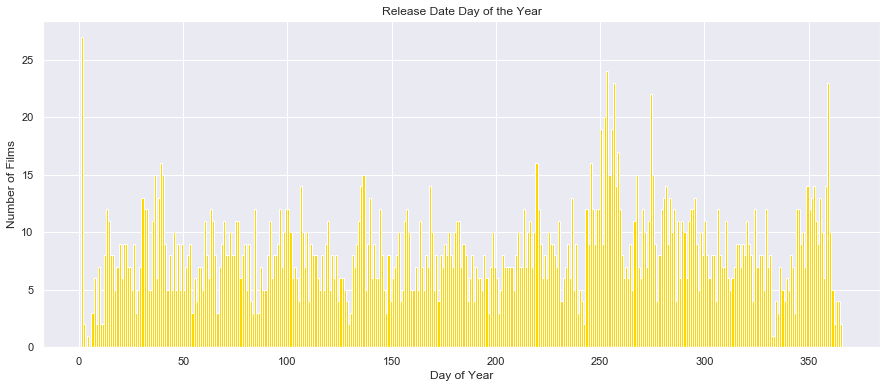

In [112]:
# plotting the films release day of the year
fig, fx = plt.subplots()
sns.distplot(train_date.dt.dayofyear, bins=365, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(15,6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Number of Films")
fx.set_title("Release Date Day of the Year")

The dayofyear data is a fairly noisy set of data, however as expected, there are certain days with notably higher numbers of films produced. For example, the Christmas Eve and New Years Day release dates are well-known as popular choices for when to release a movie. Whether this is an advent largely born out of tradition or out of true benefit to revenue will be parsed in later data exploration. 

There is also a clumping of films curiously released in September. Further research reveals that August and September are among the months listed as 'dump months' during which a large number of films that did bad in testing, star a less prominent cast, or otherwise cannot be easily marketted. This aligns with the return of children to the public school system after summer as well as other indicators of a slump period for the film industry. So high number of releases could be positive in some cases and negative in others. In fact, periods with low release may be due to a major title opening (with the studios wanting less box office competition).

Text(0.5, 1.0, 'Release Date Month of the Year')

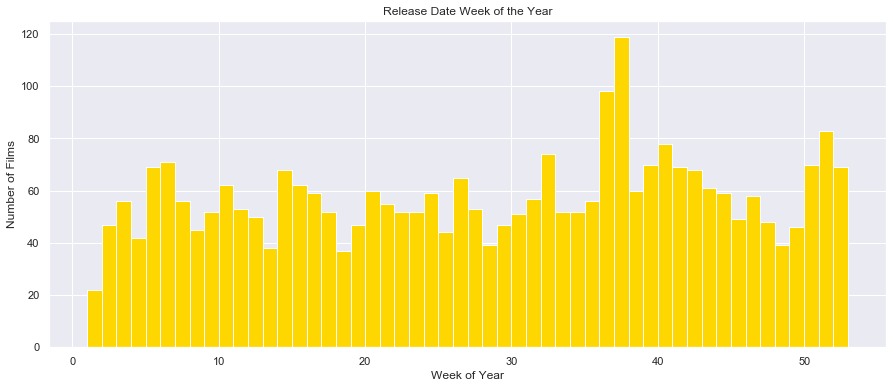

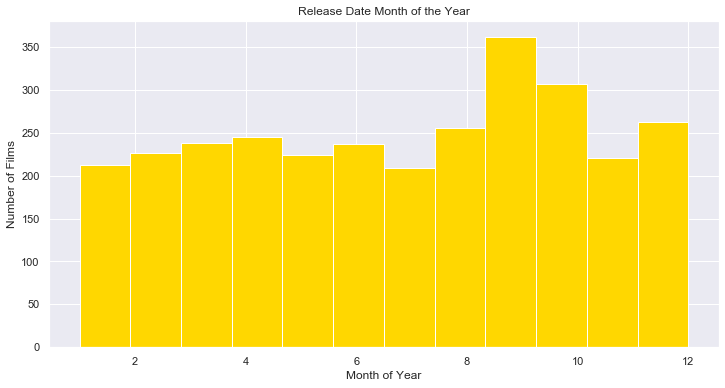

In [113]:
# plotting the films release week of the year
fig, gx = plt.subplots()
sns.distplot(train_date.dt.weekofyear, bins=52, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

gx.set_xlabel("Week of Year")
gx.set_ylabel("Number of Films")
gx.set_title("Release Date Week of the Year")

print()

# plotting the films release month of the year
fig, hx = plt.subplots()
sns.distplot(train_date.dt.month, bins=12, kde=False, color='gold', hist_kws=dict(alpha=1))
sns.set(rc={'figure.figsize':(12,6)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Number of Films")
hx.set_title("Release Date Month of the Year")

Similarly to the dayofyear data, the weekofyear data shows the highest number of films released at the end of August and beginning of September. As the 'dump months' this is unlikely to be indicative of a positive correlation with revenue. The second largest spike in December may have better box office totals due to the popularity of going to the movies over the holidays. Late Fall into Winter are typically denoted as the beginning of Oscar Season, which could mean higher grossing films released regardless of the overall number of film. As such, it can be theorized that the number of films released in a given week of the year is not as important as the characteristics of that week with respect to the film industry's cyclical patterns.

#### Bivariate Analysis

[Text(0, 0, '1970'),
 Text(0, 0, '1971'),
 Text(0, 0, '1972'),
 Text(0, 0, '1973'),
 Text(0, 0, '1974'),
 Text(0, 0, '1975'),
 Text(0, 0, '1976'),
 Text(0, 0, '1977'),
 Text(0, 0, '1978'),
 Text(0, 0, '1979'),
 Text(0, 0, '1980'),
 Text(0, 0, '1981'),
 Text(0, 0, '1982'),
 Text(0, 0, '1983'),
 Text(0, 0, '1984'),
 Text(0, 0, '1985'),
 Text(0, 0, '1986'),
 Text(0, 0, '1987'),
 Text(0, 0, '1988'),
 Text(0, 0, '1989'),
 Text(0, 0, '1990'),
 Text(0, 0, '1991'),
 Text(0, 0, '1992'),
 Text(0, 0, '1993'),
 Text(0, 0, '1994'),
 Text(0, 0, '1995'),
 Text(0, 0, '1996'),
 Text(0, 0, '1997'),
 Text(0, 0, '1998'),
 Text(0, 0, '1999'),
 Text(0, 0, '2000'),
 Text(0, 0, '2001'),
 Text(0, 0, '2002'),
 Text(0, 0, '2003'),
 Text(0, 0, '2004'),
 Text(0, 0, '2005'),
 Text(0, 0, '2006'),
 Text(0, 0, '2007'),
 Text(0, 0, '2008'),
 Text(0, 0, '2009'),
 Text(0, 0, '2010'),
 Text(0, 0, '2011'),
 Text(0, 0, '2012'),
 Text(0, 0, '2013'),
 Text(0, 0, '2014'),
 Text(0, 0, '2015'),
 Text(0, 0, '2016'),
 Text(0, 0, '2017'),
 Text(0, 0, '2021'),
 Text(0, 0, '2024'),
 Text(0, 0, '2025'),
 Text(0, 0, '2026'),
 Text(0, 0, '2027'),
 Text(0, 0, '2028'),
 Text(0, 0, '2030'),
 Text(0, 0, '2031'),
 Text(0, 0, '2032'),
 Text(0, 0, '2033'),
 Text(0, 0, '2035'),
 Text(0, 0, '2036'),
 Text(0, 0, '2038'),
 Text(0, 0, '2039'),
 Text(0, 0, '2040'),
 Text(0, 0, '2042'),
 Text(0, 0, '2043'),
 Text(0, 0, '2044'),
 Text(0, 0, '2045'),
 Text(0, 0, '2047'),
 Text(0, 0, '2048'),
 Text(0, 0, '2049'),
 Text(0, 0, '2050'),
 Text(0, 0, '2051'),
 Text(0, 0, '2052'),
 Text(0, 0, '2053'),
 Text(0, 0, '2054'),
 Text(0, 0, '2055'),
 Text(0, 0, '2056'),
 Text(0, 0, '2057'),
 Text(0, 0, '2058'),
 Text(0, 0, '2059'),
 Text(0, 0, '2060'),
 Text(0, 0, '2061'),
 Text(0, 0, '2062'),
 Text(0, 0, '2063'),
 Text(0, 0, '2064'),
 Text(0, 0, '2065'),
 Text(0, 0, '2066'),
 Text(0, 0, '2067'),
 Text(0, 0, '2068'),
 Text(0, 0, '2069')]

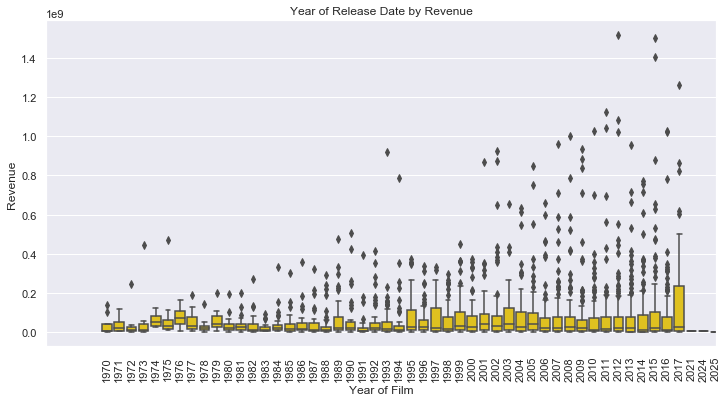

In [114]:
# bivariate year of release with revenue data
fig, dx = plt.subplots()
sns.boxplot(x=train_date.dt.year, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

dx.set(xlim=(-5, 50))
dx.set_xlabel("Year of Film")
dx.set_ylabel("Revenue")
dx.set_title("Year of Release Date by Revenue")

dx.set_xticklabels(dx.get_xticklabels(), rotation=90)

The revenue of films generally increases from year to year, with some notably higher years than others. The latest year in the dataset, 2017, has far an away the highest revenue in no small part because of Wonder Woman.

In [115]:
# bivariate day of week of release with revenue data
fig, ex = plt.subplots()
sns.boxplot(x=train_date.dt.dayofweek, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

ex.set_xlabel("Day of Week")
ex.set_ylabel("Revenue")
ex.set_title("Release Date Day of the Week by Revenue")

labels = [item.get_text() for item in ex.get_xticklabels()]
labels[0] = 'Monday'
labels[1] = 'Tuesday'
labels[2] = 'Wednesday'
labels[3] = 'Thursday'
labels[4] = 'Friday'
labels[5] = 'Saturday'
labels[6] = 'Sunday'

ex.set_xticklabels(labels)


[Text(0, 0, 'Monday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Friday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Sunday')]

Surprisingly, despite the hypothesis that Friday was the most common release date because of some monetary benefit to sales, Wednesday (followed by Tuesday & Thursday) has the highest revenue. It would be interesting to investigate why this is the case, but regardless it will help inform the outcome of the model.

Text(0.5, 1.0, 'Release Date Day of the Year by Revenue')

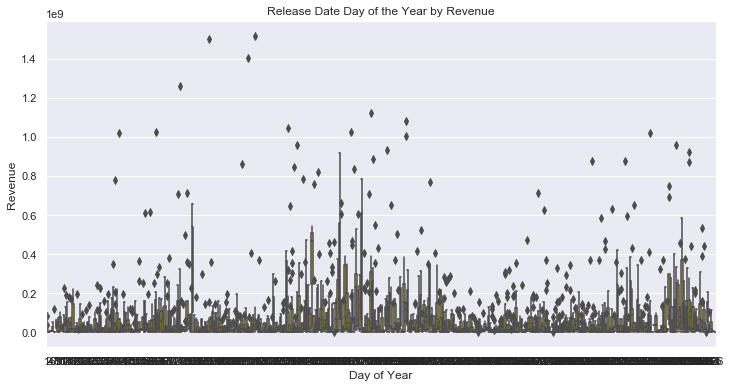

In [116]:
# bivariate day of year of release with revenue data
# WIP
fig, fx = plt.subplots()
sns.boxplot(x=train_date.dt.dayofyear, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

fx.set_xlabel("Day of Year")
fx.set_ylabel("Revenue")
fx.set_title("Release Date Day of the Year by Revenue")

The sheer amount of data is difficult to present in the same format as the other release_date by revenue bivariate analysis plots.

Text(0.5, 1.0, 'Release Date Week of the Year by Revenue')

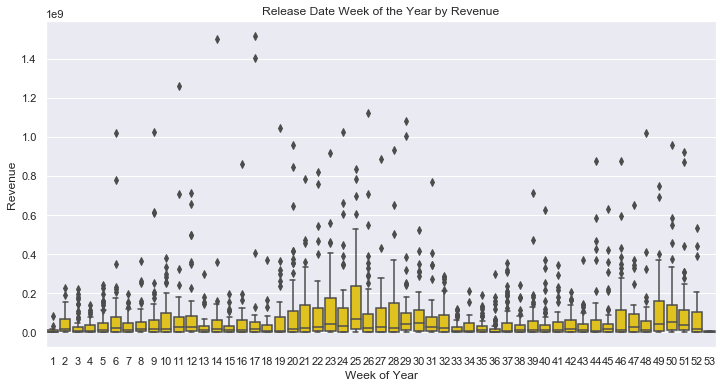

In [117]:
fig, gx = plt.subplots()
sns.boxplot(x=train_date.dt.weekofyear, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

gx.set_xlabel("Week of Year")
gx.set_ylabel("Revenue")
gx.set_title("Release Date Week of the Year by Revenue")

The revenue for weeks of the year match fairly well with the expected results from the univariate analysis, with the weeks preceding the holiday season having relatively high revenue. There is also a notable midsummer peak season in June (the 25th week of the year).

In [118]:
fig, hx = plt.subplots()
sns.boxplot(x=train_date.dt.month, y=train['revenue'], color='gold')
sns.set(rc={'figure.figsize':(12, 6)})

hx.set_xlabel("Month of Year")
hx.set_ylabel("Revenue")
hx.set_title("Release Date Month by Revenue")

Text(0.5, 1.0, 'Release Date Month by Revenue')

Similarly to above, the month of the year follows a similar trend. The midsummer months are successful, although not numerous in terms of release, while the 'dump months' during the start of the school year have a higher number of films and significantly lower revenue. The holiday season in December shows a higher number of releases and a concurrently higher revenue.

In [119]:
# fill possible NA values with the statistical mode
train["release_date"] = train["release_date"].fillna(train["release_date"].mode()[0])
test["release_date"] = test["release_date"].fillna(train["release_date"].mode()[0])

train['temp'] = train.release_date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
test['temp'] = test.release_date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

train["month"] = train.temp.apply(lambda x: x.month)
test["month"] = test.temp.apply(lambda x: x.month)

train["year"] = train.temp.apply(lambda x: x.year)
test["year"] = test.temp.apply(lambda x: x.year)

train["day_of_week"] = train.temp.apply(lambda x: x.weekday()+1)
test["day_of_week"] = test.temp.apply(lambda x: x.weekday()+1)

train["week_of_year"] = train.temp.apply(lambda x: x.isocalendar()[1])
test["week_of_year"] = test.temp.apply(lambda x: x.isocalendar()[1])


train = train.drop(['temp'], axis=1)
test = test.drop(['temp'], axis=1)


train["day_of_week"] = train["day_of_week"].fillna(train["day_of_week"].mode()[0])
test["day_of_week"] = test["day_of_week"].fillna(train["day_of_week"].mode()[0])

train["year"] = train["year"].fillna(train["year"].mode()[0])
test["year"] = test["year"].fillna(train["year"].mode()[0])

train["month"] = train["month"].fillna(train["month"].mode()[0])
test["month"] = test["month"].fillna(train["month"].mode()[0])

train["week_of_year"] = train["week_of_year"].fillna(train["week_of_year"].mode()[0])
test["week_of_year"] = test["week_of_year"].fillna(train["week_of_year"].mode()[0])


train[["release_date", "month", "year", "day_of_week", "week_of_year"]].head()

release_date  month  year  day_of_week  week_of_year
0      2/20/15      2  2015            5             8
1       8/6/04      8  2004            5            32
2     10/10/14     10  2014            5            41
3       3/9/12      3  2012            5            10
4       2/5/09      2  2009            4             6

In [120]:
corr, _ = pearsonr(train['year'], train['revenue'])
print('Pearsons correlation between year and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['year']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed year and log transformed revenue: %.3f' % corr)
print()

corr, _ = pearsonr(train['month'], train['revenue'])
print('Pearsons correlation between month and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['month']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed month and log transformed revenue: %.3f' % corr)
print()

corr, _ = pearsonr(train['week_of_year'], train['revenue'])
print('Pearsons correlation between week_of_year and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['week_of_year']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed week_of_year and log transformed revenue: %.3f' % corr)
print()


Pearsons correlation between year and revenue: 0.021
Pearsons correlation between log transformed year and log transformed revenue: -0.072

Pearsons correlation between month and revenue: 0.020
Pearsons correlation between log transformed month and log transformed revenue: 0.041

Pearsons correlation between week_of_year and revenue: 0.017
Pearsons correlation between log transformed week_of_year and log transformed revenue: 0.030



There appears to be very little correlation to revenue for any of our variables we extracted from the release date, however we will include them all in our model since we cannot rule out a releationship based off of the Pearson's correlation alone. Instead of using these variables as metrics, we should create some dummy variables to better represent the relevant apects of the release date. We can use these created columns of the broken up date to create some new variables. It does not make much sense to have the year as a continuous variable and log transform it, so would be better captured catwgorically, along with season and day of the week as well.

In [121]:
train.loc[train['year'].argmin(), ['title', 'year', 'revenue']]

title      The Wild Bunch
year                 1969
revenue            638641
Name: 228, dtype: object

Since the earliest movie in our dataset dates back to 1969, we will split up years into categories by decade, starting with the 1960s as we likely will no ever be predicting anything earlier

In [122]:
train['1960s'] = train.year.map(lambda x: 1 if (x >= 1960 and x <= 1969) else 0)
test['1960s'] = test.year.map(lambda x: 1 if (x >= 1960 and x <= 1969) else 0)

train['1970s'] = train.year.map(lambda x: 1 if (x >= 1970 and x <= 1979) else 0)
test['1970s'] = test.year.map(lambda x: 1 if (x >= 1970 and x <= 1979) else 0)

train['1980s'] = train.year.map(lambda x: 1 if (x >= 1980 and x <= 1989) else 0)
test['1980s'] = test.year.map(lambda x: 1 if (x >= 1980 and x <= 1989) else 0)

train['1990s'] = train.year.map(lambda x: 1 if (x >= 1990 and x <= 1999) else 0)
test['1990s'] = test.year.map(lambda x: 1 if (x >= 1990 and x <= 1999) else 0)

train['2000s'] = train.year.map(lambda x: 1 if (x >= 2000 and x <= 2009) else 0)
test['2000s'] = test.year.map(lambda x: 1 if (x >= 2000 and x <= 2009) else 0)

train['2010s'] = train.year.map(lambda x: 1 if (x >= 2010 and x <= 2019) else 0)
test['2010s'] = test.year.map(lambda x: 1 if (x >= 2010 and x <= 2019) else 0)

In [123]:
train['day_of_week'].value_counts()

5    1335
4     609
3     450
2     196
6     158
1     133
7     119
Name: day_of_week, dtype: int64

As we saw earlier, movies are most commonly released on Fridays, however this was not the highest revenue day of the week on average. So we can create a feature for each day of the week since they each may be useful in different ways to the model.

In [124]:
train['mondayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 1) else 0)
test['mondayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 1) else 0)

train['tuesdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 2) else 0)
test['tuesdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 2) else 0)

train['wednesdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 3) else 0)
test['wednesdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 3) else 0)

train['thursdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 4) else 0)
test['thursdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 4) else 0)

train['fridayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 5) else 0)
test['fridayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 5) else 0)

train['saturdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 6) else 0)
test['saturdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 6) else 0)

train['sundayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 7) else 0)
test['sundayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 7) else 0)

Seasons also play a major role in the movie industry. A lot of major blockbuster hits release in summer, so maybe this will be significant. We will break up movies by the season they are released in as features as well.

In [125]:
train['Winter'] = train.month.map(lambda x: 1 if (x == 12 or x <= 2) else 0)
test['Winter'] = test.month.map(lambda x: 1 if (x == 12 or x <= 2) else 0)

train['Fall'] = train.month.map(lambda x: 1 if (x >= 9 and x <= 11) else 0)
test['Fall'] = test.month.map(lambda x: 1 if (x >= 9 and x <= 11) else 0)

train['Spring'] = train.month.map(lambda x: 1 if (x >= 3 and x <= 5) else 0)
test['Spring'] = test.month.map(lambda x: 1 if (x >= 3 and x <= 5) else 0)

train['Summer'] = train.month.map(lambda x: 1 if (x >= 6 and x <= 8) else 0)
test['Summer'] = test.month.map(lambda x: 1 if (x >= 6 and x <= 8) else 0)

In [126]:
train_features.append('1960s')
train_features.append('1970s')
train_features.append('1980s')
train_features.append('1990s')
train_features.append('2000s')
train_features.append('2010s')
train_features.append('mondayRelease')
train_features.append('tuesdayRelease')
train_features.append('wednesdayRelease')
train_features.append('thursdayRelease')
train_features.append('fridayRelease')
train_features.append('saturdayRelease')
train_features.append('sundayRelease')
train_features.append('Winter')
train_features.append('Fall')
train_features.append('Spring')
train_features.append('Summer')

### Runtime

This column represents the runtime, or the duration/length, of the movie in minutes. The runtime could have an impact on revenue, as it is possible that movies that are deemed 'too short' or 'too long' may get less viewership. 

#### Univariate Analysis

In [127]:
#runtime
print('Movies missing a runtime:',train.runtime.isna().sum())

Movies missing a runtime: 2


In [128]:
#pre-processing
train.runtime = train.runtime.fillna(train.runtime.median())
test.runtime = test.runtime.fillna(test.runtime.median())

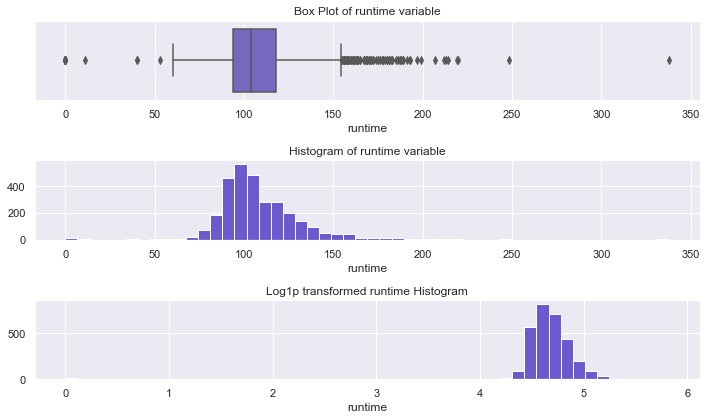

In [129]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.runtime, ax = ax[0], color='slateblue')
ax[0].set_title("Box Plot of runtime variable")
sns.distplot(a=train.runtime, kde = False, ax = ax[1], color='slateblue', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of runtime variable")
sns.distplot(a=np.log1p(train.runtime), kde = False, ax = ax[2], color='slateblue', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed runtime Histogram")
f.tight_layout()

The distribution of runtime looks pretty good, but we can see quite a few outliers to the right. Log transforming will help address these outliers, but there is one in particular that looks close to 350 minutes. We will check out this outlier specifically.

In [130]:
train.loc[train['runtime'].argmax(), ['title', 'runtime', 'revenue']]

title      Carlos
runtime       338
revenue    871279
Name: 1211, dtype: object

There is a movie titled 'Carlos' that runs for 338 minutes, which is over 5 and a half hours. This movie is absurdly long and did not even do particularly well in the box office, so it does not benefit our model in any way to keep this datapoint. We will drop this row.

In [131]:
train = train.drop(train['runtime'].argmax())

In [132]:
print('Movies with runtime listed as 0: ',(train.runtime == 0).sum())

Movies with runtime listed as 0:  12


There are 12 movies with the runtime listed as 0 in the dataset, which is also a clear error as no movie will have a true runtime of 0. We will replace these values the the median of the non-zero runtimes.

In [133]:
median = train.loc[train['runtime'] > 0, 'runtime'].median()
train["runtime_processed"] = train["runtime"].mask(train["runtime"] == 0, median)
test["runtime_processed"] = test["runtime"].mask(test["runtime"] == 0, median)

In [134]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.runtime_processed, ax = ax[0], color='slateblue')
ax[0].set_title("Box Plot of runtime_processed variable")
sns.distplot(a=train.runtime_processed, kde = False, ax = ax[1], color='slateblue', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of runtime_processed variable")
sns.distplot(a=np.log1p(train.runtime_processed), kde = False, ax = ax[2], color='slateblue', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed runtime_processed Histogram")
f.tight_layout()

The distribution looks even cleaner now, especially the log transformed distribution. This will be much better to work with.

#### Bivariate Analysis

In [135]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['runtime_processed'], train['revenue'], color='slateblue')
plt.title('Revenue vs runtime_processed');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['runtime_processed']), np.log1p(train['revenue']), color='slateblue')
plt.title('Log Revenue vs log runtime_processed');

In [136]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['runtime_processed'], train['revenue'])
print('Pearsons correlation: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['runtime_processed']), np.log1p(train['revenue']))
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.226
Pearsons correlation: 0.227


We observe a small positive correlation between the runtime and revenue of a film, so it will be useful to include in our model.

In [137]:
log_features.append('runtime_processed')

### Spoken Languages

This column represents all of the languages that a film is released in. We find this important because if a film is released in many different languages, it may reach greater audiences, therefore increasing revenue. The spoken languages could potentionally be an important variable, so let's explore it further. 

In [138]:
train['spoken_languages'].head(10)

0             [{'iso_639_1': 'en', 'name': 'English'}]
1             [{'iso_639_1': 'en', 'name': 'English'}]
2             [{'iso_639_1': 'en', 'name': 'English'}]
3    [{'iso_639_1': 'en', 'name': 'English'}, {'iso...
4             [{'iso_639_1': 'ko', 'name': '한국어/조선말'}]
5             [{'iso_639_1': 'en', 'name': 'English'}]
6             [{'iso_639_1': 'en', 'name': 'English'}]
7    [{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...
8             [{'iso_639_1': 'en', 'name': 'English'}]
9             [{'iso_639_1': 'en', 'name': 'English'}]
Name: spoken_languages, dtype: object

Once again, we have some messy data and will utilize the same regular expression in order to extract the languages.

In [139]:
# new column for a count of the number of spoken languages
train.spoken_languages = train.spoken_languages.fillna("")
train['spoken_languages_reform'] = train['spoken_languages'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))
train['num_languages'] = train.spoken_languages_reform.apply(lambda x: len(x))
print(train['num_languages'])


test.spoken_languages = test.spoken_languages.fillna("")
test['spoken_languages_reform'] = test['spoken_languages'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))
test['num_languages'] = test.spoken_languages_reform.apply(lambda x: len(x))
print(test['num_languages'])

0       1
1       1
2       1
3       2
4       1
       ..
2995    1
2996    1
2997    1
2998    1
2999    1
Name: num_languages, Length: 2999, dtype: int64
0       2
1       1
2       1
3       3
4       1
       ..
4393    5
4394    1
4395    1
4396    1
4397    1
Name: num_languages, Length: 4398, dtype: int64


In [140]:
print(train.num_languages.describe())

count    2999.000000
mean        1.440814
std         0.872691
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: num_languages, dtype: float64


#### Univariate Analysis

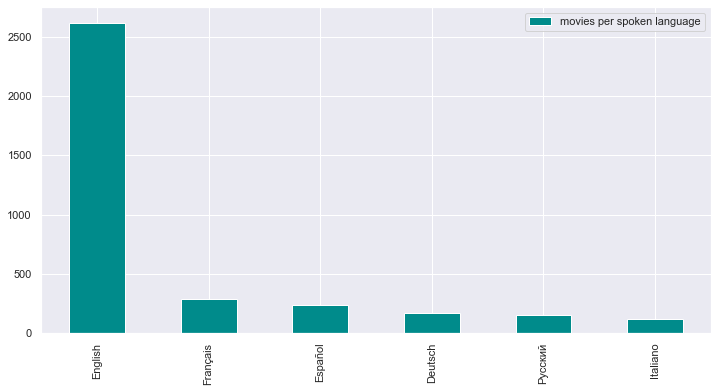

In [141]:
# univariate analysis of spoken languages
languagesDict = {}
for element in train["spoken_languages_reform"].values:
    for name in element:
        if name not in languagesDict:
            languagesDict[name] = 1
        else:
            languagesDict[name] += 1
            
sns.set(rc={'figure.figsize':(12,6)})
            
languages_train = pd.DataFrame.from_dict(languagesDict, orient='index', columns=["movies per spoken language"])
languages_train.sort_values(by="movies per spoken language", ascending=False).head(6).plot.bar(color='darkcyan')

languages_train.columns = ["number_of_languages"]

Due to the significantly higher value for films with English as the spoken language, this value can likely be broken down to a simple, "Is English a spoken language or not?" This will provide interesting insight into the importance of English as the spoken language as a factor toward the movie's success. Because of the higher market for movies in English speaking countries (save perhaps India - although it is unclear if an appropriately proportioned number of Bollywood films are included in the training data). A sound hypothesis would be that English may not denote a successful movie, but an absence of English may harm the film's chance for being as successful.

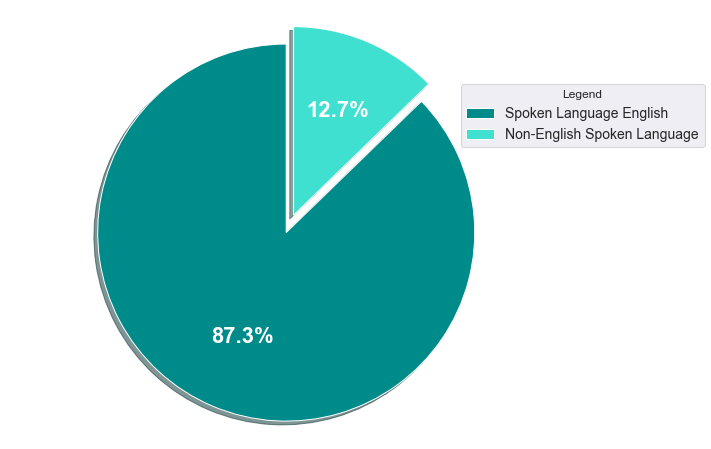

In [142]:
# spoken languages (english vs non-english)
train['released_in_english'] = train['spoken_languages_reform'].apply(lambda x: 1 if 'English' in x else 0)
test['released_in_english'] = test['spoken_languages_reform'].apply(lambda x: 1 if 'English' in x else 0)

lang = [(train.released_in_english == 1).sum(axis=0), (train.released_in_english == 0).sum(axis=0)]
lang_test = [(test.released_in_english == 1), (test.released_in_english == 0).sum(axis=0)]

labels = 'Spoken Language English', 'Non-English Spoken Language'
explode = (0.1, 0)

# plot
colors = ["darkcyan", "turquoise"]

fig, ix = plt.subplots(figsize=(10, 8))
ix.pie(lang, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize':22, 'weight':"bold"})
ix.axis('equal')

ix.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))


#### Bivariate Analysis

1    2617
0     382
Name: released_in_english, dtype: int64
1    3831
0     567
Name: released_in_english, dtype: int64


[Text(0, 0, 'Non-English Spoken Language'),
 Text(0, 0, 'Spoken Language English')]

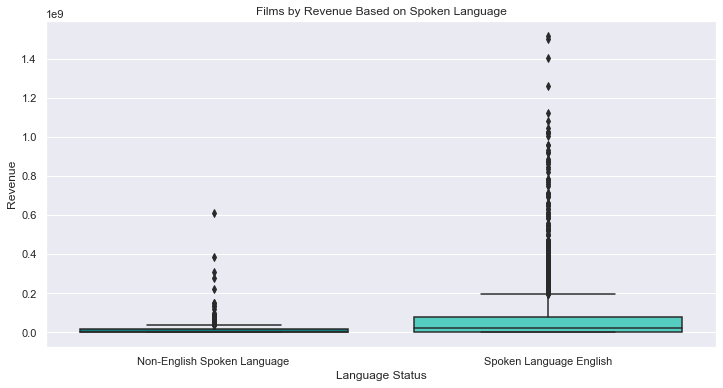

In [143]:
# bivariate analysis of revenue with english as spoken language
print(train['released_in_english'].value_counts())
print(test['released_in_english'].value_counts())

labels = 'Non-English Spoken Language', 'Spoken Language English'

pal2 = ["darkcyan", "turquoise"]

fig, ix = plt.subplots(figsize=(12, 6))
sns.boxplot(x='released_in_english', y='revenue', data=train, palette=pal2)
plt.title('Films by Revenue Based on Spoken Language')
plt.ylabel("Revenue")
plt.xlabel("Language Status")

ix.set_xticklabels(labels)

In [144]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['released_in_english'], train['revenue'])
print('Pearsons correlation between released_in_english and revenue: %.3f' % corr)
corr, _ = pearsonr(train['released_in_english'], np.log1p(train['revenue']))
print('Pearsons correlation between released_in_english and log transformed  revenue: %.3f' % corr)

Pearsons correlation between released_in_english and revenue: 0.135
Pearsons correlation between released_in_english and log transformed  revenue: 0.229


In [145]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_languages'], train['revenue'])
print('Pearsons correlation between num_languages and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_languages']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed num_languages and log transformed  revenue: %.3f' % corr)

Pearsons correlation between num_languages and revenue: 0.067
Pearsons correlation between log transformed num_languages and log transformed  revenue: 0.124


We observe fairly weak positive correlations between each of our two created variables and the revenue, but they still may be useful to include in the model

In [146]:
train_features.append('released_in_english')
log_features.append('num_languages')

### Status

In [147]:
#status
print(train.status.value_counts())

Released    2995
Rumored        4
Name: status, dtype: int64


All but 4 of the movies in the training set are released, so this variable is not very useful. Additionally, the goal of our model is to accurately predict box office success (revenue) regardless of if the movie is released or not. The model has use in predicting movies that have not released yet and will be trained on already released movies, therefore the release status is not useful and we will drop this column.

In [148]:
cols_to_drop.append('status')

### Tagline

This column contains the tagline of a movie, which is essentially the mantra or a short phrase meant to represent the film. The content of the tagline could be interesting to analyze but once again that is outside the scope of our project

In [149]:
train.tagline.head(10)

0    The Laws of Space and Time are About to be Vio...
1    It can take a lifetime to find true love; she'...
2      The road to greatness can take you to the edge.
3                                                  NaN
4                                                  NaN
5                                                  NaN
6                 Fear The Demon That Doesn't Fear God
7                Different channels. Different truths.
8                          Set sail for Muppet mayhem!
9             Back together for the first time, again.
Name: tagline, dtype: object

#### Univariate Analysis

In [150]:
print('Movies missing a tagline:', train.tagline.isna().sum())

Movies missing a tagline: 597


Since we will not be analyzing content,  we instead will simply check if the movie has a tagline or not

In [151]:
train['has_tagline'] = train.tagline.apply(lambda x: 1 if type(x) == str else 0)
test['has_tagline'] = test.tagline.apply(lambda x: 1 if type(x) == str else 0)

In [152]:
# plotting belongs to collection data
labels = 'Has Tagline', 'Does not have Tagline'
btc_1 = [(train.has_tagline == 1).sum(axis=0), (train.has_tagline == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['palevioletred', 'lightpink']

# plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

#### Bivariate Analysis

[Text(0, 0, 'Does not have tagline'), Text(0, 0, 'Has tagline')]

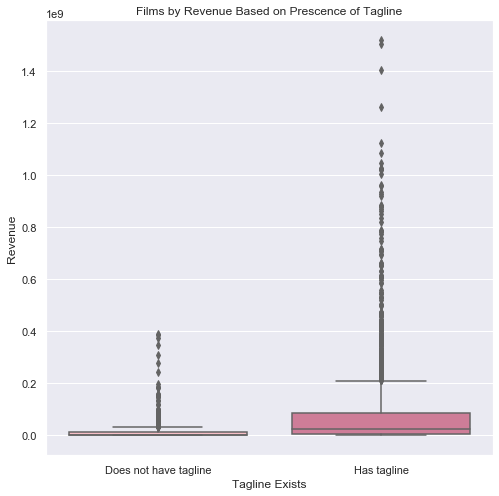

In [153]:
pal1 = ['lightpink', 'palevioletred']

sns.set(rc={'figure.figsize':(8, 8)})
ax = sns.boxplot(x='has_tagline', y='revenue', data=train, palette=pal1)
plt.title('Films by Revenue Based on Prescence of Tagline')
plt.ylabel("Revenue")
plt.xlabel("Tagline Exists")
labels = 'Does not have tagline', 'Has tagline'
ax.set_xticklabels(labels)

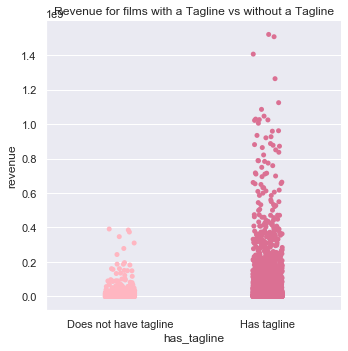

In [154]:
pal4 = ['lightpink', 'palevioletred']

ax = sns.catplot(x='has_tagline', y='revenue', data=train, palette=pal4);
plt.title('Revenue for films with a Tagline vs without a Tagline');

labels = 'Does not have tagline', 'Has tagline'
ax.set_xticklabels(labels)

In [155]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['has_tagline'], train['revenue'])
print('Pearsons correlation between has_tagline and revenue: %.3f' % corr)
corr, _ = pearsonr(train['has_tagline'], np.log1p(train['revenue']))
print('Pearsons correlation between has_tagline and log transformed revenue: %.3f' % corr)

Pearsons correlation between has_tagline and revenue: 0.180
Pearsons correlation between has_tagline and log transformed revenue: 0.320


We observe a positive correlation between the existence of a tagline and the revenue of a film

In [156]:
train_features.append('has_tagline')

### Title

This column has the title of a film and seems much more useful than the 'original title' column. While it could be fascinating the inspect the contents of titles, seeing if particular words have a correlation to revenue, we will be keeping it more simplified for this project.

#### Univariate Analysis

In [157]:
print('Movies missing a title:',train.title.isna().sum())

Movies missing a title: 0


In [158]:
train.title.fillna('')
test.title.fillna('')
train['title_len'] = train.title.apply(lambda x: len(str(x)))
test['title_len'] = test.title.apply(lambda x: len(str(x)))

We will just be looking at the length of the title, to see if this has any effect on a film's draw. Possibly shorter titles are easier to remember, making them perfrom better, or there is a chance that longer titles are more unique and compelling, making them pull more people in. Let's take a look at the data and see.

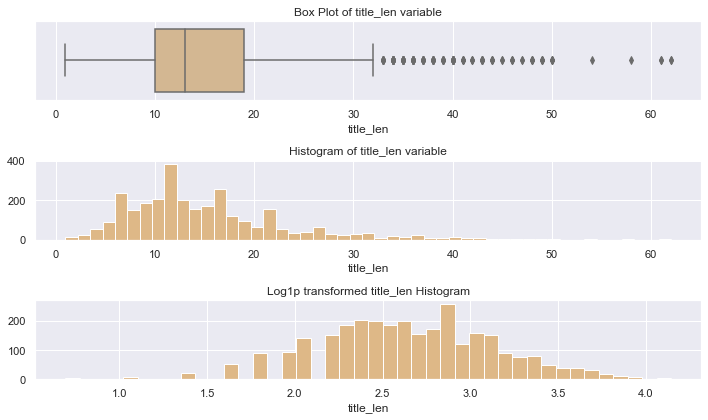

In [159]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.title_len, ax = ax[0], color='burlywood')
ax[0].set_title("Box Plot of title_len variable")
sns.distplot(a=train.title_len, kde = False, ax = ax[1], color='burlywood', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of title_len variable")
sns.distplot(a=np.log1p(train.title_len), kde = False, ax = ax[2], color='burlywood', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed title_len Histogram")
f.tight_layout()

#### Bivariate Analysis

In [160]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['title_len'], train['revenue'], color='burlywood')
plt.title('Revenue vs title_len');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['title_len']), np.log1p(train['revenue']), color='burlywood')
plt.title('Log Revenue vs log title_len');

In [161]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['title_len'], train['revenue'])
print('Pearsons correlation between title_len and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['title_len']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed title_len and log transformed revenue: %.3f' % corr)

Pearsons correlation between title_len and revenue: 0.110
Pearsons correlation between log transformed title_len and log transformed revenue: 0.022


We can see that there is very little correlation between the length of the title and the revenue for the film.

In [162]:
log_features.append('title_len')

### Keywords

The keywords column holds the keywords for a film, likely meant to be used as search terms of key concepts about the film to describe it. Once again, we will not be analyzing the words themselves, but instead just check for the precense of keywords. Since having keywords makes a movie more searchable and possible easier to find, maybe it will help more people discover the movie, leading to higher revenue.

In [163]:
train.Keywords.head(10)

0    [{'id': 4379, 'name': 'time travel'}, {'id': 9...
1    [{'id': 2505, 'name': 'coronation'}, {'id': 42...
2    [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
3    [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
4                                                  NaN
5                                                  NaN
6                                                  NaN
7    [{'id': 917, 'name': 'journalism'}, {'id': 163...
8    [{'id': 2041, 'name': 'island'}, {'id': 4418, ...
9    [{'id': 11800, 'name': 'mockumentary'}, {'id':...
Name: Keywords, dtype: object

#### Univariate Analysis

In [164]:
print('Movies missing keywords:', train.Keywords.isna().sum())

Movies missing keywords: 276


In [165]:
train['has_keywords'] = train.Keywords.apply(lambda x: 1 if type(x) == str else 0)
test['has_keywords'] = test.Keywords.apply(lambda x: 1 if type(x) == str else 0)

In [166]:
# plotting belongs to collection data
labels = 'Has Keywords', 'Does not have Keywords'
btc_1 = [sum(train.has_keywords), (train.has_keywords == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['seagreen', 'darkseagreen']

# plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
ax.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))


#### Bivariate Analysis

[Text(0, 0, 'Does not have keywords'), Text(0, 0, 'Has keywords')]

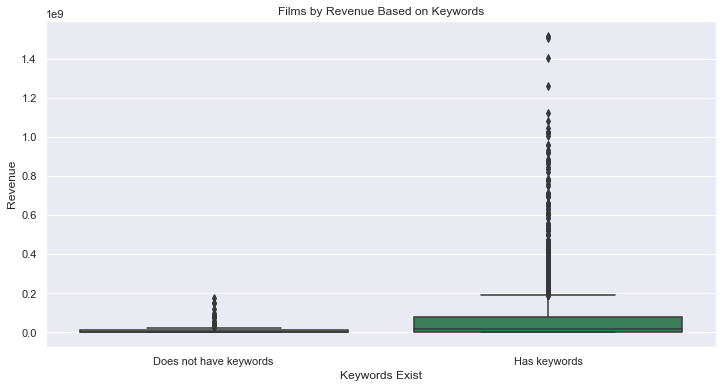

In [167]:
pal8 = ['darkseagreen', 'seagreen']

sns.set(rc={'figure.figsize':(12, 6)})
ax = sns.boxplot(x='has_keywords', y='revenue', data=train, palette=pal8)
plt.title('Films by Revenue Based on Keywords')
plt.ylabel("Revenue")
plt.xlabel("Keywords Exist")

labels = 'Does not have keywords', 'Has keywords'
ax.set_xticklabels(labels)

In [168]:
pal5 = ['darkseagreen', 'seagreen']

ax = sns.catplot(x='has_keywords', y='revenue', data=train, palette=pal5);
plt.title('Revenue for films with Keywords vs without Keywords');

labels = 'Does not have keywords', 'Has keywords'
ax.set_xticklabels(labels)

In [169]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['has_keywords'], train['revenue'])
print('Pearsons correlation between has_keywords and revenue: %.3f' % corr)
corr, _ = pearsonr(train['has_keywords'], np.log1p(train['revenue']))
print('Pearsons correlation between has_keywords and revenue: %.3f' % corr)

Pearsons correlation between has_keywords and revenue: 0.129
Pearsons correlation between has_keywords and revenue: 0.251


We observe a small positive correlation between the precense of keywords and the revenue of a film.

In [170]:
train_features.append('has_keywords')

### Cast 

The cast column has data on the entire cast of the movie. The cast includes all of the characters that appear in the film, and this variable is extremely important due to the fact that some actors/actresses have great repuations and their names alone can fill seats. We will explore this variable and determine a way to quantify the name power of the cast members.

In [171]:
train.cast.head(10)

0    [{'cast_id': 4, 'character': 'Lou', 'credit_id...
1    [{'cast_id': 1, 'character': 'Mia Thermopolis'...
2    [{'cast_id': 5, 'character': 'Andrew Neimann',...
3    [{'cast_id': 1, 'character': 'Vidya Bagchi', '...
4    [{'cast_id': 3, 'character': 'Chun-soo', 'cred...
5    [{'cast_id': 6, 'character': 'Pinocchio (voice...
6    [{'cast_id': 23, 'character': 'Clyde', 'credit...
7    [{'cast_id': 2, 'character': 'Himself', 'credi...
8    [{'cast_id': 1, 'character': 'Long John Silver...
9    [{'cast_id': 24, 'character': 'Jonathan Steinb...
Name: cast, dtype: object

Once again, the data is very messy and has plenty of excess information that is not useful to us. In order to work with this data, we will again utilize a regular expression to extract the names of the cast members.

#### Pre-processing

In [172]:
print('Movies missing a cast:',train.cast.isna().sum())

Movies missing a cast: 13


In [173]:
#pre-processing
train.cast = train.cast.fillna("")
train['cast_processed'] = train['cast'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))
test.cast = test.cast.fillna("")
test['cast_processed'] = test['cast'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

In [174]:
train['num_cast'] = train['cast_processed'].apply(lambda x: len(x))
test['num_cast'] = test['cast_processed'].apply(lambda x: len(x))
train['num_cast'].value_counts()

15     204
16     158
10     136
14     133
13     129
      ... 
104      1
102      1
98       1
94       1
124      1
Name: num_cast, Length: 105, dtype: int64

In [175]:
median = train.loc[train['num_cast']> 0, 'num_cast'].median()
train["num_cast"] = train["num_cast"].mask(train["num_cast"] == 0, median)
test["num_cast"] = test["num_cast"].mask(test["num_cast"] == 0, median)

#### Univariate Analysis

In [176]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.num_cast, ax = ax[0], color='darkslateblue')
ax[0].set_title("Box Plot of num_cast variable")
sns.distplot(a=train.num_cast, kde = False, ax = ax[1], color='darkslateblue', hist_kws=dict(alpha=1))
ax[1].set_title("Histogram of num_cast variable")
sns.distplot(a=np.log1p(train.num_cast), kde = False, ax = ax[2], color='darkslateblue', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed num_cast Histogram")
f.tight_layout()

The distribution of the number of cast in a film looks pretty good and is even better after a log transformation. Let's explore some deeper aspects involved with the cast variable.

In [177]:
actorsDict = {}
for element in train[["revenue", "cast_processed"]].values:
    
    for actor in element[1]:
        if actor not in actorsDict:
            actorsDict[actor] = [element[0], 1]
        else:
            actorsDict[actor][0] += element[0]
            actorsDict[actor][1] += 1    

actorsDict = {k: v for k, v in actorsDict.items() if v[1] >= 5}

for actor in actorsDict:
    actorsDict[actor][0] = actorsDict[actor][0]/actorsDict[actor][1]
    actorsDict[actor] = actorsDict[actor][0]


    
    
actors_train = pd.DataFrame.from_dict(actorsDict, orient='index', columns=["mean_movies_revenue"])
actors_train.sort_values(by="mean_movies_revenue", ascending=False).head(20).plot.bar(color='darkslateblue')

This is a plot of the top 20 actors based on average box office revenue. This list is not very reliable, as it factors in anyone in the cast, meaning cameos are factored in. As shown by the plot, Stan Lee is at the top of the list, however he never holds a significant role in movies, but is known for making a cameo in every Marvel movie (which tend to be quite successful), putting him above much more notable actors/actresses. We need to adjust this list to more accurately reflect the top actors, so we will try filering a bit.

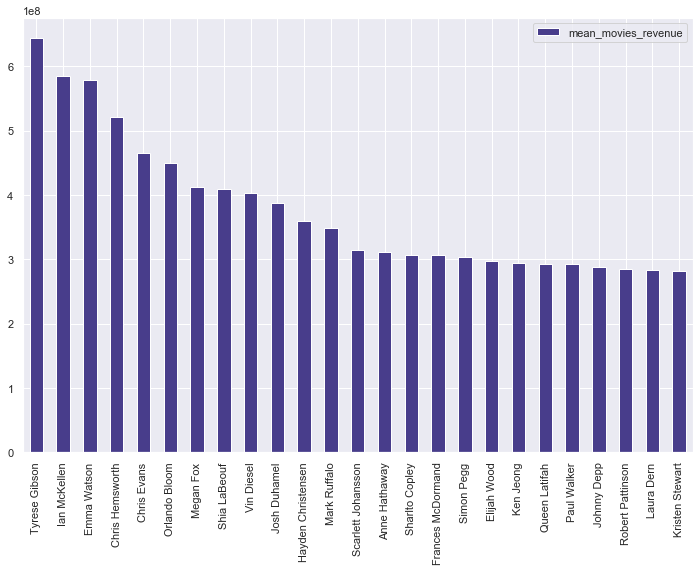

In [178]:
#cast

actorsDict = {}
for element in train[["revenue", "cast_processed"]].values:
   # compare results when looking at x top actors in films vs whole cast 
    temp = 5
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in actorsDict:
            actorsDict[element[1][i]] = [element[0], 1]
        else:
            actorsDict[element[1][i]][0] += element[0]
            actorsDict[element[1][i]][1] += 1    

actorsDict = {k: v for k, v in actorsDict.items() if v[1] >= 5}

for actor in actorsDict:
    actorsDict[actor][0] = actorsDict[actor][0]/actorsDict[actor][1]
    actorsDict[actor] = actorsDict[actor][0]


    
    
actors_train = pd.DataFrame.from_dict(actorsDict, orient='index', columns=["mean_movies_revenue"])
actors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='darkslateblue')

By limiting our list to only actors who have appeared in 5 or more films, we get much better results. There are some very well known names in this list however it also raises another issue. Tyrese Gibson is at the top of the list, who is known for starring in the Fast and Furious franchise. However, most would argue that Vin Diesel or Paul Walker are bigger faces of the franchise, so it is unclear if Gibson really deserves the top spot for these particular movies. This list is still important, but we will create an additional list only looking at the TOP actor listed for a film, being the leading role.

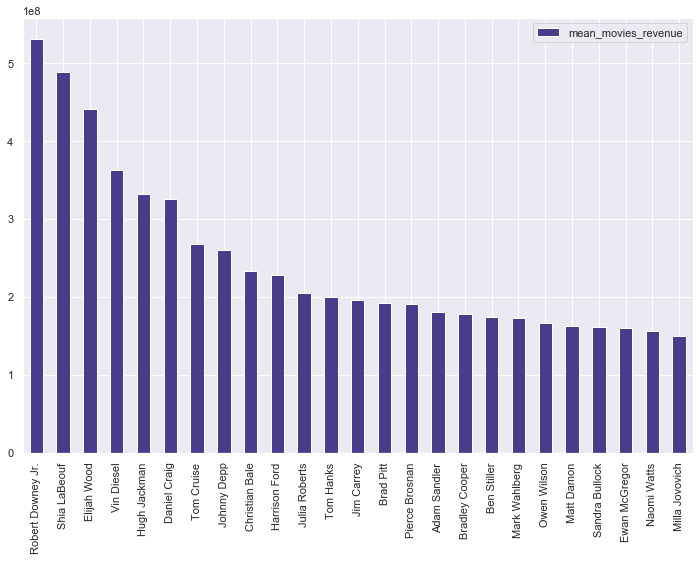

In [179]:
leadActorsDict = {}
for element in train[["revenue", "cast_processed"]].values:
   # compare results when looking at x top actors in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadActorsDict:
            leadActorsDict[element[1][i]] = [element[0], 1]
        else:
            leadActorsDict[element[1][i]][0] += element[0]
            leadActorsDict[element[1][i]][1] += 1 

leadActorsDict = {k: v for k, v in leadActorsDict.items() if v[1] >= 5}

for actor in leadActorsDict:
    leadActorsDict[actor][0] = leadActorsDict[actor][0]/leadActorsDict[actor][1]
    leadActorsDict[actor] = leadActorsDict[actor][0]


    
    
actors_train = pd.DataFrame.from_dict(leadActorsDict, orient='index', columns=["mean_movies_revenue"])
actors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='darkslateblue')


This is a plot of the top 50 actors as a LEAD actor, meaning the first one credited for a film. This could be a useful feature as these actors have proven success as a lead role. We can see in this list it is exclusively actors that are extremely well known and often the stars of big action movie hits. This will be useful in quantifying actor's reputation because these actors tend to be the star of major hits, so their precense in a movie may be a good indicator of success.

Because of how drastically different the results are depending on if you only look at the lead actor, compared to several of the lead actors, we will create a feature for each. 

The first feature will be a dummy variable representing simply whether or not the lead actor of the movie is a 'top lead actor'. The second feature will be a count of how many 'top actors' the movie has in it's cast, limiting to only the top 5 actors of the cast to only factor in significant roles and not cameos. 

We decided to classify a 'top actor' as an actor in the top 50 for the lead actor, and top 100 for all actors, ranked based on average box office revenue of past movies.

In [180]:
# Sort both of our dicts of actors and lead actors to more easily access the 'top actors'
leadActorsDict = {k: v for k, v in sorted(leadActorsDict.items(), key=lambda item: item[1], reverse = True)}
actorsDict = {k: v for k, v in sorted(actorsDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top actor'
def checkLeadActor(cast):
    if len(cast) < 1 or cast[0] not in list(leadActorsDict)[:50]:
        return 0
    else:
        return 1

def checkTopActors(cast):
    if len(cast) < 1:
        return 0
    count = 0
    for actor in cast[:10]:
        if actor in list(actorsDict)[:100]:
            count += 1
    return count

def getActorRanks(cast):
    if len(cast) < 1:
        return len(actorsDict)
    rank = 0
    for a in cast[:5]:
        if a in list(actorsDict):
            rank += list(actorsDict.keys()).index(a)
    if rank == 0:
        rank = len(actorsDict)
    return rank / len(cast)

def getTopActorRank(cast):
    if len(cast) < 1:
        return len(leadActorsDict)
    if cast[0] in list(leadActorsDict):
        rank = list(leadActorsDict.keys()).index(cast[0])
    else:
        rank = len(leadActorsDict)
    return rank

#Creating a feature for top LEAD actors
train['topLeadActor'] = train['cast_processed'].apply(lambda x: checkLeadActor(x))
test['topLeadActor'] = test['cast_processed'].apply(lambda x: checkLeadActor(x))
#Creating feature for number of top actors
train['numTopActors'] = train['cast_processed'].apply(lambda x: checkTopActors(x))
test['numTopActors'] = test['cast_processed'].apply(lambda x: checkTopActors(x))


train['actorRanks'] = train['cast_processed'].apply(lambda x: getActorRanks(x))
test['actorRanks'] = test['cast_processed'].apply(lambda x: getActorRanks(x))

train['topActorRank'] = train['cast_processed'].apply(lambda x: getTopActorRank(x))
test['topActorRank'] = test['cast_processed'].apply(lambda x: getTopActorRank(x))

print(train['topLeadActor'].value_counts())
print()
print(train['numTopActors'].value_counts())
print()
print(train['actorRanks'].value_counts())
print()
print(train['topActorRank'].value_counts())

0    2557
1     442
Name: topLeadActor, dtype: int64

0    2272
1     520
2     143
3      40
4      15
5       5
6       3
7       1
Name: numTopActors, dtype: int64

40.200000     63
67.000000     62
60.300000     57
75.375000     55
46.384615     45
              ..
1.315789       1
18.578947      1
93.333333      1
25.454545      1
105.700000     1
Name: actorRanks, Length: 1944, dtype: int64

116    2116
48       18
29       16
42       15
30       14
       ... 
54        5
52        5
46        5
73        5
75        5
Name: topActorRank, Length: 117, dtype: int64


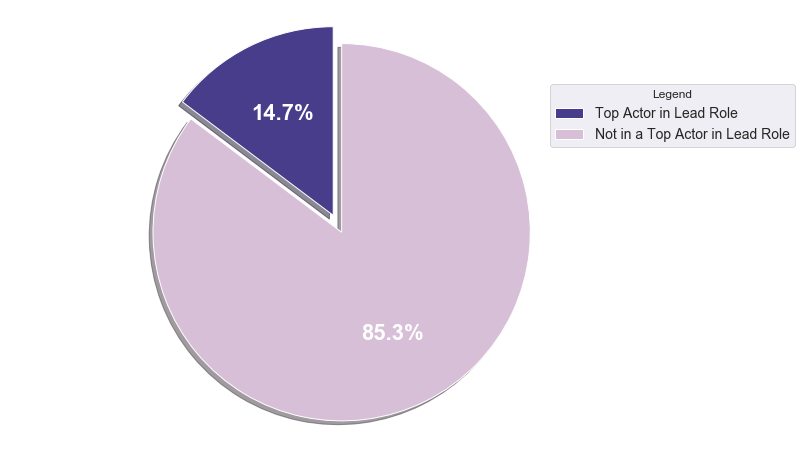

In [181]:
# plotting original data
labels = 'Top Actor in Lead Role', 'Not in a Top Actor in Lead Role'
btc_1 = [sum(train.topLeadActor), (train.topLeadActor == 0).sum(axis=0)]
explode = (0.1, 0)

colors = ['darkslateblue', 'thistle']

fig, ax = plt.subplots()
plt.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})
plt.axis('equal') # ensures chart is a circle

ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))


plt.show()

In [182]:
sns.set(rc={'figure.figsize':(12,8)})
sns.countplot(x=train.numTopActors, color='darkslateblue')

#### Bivariate Analysis

In [183]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'], color='darkslateblue')
plt.title('Revenue vs num_cast');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['num_cast']), np.log1p(train['revenue']), color='darkslateblue')
plt.title('Log Revenue vs log num_cast');

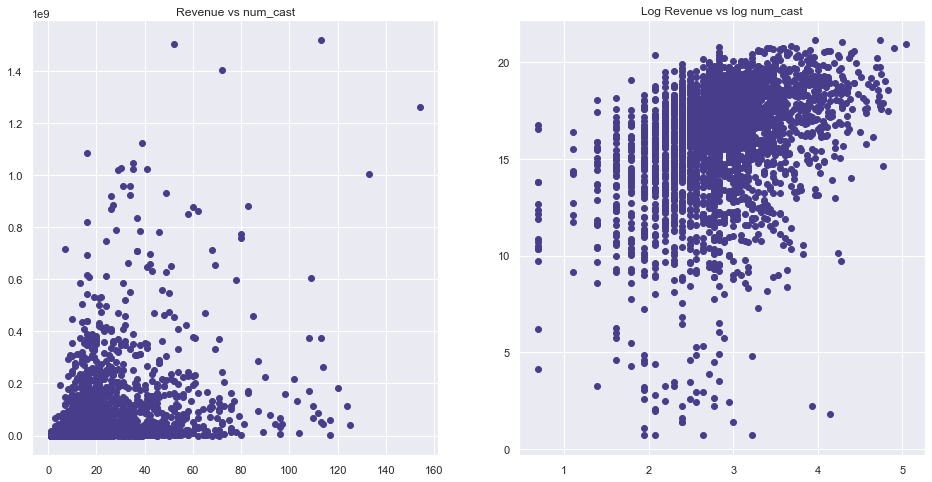

In [184]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['num_cast'], train['revenue'], color='darkslateblue')
plt.title('Revenue vs num_cast');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['num_cast']), np.log1p(train['revenue']), color='darkslateblue')
plt.title('Log Revenue vs log num_cast');

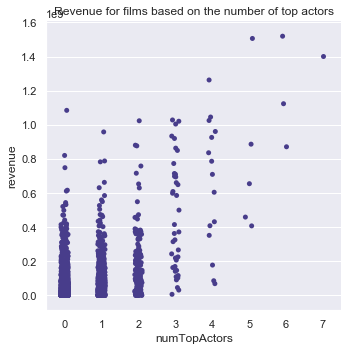

In [185]:
sns.catplot(x='numTopActors', y='revenue', data=train, color='darkslateblue');
plt.title('Revenue for films based on the number of top actors');

In [186]:
# calculate Pearson's correlation
corr, _ = pearsonr(train['num_cast'], train['revenue'])
print('Pearsons correlation between num_cast and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_cast']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed num_cast and  log transformed revenue: %.3f' % corr)
print()
corr, _ = pearsonr(train['topLeadActor'], train['revenue'])
print('Pearsons correlation between topLeadActor and revenue: %.3f' % corr)
corr, _ = pearsonr(train['topLeadActor'], np.log1p((train['revenue'])))
print('Pearsons correlation between topLeadActor and log transformed revenue: %.3f' % corr)
print()
corr, _ = pearsonr(train['numTopActors'], train['revenue'])
print('Pearsons correlation between numTopActors and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['numTopActors']), np.log1p((train['revenue'])))
print('Pearsons correlation between log transformed numTopActors and log transformed revenue: %.3f' % corr)
print()
corr, _ = pearsonr(train['actorRanks'], train['revenue'])
print('Pearsons correlation between actorRanks and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['actorRanks']), np.log1p((train['revenue'])))
print('Pearsons correlation between log transformed actorRanks and log transformed revenue: %.3f' % corr)
print()
corr, _ = pearsonr(train['topActorRank'], train['revenue'])
print('Pearsons correlation between topActorRank and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['topActorRank']), np.log1p((train['revenue'])))
print('Pearsons correlation between log transformed topActorRank and log transformed revenue: %.3f' % corr)

Pearsons correlation between num_cast and revenue: 0.345
Pearsons correlation between log transformed num_cast and  log transformed revenue: 0.377

Pearsons correlation between topLeadActor and revenue: 0.314
Pearsons correlation between topLeadActor and log transformed revenue: 0.277

Pearsons correlation between numTopActors and revenue: 0.578
Pearsons correlation between log transformed numTopActors and log transformed revenue: 0.317

Pearsons correlation between actorRanks and revenue: -0.115
Pearsons correlation between log transformed actorRanks and log transformed revenue: -0.337

Pearsons correlation between topActorRank and revenue: -0.323
Pearsons correlation between log transformed topActorRank and log transformed revenue: -0.289


We can see decent positive correlations between each of our created variables and the revenue of the movie. The most strongly correlated is the number of top actors in a film, which makes sense because if a movie has several big name stars in the cast, then the movie is likely to perform well based on the cast alone. All of these will be included in our model

In [187]:
log_features.append('num_cast')
train_features.append('topLeadActor')
log_features.append('numTopActors')
log_features.append('actorRanks')
log_features.append('topActorRank')

### Crew

This column holds all of the information on the crew that worked on each film. The crew includes many different roles that work together to create a movie, including directors, producers, the makeup department, visual effects, composers, and many more. While some roles, such as directors, have some much more well known names, it will be interesting to explore several of the roles and assess the impact of the different roles.

In [188]:
train.crew.head(10)

0    [{'credit_id': '59ac067c92514107af02c8c8', 'de...
1    [{'credit_id': '52fe43fe9251416c7502563d', 'de...
2    [{'credit_id': '54d5356ec3a3683ba0000039', 'de...
3    [{'credit_id': '52fe48779251416c9108d6eb', 'de...
4    [{'credit_id': '52fe464b9251416c75073b43', 'de...
5    [{'credit_id': '52fe46f49251416c9106558b', 'de...
6    [{'credit_id': '52fe4981c3a368484e12ee29', 'de...
7    [{'credit_id': '52fe47a69251416c750a0daf', 'de...
8    [{'credit_id': '52fe43c89251416c7501deb3', 'de...
9    [{'credit_id': '52fe45609251416c750545b3', 'de...
Name: crew, dtype: object

The crew is also similarly messy as we've seen in several other categories, so we will need to pre-process it in order to work with it and analyze it. The crew is a bit different, however, in the sense that we will be extracting specific roles from the crew data, but to look at the general crew data and get counts of crew memebers, we will just extract all names and ignore roles.

#### Pre-processing

In [189]:
# pre-processing
train.crew = train.crew.fillna("")
test.crew = test.crew.fillna("")
train['crew_processed'] = train['crew'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

In [190]:
train.crew_processed.head(10)

0    [Kelly Cantley, Steve Pink, Josh Heald, Josh H...
1    [Garry Marshall, Charles Minsky, John Debney, ...
2    [Terri Taylor, Richard Henderson, Jeffrey Stot...
3              [Sujoy Ghosh, Sujoy Ghosh, Sujoy Ghosh]
4                     [Jong-seok Yoon, Jong-seok Yoon]
5    [Collodi, Hal Sutherland, Robby London, Robby ...
6    [Sam Raimi, Nancy Nayor, Anders Villadsen, Eri...
7                                     [Jehane Noujaim]
8    [Brian Henson, Frank Oz, Brian Henson, Jerry J...
9    [Christopher Guest, Christopher Guest, Eugene ...
Name: crew_processed, dtype: object

#### Univariate Analysis

Since there are so many unique roles that deserve individual analysis, we will start by looking at the crew holistically, then explore more of the roles a bit deeper.

#### General Crew Features

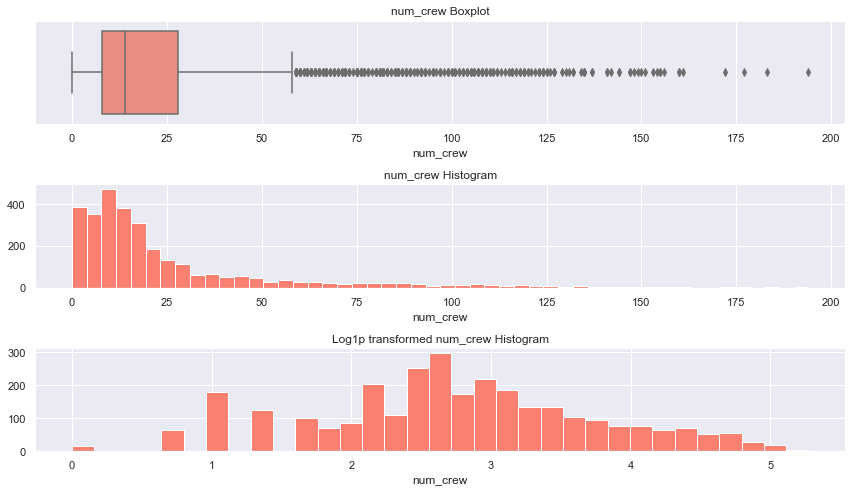

In [191]:
# new feature for a count of the number of crew
train['crew']= train['crew'].fillna("")
train["num_crew"] = train["crew"].str.count("'job")

test['crew']= test['crew'].fillna("")
test["num_crew"] = test["crew"].str.count("'job")

f, ax = plt.subplots(3, figsize=(12,7))

# plot
sns.boxplot(x=train.num_crew, ax = ax[0], color='salmon')
ax[0].set_title("num_crew Boxplot")

sns.distplot(a=train.num_crew, kde = False, ax = ax[1], color='salmon', hist_kws=dict(alpha=1))
ax[1].set_title("num_crew Histogram")

sns.distplot(a=np.log1p(train.num_crew), kde = False, ax = ax[2], color='salmon', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed num_crew Histogram")

f.tight_layout()


In [192]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_crew'], train['revenue'])
print('Pearsons correlation between num_crew and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_crew']), np.log1p(train['revenue']))
print('Pearsons correlation between num_crew and revenue: %.3f' % corr)

Pearsons correlation between num_crew and revenue: 0.372
Pearsons correlation between num_crew and revenue: 0.385


In [193]:
log_features.append('num_crew')

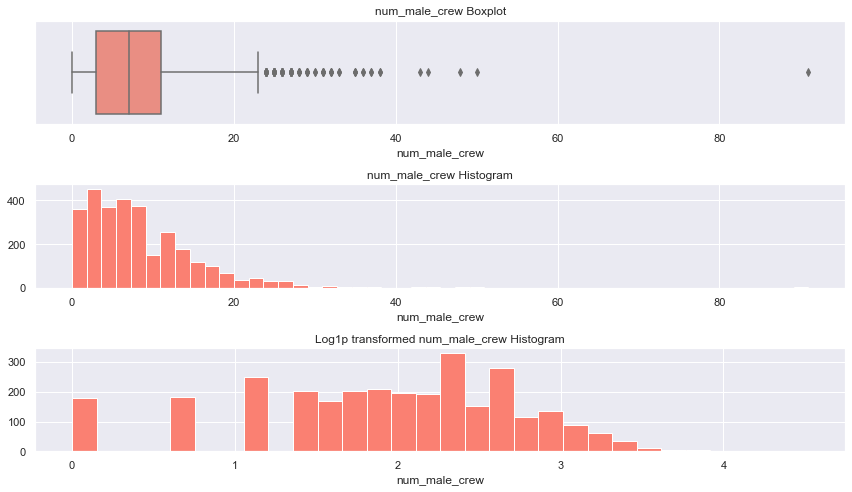

In [194]:
# male crew
train["num_male_crew"] = train["crew"].str.count("'gender': 2")
test["num_male_crew"] = test["crew"].str.count("'gender': 2")

f, ax = plt.subplots(3, figsize=(12,7))

train.num_male_crew = train.num_male_crew.fillna(0)
test.num_male_crew = test.num_male_crew.fillna(0)

# plot
sns.boxplot(x=train.num_male_crew, ax = ax[0], color='salmon')
ax[0].set_title("num_male_crew Boxplot")

sns.distplot(a=train.num_male_crew, kde = False, ax = ax[1], color='salmon', hist_kws=dict(alpha=1))
ax[1].set_title("num_male_crew Histogram")

sns.distplot(a=np.log1p(train.num_male_crew), kde = False, ax = ax[2], color='salmon', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed num_male_crew Histogram")

f.tight_layout()


In [195]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_male_crew'], train['revenue'])
print('Pearsons correlation between num_male_crew and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_male_crew']), np.log1p(train['revenue']))
print('Pearsons correlation between num_male_crew and revenue: %.3f' % corr)

Pearsons correlation between num_male_crew and revenue: 0.383
Pearsons correlation between num_male_crew and revenue: 0.462


In [196]:
log_features.append('num_male_crew')

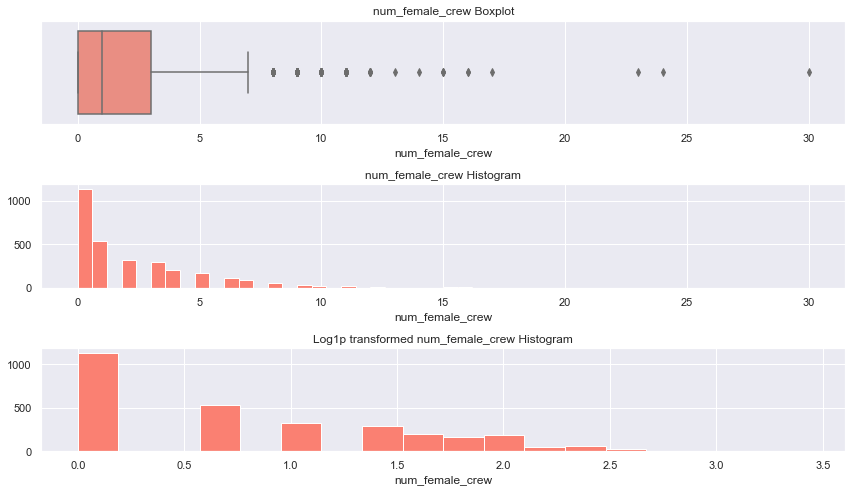

In [197]:
# female crew
train["num_female_crew"] = train["crew"].str.count("'gender': 1")
test["num_female_crew"] = test["crew"].str.count("'gender': 1")

f, ax = plt.subplots(3, figsize=(12,7))

train.num_female_crew = train.num_female_crew.fillna(0)
test.num_female_crew = test.num_female_crew.fillna(0)

# plot
sns.boxplot(x=train.num_female_crew, ax = ax[0], color='salmon')
ax[0].set_title("num_female_crew Boxplot")

sns.distplot(a=train.num_female_crew, kde = False, ax = ax[1], color='salmon', hist_kws=dict(alpha=1))
ax[1].set_title("num_female_crew Histogram")

sns.distplot(a=np.log1p(train.num_female_crew), kde = False, ax = ax[2], color='salmon', hist_kws=dict(alpha=1))
ax[2].set_title("Log1p transformed num_female_crew Histogram")

f.tight_layout()


In [198]:
#analysis of correlation and create log feature
corr, _ = pearsonr(train['num_female_crew'], train['revenue'])
print('Pearsons correlation between num_female_crew and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_female_crew']), np.log1p(train['revenue']))
print('Pearsons correlation between num_female_crew and revenue: %.3f' % corr)

Pearsons correlation between num_female_crew and revenue: 0.267
Pearsons correlation between num_female_crew and revenue: 0.348


In [199]:
log_features.append('num_female_crew')

#### Bivariate Analysis

Now for the bivariate analysis, we will dive into several of the different roles that make up the crew. We use the same methodology we used for the actors as a way to quantify repuation. For several of the roles we deemed as the most significant, we created dictionaries and sorted based on revenue, and effectively formed a list of the most successful people in each domain. We then created 2 features based on each of the roles, the same as what was done for cast and production studios.

#### Specific Crew Features by Revenue

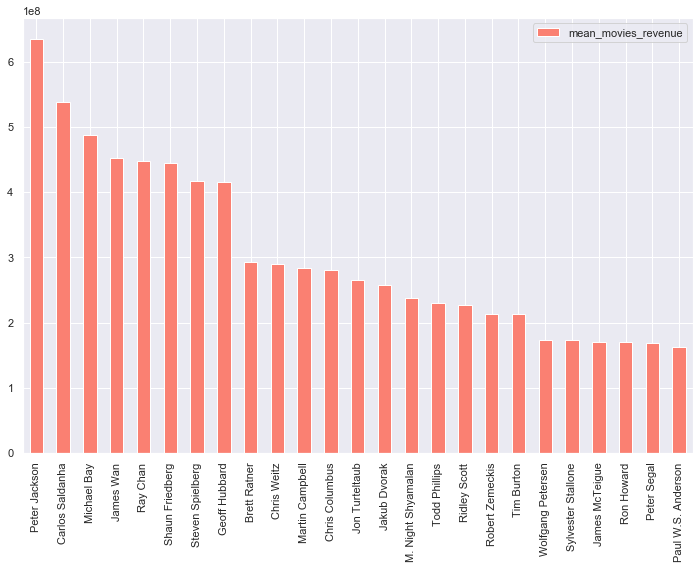

In [200]:
# bivariate directors
train['directors'] = train['crew'].apply(lambda x: re.findall("Director', 'name': '(.+?)'", x))
test['directors'] = test['crew'].apply(lambda x: re.findall("Director', 'name': '(.+?)'", x))

directorsDict = {}
for element in train[["revenue", "directors"]].values:

    for director in element[1]:
        if director not in directorsDict:
            directorsDict[director] = [element[0], 1]
        else:
            directorsDict[director][0] += element[0]
            directorsDict[director][1] += 1

directorsDict = {k: v for k, v in directorsDict.items() if v[1] >= 5}

for director in directorsDict:
    directorsDict[director][0] = directorsDict[director][0]/directorsDict[director][1]
    directorsDict[director] = directorsDict[director][0]

    
directors_train = pd.DataFrame.from_dict(directorsDict, orient='index', columns=["mean_movies_revenue"])
directors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

directors_train.columns = ["number_of_directors"]

The plot above shows the top 25 directors by mean revenue for all of the movies they have produced. Because of the goal of the project to predict box office totals for an unknown example, ranking directors in order of their box office success will allow us to create a feature indicative of whether a top director is associated with a movie or not. Given that these directors are the more influential toward revenue in the training set of data, denoting their presence in test data should be a good predictor of future success. This obviously doesn't account for flubs. Botched films can come from great directors, but are likely outliers more than the norm. It is hypothesized that more successful directors with respect to revenue will be an influential factor in predicting the success of their future film projects.

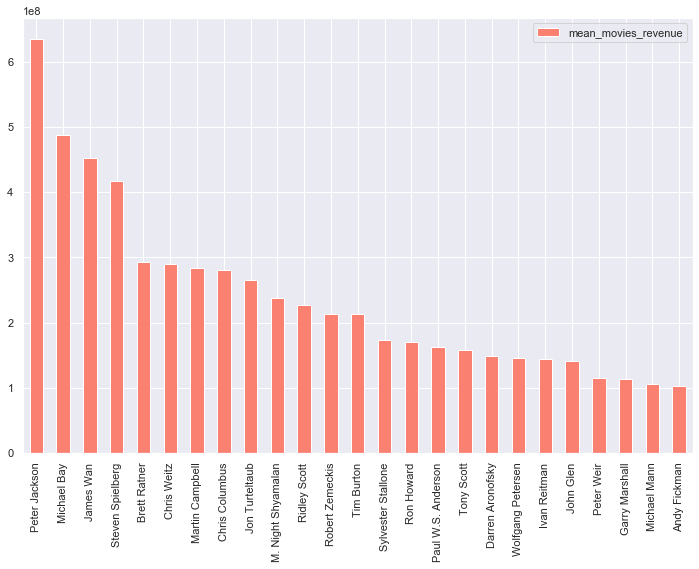

In [201]:
leadDirectorsDict = {}
for element in train[["revenue", "directors"]].values:
   # compare results when looking at x top directors in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadDirectorsDict:
            leadDirectorsDict[element[1][i]] = [element[0], 1]
        else:
            leadDirectorsDict[element[1][i]][0] += element[0]
            leadDirectorsDict[element[1][i]][1] += 1    

leadDirectorsDict = {k: v for k, v in leadDirectorsDict.items() if v[1] >= 5}

for director in leadDirectorsDict:
    leadDirectorsDict[director][0] = leadDirectorsDict[director][0]/leadDirectorsDict[director][1]
    leadDirectorsDict[director] = leadDirectorsDict[director][0]


    
    
directors_train = pd.DataFrame.from_dict(leadDirectorsDict, orient='index', columns=["mean_movies_revenue"])
directors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [202]:
# Sort both of our dicts
leadDirectorsDict = {k: v for k, v in sorted(leadDirectorsDict.items(), key=lambda item: item[1], reverse = True)}
directorsDict = {k: v for k, v in sorted(directorsDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top director'
def checkLeadDirector(crew):
    if len(crew) < 1 or crew[0] not in list(leadDirectorsDict)[:25]:
        return 0
    else:
        return 1

def checkTopDirectors(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for director in crew[:5]:
        if director in list(directorsDict)[:100]:
            count += 1
    return count

def getDirectorRank(crew):
    if len(crew) < 1:
        return len(directorsDict)
    rank = 0
    for c in crew[:5]:
        if c in list(directorsDict):
            rank += list(directorsDict.keys()).index(c)
    if rank == 0:
        rank = len(directorsDict)
    return rank / len(crew)

#Creating a feature for top LEAD directors
train['topLeadDirector'] = train['directors'].apply(lambda x: checkLeadDirector(x))
test['topLeadDirector'] = test['directors'].apply(lambda x: checkLeadDirector(x))

#Creating feature for number of top directors
train['numTopDirectors'] = train['directors'].apply(lambda x: checkTopDirectors(x))
test['numTopDirectors'] = test['directors'].apply(lambda x: checkTopDirectors(x))

train['directorsRank'] = train['directors'].apply(lambda x: getDirectorRank(x))
test['directorsRank'] = test['directors'].apply(lambda x: getDirectorRank(x))


print(train['topLeadDirector'].value_counts())
print()
print(train['numTopDirectors'].value_counts())
print()
print(train['directorsRank'].value_counts())

0    2847
1     152
Name: topLeadDirector, dtype: int64

0    2499
1     489
2      10
3       1
Name: numTopDirectors, dtype: int64

86.000000    1927
43.000000     295
28.666667     134
21.500000      72
17.200000      41
             ... 
2.666667        1
2.866667        1
1.700000        1
2.285714        1
13.400000       1
Name: directorsRank, Length: 171, dtype: int64


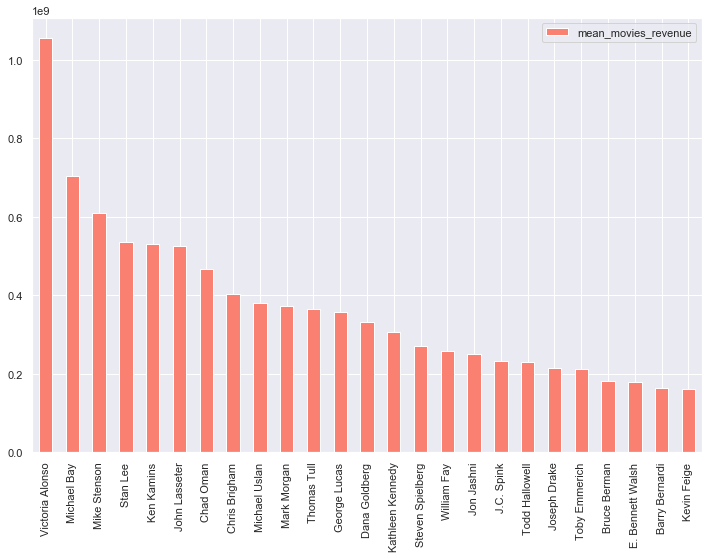

In [203]:
# bivariate executive producers
train['exec_producers'] = train['crew'].apply(lambda x: re.findall("Executive Producer', 'name': '(.+?)'", x))
test['exec_producers'] = test['crew'].apply(lambda x: re.findall("Executive Producer', 'name': '(.+?)'", x))

exec_producersDict = {}
for element in train[["revenue", "exec_producers"]].values:

    for exec_producer in element[1]:
        if exec_producer not in exec_producersDict:
            exec_producersDict[exec_producer] = [element[0], 1]
        else:
            exec_producersDict[exec_producer][0] += element[0]
            exec_producersDict[exec_producer][1] += 1

exec_producersDict = {k: v for k, v in exec_producersDict.items() if v[1] >= 5}

for exec_producer in exec_producersDict:
    exec_producersDict[exec_producer][0] = exec_producersDict[exec_producer][0]/exec_producersDict[exec_producer][1]
    exec_producersDict[exec_producer] = exec_producersDict[exec_producer][0]




exec_producers_train = pd.DataFrame.from_dict(exec_producersDict, orient='index', columns=["mean_movies_revenue"])
exec_producers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

Similarly to the top directors by revenue, the top executive producers by revenue should be a good feature for determining the future success of a film with the same crew. Executive producers are merely another important instance of analyzing the impact of crew members on predicting box office totals. This can be done with any category of crew member.

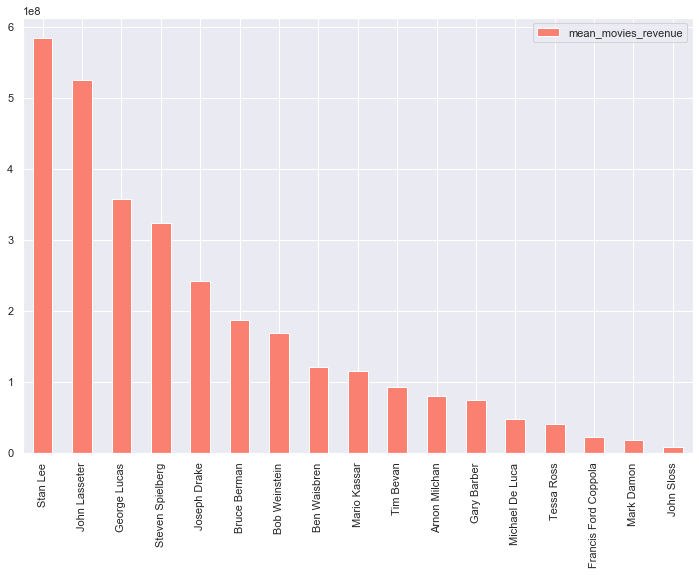

In [204]:
leadExecProdDict = {}
for element in train[["revenue", "exec_producers"]].values:
   # compare results when looking at x top exec producers in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadExecProdDict:
            leadExecProdDict[element[1][i]] = [element[0], 1]
        else:
            leadExecProdDict[element[1][i]][0] += element[0]
            leadExecProdDict[element[1][i]][1] += 1    

leadExecProdDict = {k: v for k, v in leadExecProdDict.items() if v[1] >= 5}

for exec_producer in leadExecProdDict:
    leadExecProdDict[exec_producer][0] = leadExecProdDict[exec_producer][0]/leadExecProdDict[exec_producer][1]
    leadExecProdDict[exec_producer] = leadExecProdDict[exec_producer][0]


    
    
exec_producers_train = pd.DataFrame.from_dict(leadExecProdDict, orient='index', columns=["mean_movies_revenue"])
exec_producers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [205]:
# Sort both of our dicts
leadExecProdDict = {k: v for k, v in sorted(leadExecProdDict.items(), key=lambda item: item[1], reverse = True)}
exec_producersDict = {k: v for k, v in sorted(exec_producersDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top director'
def checkLeadExecProd(crew):
    if len(crew) < 1 or crew[0] not in list(leadExecProdDict)[:25]:
        return 0
    else:
        return 1

def checkTopExecProd(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for director in crew[:5]:
        if director in list(exec_producersDict)[:100]:
            count += 1
    return count

def getExecProdRank(crew):
    if len(crew) < 1:
        return len(exec_producersDict)
    rank = 0
    for c in crew[:5]:
        if c in list(exec_producersDict):
            rank += list(exec_producersDict.keys()).index(c)
    if rank == 0:
        rank = len(exec_producersDict)
    return rank / len(crew)


#Creating a feature for top LEAD execprod
train['topLeadExecProd'] = train['exec_producers'].apply(lambda x: checkLeadExecProd(x))
test['topLeadExecProd'] = test['exec_producers'].apply(lambda x: checkLeadExecProd(x))

#Creating feature for number of top execprod
train['numTopExecProd'] = train['exec_producers'].apply(lambda x: checkTopExecProd(x))
test['numTopExecProd'] = test['exec_producers'].apply(lambda x: checkTopExecProd(x))

train['execProdRank'] = train['exec_producers'].apply(lambda x: getExecProdRank(x))
test['execProdRank'] = test['exec_producers'].apply(lambda x: getExecProdRank(x))


print(train['topLeadExecProd'].value_counts())
print()
print(train['numTopExecProd'].value_counts())
print()
print(train['execProdRank'].value_counts())

0    2859
1     140
Name: topLeadExecProd, dtype: int64

0    2630
1     236
2     106
3      20
4       6
5       1
Name: numTopExecProd, dtype: int64

75.00    2109
37.50     241
25.00     119
18.75      71
15.00      36
         ... 
57.00       1
21.50       1
32.50       1
15.75       1
6.60        1
Name: execProdRank, Length: 195, dtype: int64


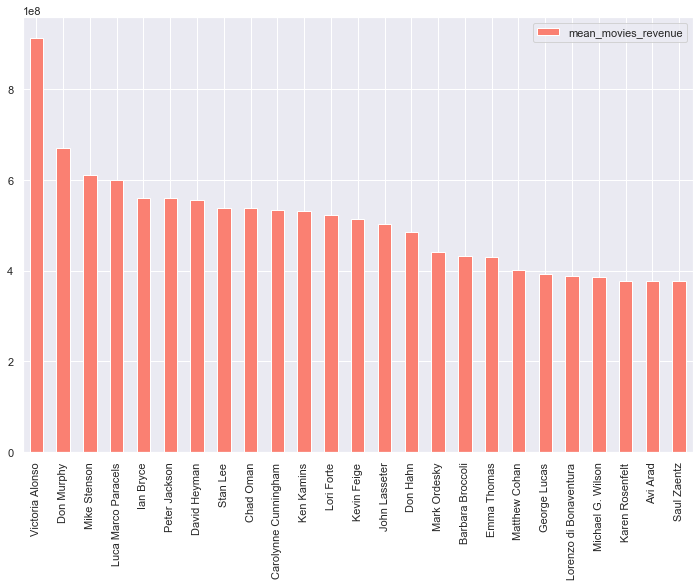

In [206]:
# bivariate producers
train['producers'] = train['crew'].apply(lambda x: re.findall("Producer', 'name': '(.+?)'", x))
test['producers'] = test['crew'].apply(lambda x: re.findall("Producer', 'name': '(.+?)'", x))

producersDict = {}
for element in train[["revenue", "producers"]].values:

    for producer in element[1]:
        if producer not in producersDict:
            producersDict[producer] = [element[0], 1]
        else:
            producersDict[producer][0] += element[0]
            producersDict[producer][1] += 1

producersDict = {k: v for k, v in producersDict.items() if v[1] >= 5}

for producer in producersDict:
    producersDict[producer][0] = producersDict[producer][0]/producersDict[producer][1]
    producersDict[producer] = producersDict[producer][0]




producers_train = pd.DataFrame.from_dict(producersDict, orient='index', columns=["mean_movies_revenue"])
producers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

Changing the search from "Executive Producer" to "Producer" provides different results with some similar/overlapping data.

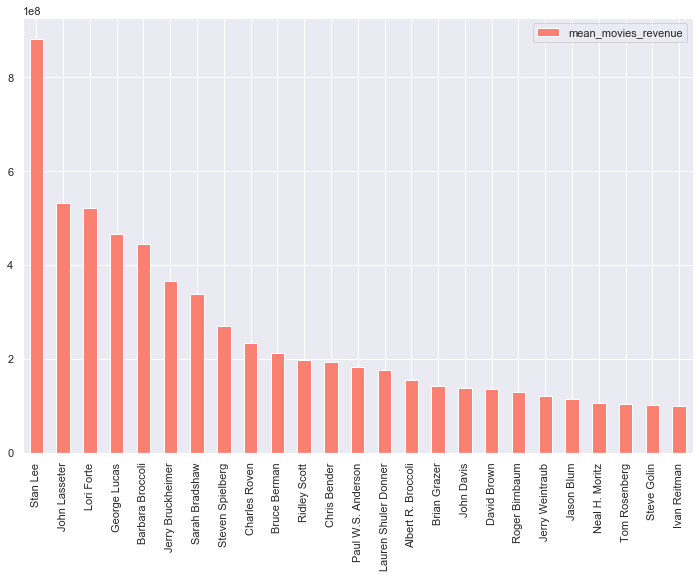

In [207]:
leadProducerDict = {}
for element in train[["revenue", "producers"]].values:
   # compare results when looking at x top producers in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadProducerDict:
            leadProducerDict[element[1][i]] = [element[0], 1]
        else:
            leadProducerDict[element[1][i]][0] += element[0]
            leadProducerDict[element[1][i]][1] += 1    

leadProducerDict = {k: v for k, v in leadProducerDict.items() if v[1] >= 5}

for producer in leadProducerDict:
    leadProducerDict[producer][0] = leadProducerDict[producer][0]/leadProducerDict[producer][1]
    leadProducerDict[producer] = leadProducerDict[producer][0]


    
    
producers_train = pd.DataFrame.from_dict(leadProducerDict, orient='index', columns=["mean_movies_revenue"])
producers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [208]:
# Sort both of our dicts
leadProducerDict = {k: v for k, v in sorted(leadProducerDict.items(), key=lambda item: item[1], reverse = True)}
producersDict = {k: v for k, v in sorted(producersDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top producer'
def checkLeadProducer(crew):
    if len(crew) < 1 or crew[0] not in list(leadProducerDict)[:25]:
        return 0
    else:
        return 1

def checkTopProducers(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for producer in crew[:5]:
        if producer in list(producersDict)[:100]:
            count += 1
    return count


def getProducerRank(crew):
    if len(crew) < 1:
        return len(producersDict)
    rank = 0
    for c in crew[:5]:
        if c in list(producersDict):
            rank += list(producersDict.keys()).index(c)
    if rank == 0:
        rank = len(producersDict)
    return rank / len(crew)



#Creating a feature for top LEAD Producers
train['topLeadProducer'] = train['producers'].apply(lambda x: checkLeadProducer(x))
test['topLeadProducer'] = test['producers'].apply(lambda x: checkLeadProducer(x))

#Creating feature for number of top Producers
train['numTopProducers'] = train['producers'].apply(lambda x: checkTopProducers(x))
test['numTopProducers'] = test['producers'].apply(lambda x: checkTopProducers(x))

train['producersRank'] = train['producers'].apply(lambda x: getProducerRank(x))
test['producersRank'] = test['producers'].apply(lambda x: getProducerRank(x))


print(train['topLeadProducer'].value_counts())
print()
print(train['numTopProducers'].value_counts())
print()
print(train['producersRank'].value_counts())

0    2798
1     201
Name: topLeadProducer, dtype: int64

0    2590
1     249
2      89
3      47
4      17
5       7
Name: numTopProducers, dtype: int64

364.000000    873
182.000000    247
121.333333    213
91.000000     120
72.800000      92
             ... 
66.333333       1
73.833333       1
37.428571       1
92.285714       1
6.400000        1
Name: producersRank, Length: 960, dtype: int64


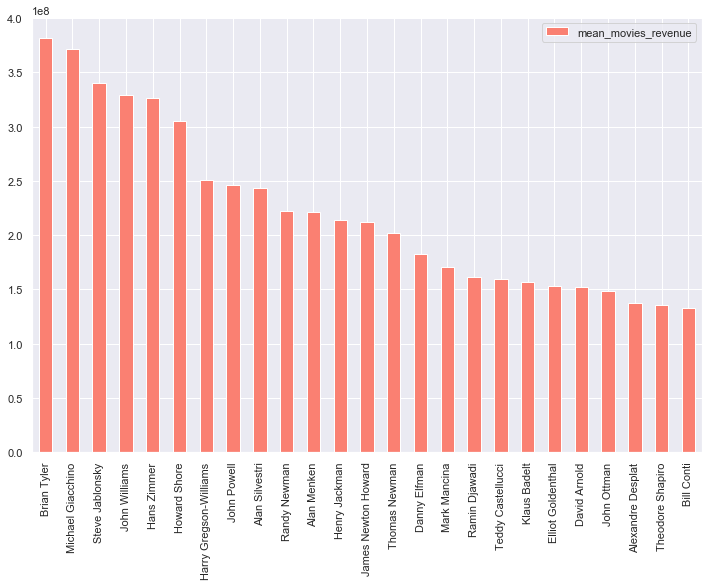

In [209]:
# bivariate composer
train['composers'] = train['crew'].apply(lambda x: re.findall("Composer', 'name': '(.+?)'", x))
test['composers'] = test['crew'].apply(lambda x: re.findall("Composer', 'name': '(.+?)'", x))

composersDict = {}
for element in train[["revenue", "composers"]].values:

    for composer in element[1]:
        if composer not in composersDict:
            composersDict[composer] = [element[0], 1]
        else:
            composersDict[composer][0] += element[0]
            composersDict[composer][1] += 1

composersDict = {k: v for k, v in composersDict.items() if v[1] >= 5}

for composer in composersDict:
    composersDict[composer][0] = composersDict[composer][0]/composersDict[composer][1]
    composersDict[composer] = composersDict[composer][0]




composers_train = pd.DataFrame.from_dict(composersDict, orient='index', columns=["mean_movies_revenue"])
composers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

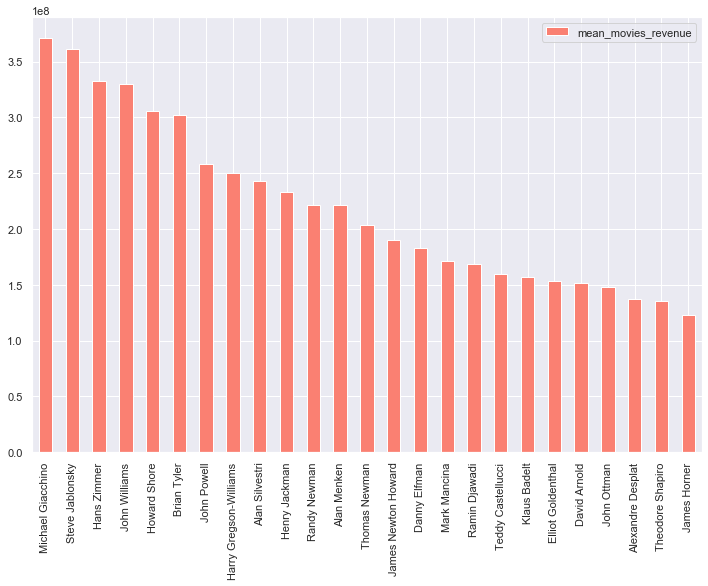

In [210]:
leadComposerDict = {}
for element in train[["revenue", "composers"]].values:
   # compare results when looking at x top composers in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadComposerDict:
            leadComposerDict[element[1][i]] = [element[0], 1]
        else:
            leadComposerDict[element[1][i]][0] += element[0]
            leadComposerDict[element[1][i]][1] += 1    

leadComposerDict = {k: v for k, v in leadComposerDict.items() if v[1] >= 5}

for composer in leadComposerDict:
    leadComposerDict[composer][0] = leadComposerDict[composer][0]/leadComposerDict[composer][1]
    leadComposerDict[composer] = leadComposerDict[composer][0]


    
    
composers_train = pd.DataFrame.from_dict(leadComposerDict, orient='index', columns=["mean_movies_revenue"])
composers_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [211]:
# Sort both of our dicts
leadComposerDict = {k: v for k, v in sorted(leadComposerDict.items(), key=lambda item: item[1], reverse = True)}
composersDict = {k: v for k, v in sorted(composersDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top Composer'
def checkLeadComposer(crew):
    if len(crew) < 1 or crew[0] not in list(leadComposerDict)[:25]:
        return 0
    else:
        return 1

def checkTopComposers(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for composer in crew[:5]:
        if composer in list(composersDict)[:100]:
            count += 1
    return count

def getComposerRank(crew):
    if len(crew) < 1:
        return len(composersDict)
    rank = 0
    for c in crew[:5]:
        if c in list(composersDict):
            rank += list(composersDict.keys()).index(c)
    if rank == 0:
        rank = len(composersDict)
    return rank / len(crew)



#Creating a feature for top LEAD Composers
train['topLeadComposer'] = train['composers'].apply(lambda x: checkLeadComposer(x))
test['topLeadComposer'] = test['composers'].apply(lambda x: checkLeadComposer(x))

#Creating feature for number of top Composers
train['numTopComposers'] = train['composers'].apply(lambda x: checkTopComposers(x))
test['numTopComposers'] = test['composers'].apply(lambda x: checkTopComposers(x))

train['composersRank'] = train['composers'].apply(lambda x: getComposerRank(x))
test['composersRank'] = test['composers'].apply(lambda x: getComposerRank(x))

print(train['topLeadComposer'].value_counts())
print()
print(train['numTopComposers'].value_counts())
print()
print(train['composersRank'].value_counts())

0    2665
1     334
Name: topLeadComposer, dtype: int64

0    2116
1     872
2      11
Name: numTopComposers, dtype: int64

81.000000    2030
40.500000      80
39.000000      35
12.000000      34
27.000000      33
             ... 
16.200000       1
12.500000       1
25.666667       1
11.500000       1
6.500000        1
Name: composersRank, Length: 112, dtype: int64


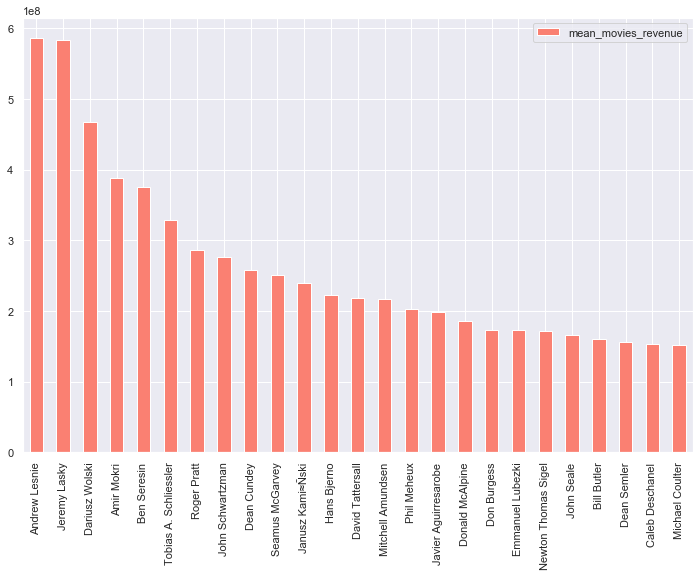

In [212]:
# bivariate director of photography
train['director_photos'] = train['crew'].apply(lambda x: re.findall("Director of Photography', 'name': '(.+?)'", x))
test['director_photos'] = test['crew'].apply(lambda x: re.findall("Director of Photography', 'name': '(.+?)'", x))

director_photosDict = {}
for element in train[["revenue", "director_photos"]].values:

    for director_photo in element[1]:
        if director_photo not in director_photosDict:
            director_photosDict[director_photo] = [element[0], 1]
        else:
            director_photosDict[director_photo][0] += element[0]
            director_photosDict[director_photo][1] += 1

director_photosDict = {k: v for k, v in director_photosDict.items() if v[1] >= 5}

for director_photo in director_photosDict:
    director_photosDict[director_photo][0] = director_photosDict[director_photo][0]/director_photosDict[director_photo][1]
    director_photosDict[director_photo] = director_photosDict[director_photo][0]




director_photos_train = pd.DataFrame.from_dict(director_photosDict, orient='index', columns=["mean_movies_revenue"])
director_photos_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

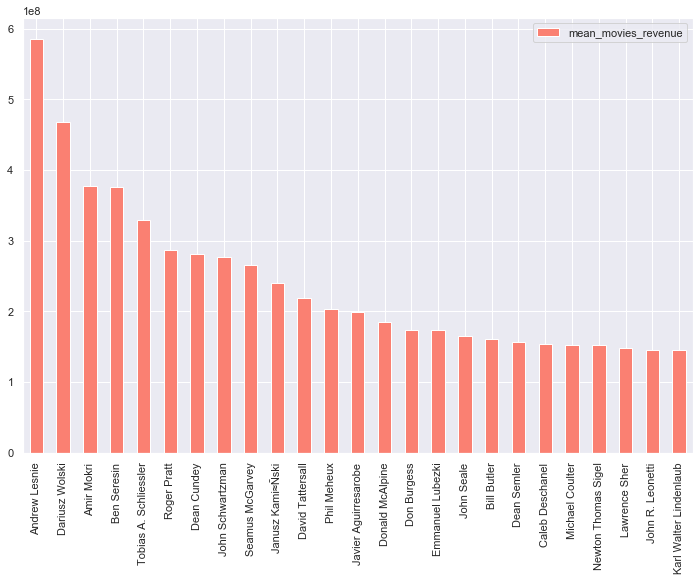

In [213]:
leadDirectorPhotoDict = {}
for element in train[["revenue", "director_photos"]].values:
   # compare results when looking at x top director_photos in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadDirectorPhotoDict:
            leadDirectorPhotoDict[element[1][i]] = [element[0], 1]
        else:
            leadDirectorPhotoDict[element[1][i]][0] += element[0]
            leadDirectorPhotoDict[element[1][i]][1] += 1    

leadDirectorPhotoDict = {k: v for k, v in leadDirectorPhotoDict.items() if v[1] >= 5}

for director_photo in leadDirectorPhotoDict:
    leadDirectorPhotoDict[director_photo][0] = leadDirectorPhotoDict[director_photo][0]/leadDirectorPhotoDict[director_photo][1]
    leadDirectorPhotoDict[director_photo] = leadDirectorPhotoDict[director_photo][0]


    
    
director_photos_train = pd.DataFrame.from_dict(leadDirectorPhotoDict, orient='index', columns=["mean_movies_revenue"])
director_photos_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [214]:
# Sort both of our dicts
leadDirectorPhotoDict = {k: v for k, v in sorted(leadDirectorPhotoDict.items(), key=lambda item: item[1], reverse = True)}
director_photosDict = {k: v for k, v in sorted(director_photosDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top director'
def checkLeadDirectorPhoto(crew):
    if len(crew) < 1 or crew[0] not in list(leadDirectorPhotoDict)[:25]:
        return 0
    else:
        return 1

def checkTopDirectorsPhotos(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for director in crew[:5]:
        if director in list(director_photosDict)[:100]:
            count += 1
    return count

def getDirectorsPhotosRank(crew):
    if len(crew) < 1:
        return len(director_photosDict)
    rank = 0
    for c in crew[:5]:
        if c in list(director_photosDict):
            rank += list(director_photosDict.keys()).index(c)
    if rank == 0:
        rank = len(director_photosDict)
    return rank / len(crew)


#Creating a feature for top LEAD director of photography
train['topLeadDirectorPhoto'] = train['director_photos'].apply(lambda x: checkLeadDirectorPhoto(x))
test['topLeadDirectorPhoto'] = test['director_photos'].apply(lambda x: checkLeadDirectorPhoto(x))

#Creating feature for number of top director of photography
train['numTopDirectorsPhoto'] = train['director_photos'].apply(lambda x: checkTopDirectorsPhotos(x))
test['numTopDirectorsPhoto'] = test['director_photos'].apply(lambda x: checkTopDirectorsPhotos(x))

train['directorsPhotoRank'] = train['director_photos'].apply(lambda x: getDirectorsPhotosRank(x))
test['directorsPhotoRank'] = test['director_photos'].apply(lambda x: getDirectorsPhotosRank(x))


print(train['topLeadDirectorPhoto'].value_counts())
print()
print(train['numTopDirectorsPhoto'].value_counts())
print()
print(train['directorsPhotoRank'].value_counts())

0    2796
1     203
Name: topLeadDirectorPhoto, dtype: int64

0    2248
1     743
2       8
Name: numTopDirectorsPhoto, dtype: int64

129.0    2002
64.5       62
22.0       18
43.0       17
32.0       17
         ... 
8.5         1
13.5        1
9.5         1
2.5         1
35.5        1
Name: directorsPhotoRank, Length: 153, dtype: int64


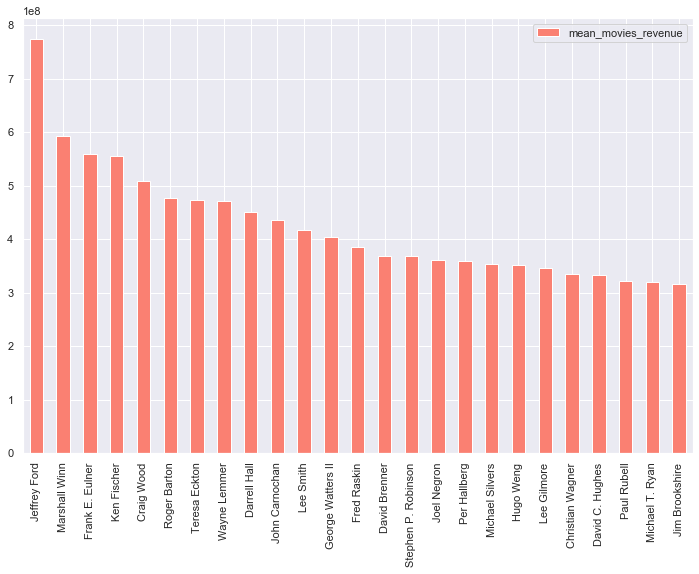

In [215]:
# bivariate editor
train['editors'] = train['crew'].apply(lambda x: re.findall("Editor', 'name': '(.+?)'", x))
test['editors'] = test['crew'].apply(lambda x: re.findall("Editor', 'name': '(.+?)'", x))

editorsDict = {}
for element in train[["revenue", "editors"]].values:

    for editor in element[1]:
        if editor not in editorsDict:
            editorsDict[editor] = [element[0], 1]
        else:
            editorsDict[editor][0] += element[0]
            editorsDict[editor][1] += 1

editorsDict = {k: v for k, v in editorsDict.items() if v[1] >= 5}

for editor in editorsDict:
    editorsDict[editor][0] = editorsDict[editor][0]/editorsDict[editor][1]
    editorsDict[editor] = editorsDict[editor][0]




editors_train = pd.DataFrame.from_dict(editorsDict, orient='index', columns=["mean_movies_revenue"])
editors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')

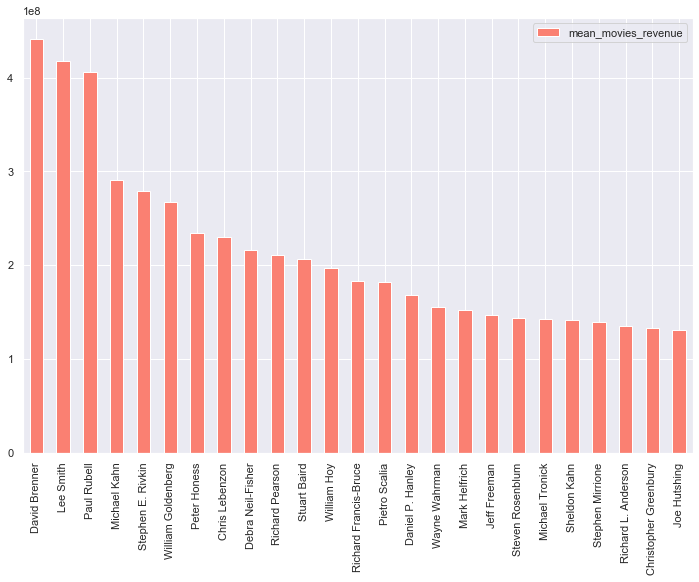

In [216]:
leadEditorDict = {}
for element in train[["revenue", "editors"]].values:
   # compare results when looking at x top editors in films vs whole cast 
    temp = 1
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in leadEditorDict:
            leadEditorDict[element[1][i]] = [element[0], 1]
        else:
            leadEditorDict[element[1][i]][0] += element[0]
            leadEditorDict[element[1][i]][1] += 1    

leadEditorDict = {k: v for k, v in leadEditorDict.items() if v[1] >= 5}

for editor in leadEditorDict:
    leadEditorDict[editor][0] = leadEditorDict[editor][0]/leadEditorDict[editor][1]
    leadEditorDict[editor] = leadEditorDict[editor][0]


    
    
editors_train = pd.DataFrame.from_dict(leadEditorDict, orient='index', columns=["mean_movies_revenue"])
editors_train.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='salmon')


In [217]:
# Sort both of our dicts
leadEditorDict = {k: v for k, v in sorted(leadEditorDict.items(), key=lambda item: item[1], reverse = True)}
editorsDict = {k: v for k, v in sorted(editorsDict.items(), key=lambda item: item[1], reverse = True)}


# function to check if lead role is a 'top Editor'
def checkLeadEditor(crew):
    if len(crew) < 1 or crew[0] not in list(leadEditorDict)[:25]:
        return 0
    else:
        return 1

def checkTopEditors(crew):
    if len(crew) < 1:
        return 0
    count = 0
    for editor in crew[:5]:
        if editor in list(editorsDict)[:100]:
            count += 1
    return count

def getEditorsRank(crew):
    if len(crew) < 1:
        return len(editorsDict)
    rank = 0
    for c in crew[:5]:
        if c in list(editorsDict):
            rank += list(editorsDict.keys()).index(c)
    if rank == 0:
        rank = len(editorsDict)
    return rank / len(crew)


#Creating a feature for top LEAD Editors
train['topLeadEditor'] = train['editors'].apply(lambda x: checkLeadEditor(x))
test['topLeadEditor'] = test['editors'].apply(lambda x: checkLeadEditor(x))

#Creating feature for number of top Editors
train['numTopEditors'] = train['editors'].apply(lambda x: checkTopEditors(x))
test['numTopEditors'] = test['editors'].apply(lambda x: checkTopEditors(x))

train['editorsRank'] = train['editors'].apply(lambda x: getEditorsRank(x))
test['editorsRank'] = test['editors'].apply(lambda x: getEditorsRank(x))


print(train['topLeadEditor'].value_counts())
print()
print(train['numTopEditors'].value_counts())
print()
print(train['editorsRank'].value_counts())

0    2817
1     182
Name: topLeadEditor, dtype: int64

0    2662
1     222
2      74
3      32
4       9
Name: numTopEditors, dtype: int64

327.000000    1563
163.500000     189
109.000000      69
81.750000       37
65.400000       30
              ... 
69.100000        1
12.666667        1
49.300000        1
21.181818        1
43.800000        1
Name: editorsRank, Length: 687, dtype: int64


In [218]:
train_features.append('topLeadDirector')
log_features.append('numTopDirectors')
log_features.append('directorsRank')

train_features.append('topLeadExecProd')
log_features.append('numTopExecProd')
log_features.append('execProdRank')

train_features.append('topLeadProducer')
log_features.append('numTopProducers')
log_features.append('producersRank')

train_features.append('topLeadComposer')
log_features.append('numTopComposers')
log_features.append('composersRank')

train_features.append('topLeadDirectorPhoto')
log_features.append('numTopDirectorsPhoto')
log_features.append('directorsPhotoRank')

train_features.append('topLeadEditor')
log_features.append('numTopEditors')
log_features.append('editorsRank')


## Additional Feature Creation

In [219]:

def getAvgStudioRev(movie):
    if movie.budget < 10000: 
        if len(movie.production_companies_reform) > 0:
            studios = movie.production_companies_reform
            median_revs = []
            for studio in studios:
                if studio in companies_df.index:
                     median_revs.append(float(companies_df.loc[studio]['median_rev']))
            if(len(median_revs) > 0) and mean(median_revs) > 10000:
                movie.budget_processed = mean(median_revs)
            else:
                movie.budget_processed = train.budget.median()
        else:
            movie.budget_processed = train.budget.median()
        
        
    
    if 'revenue' in movie and movie.revenue < 10000 and len(movie.production_companies_reform) > 0:
        studios = movie.production_companies_reform
        median_revs = []
        for studio in studios:
            if studio in companies_df.index:
                 median_revs.append(float(companies_df.loc[studio]['median_rev']))
        if(len(median_revs) > 0) and mean(median_revs) > 10000:
            movie.revenue = mean(median_revs)
        else:
            movie.revenue = train.revenue.median()
        return movie
    else:
        return movie

In [220]:
train = train.apply(getAvgStudioRev, axis=1)
test = test.apply(getAvgStudioRev, axis=1)

In [221]:
train.nsmallest(10, 'budget_processed')['budget_processed']

2095    10068.0
254     11178.0
1893    12000.0
707     13769.0
95      14353.0
1952    14836.0
1230    15000.0
560     16136.0
2786    17000.0
23      17011.0
Name: budget_processed, dtype: float64

In [222]:
print(train.budget.mean())
print(train.budget_processed.mean())

22532845.058352783
29409199.916644182


In [223]:
train['budget_to_year_ratio'] = train['budget_processed'] / (train['year'] * train['year'])
test['budget_to_year_ratio'] = test['budget_processed'] / (test['year'] * test['year'])

In [224]:
train['runtime_to_year_ratio'] = train['runtime'] / (train['year'])
test['runtime_to_year_ratio'] = test['runtime'] / (test['year'])
test['runtime_to_year_ratio'].sum()

236.11714274339676

In [225]:
corr, _ = pearsonr(np.log1p(train['runtime_to_year_ratio']), np.log1p(train['revenue']))
print('Pearsons correlation between runtime_to_year_ratio and revenue: %.3f' % corr)

Pearsons correlation between runtime_to_year_ratio and revenue: 0.224


In [226]:
log_features.append('budget_to_year_ratio')
log_features.append('runtime_to_year_ratio')

## Feature Selection

Now that we have explored all of the data and created several new features for our model, let's look at the results and get our final set of features.

In [227]:
print(cols_to_drop)

['imdb_id', 'original_title', 'overview', 'popularity', 'poster_path', 'status']


We ended up with 5 columns we decided to drop entirely that do not have any use to us. We do not need to actually drop them from the dataset, but it is nice to track the columns that are completely unused and did not serve a purpose to our model. Each of the justificaions for dropping these can be found throughout the analysis.

In [228]:
print(train_features)

['belongs_to_collection', 'has_homepage', 'originally_english', 'topStudio', 'usa_produced', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'mondayRelease', 'tuesdayRelease', 'wednesdayRelease', 'thursdayRelease', 'fridayRelease', 'saturdayRelease', 'sundayRelease', 'Winter', 'Fall', 'Spring', 'Summer', 'released_in_english', 'has_tagline', 'has_keywords', 'topLeadActor', 'topLeadDirector', 'topLeadExecProd', 'topLeadProducer', 'topLeadComposer', 'topLeadDirectorPhoto', 'topLeadEditor']


In [229]:

#train_features = ['belongs_to_collection', 'has_homepage', 'originally_english', 'topStudio', 'usa_produced', 'released_in_english', 'has_tagline', 'has_keywords', 'topLeadActor', 'topLeadDirector', 'topLeadExecProd', 'topLeadProducer', 'topLeadComposer', 'topLeadDirectorPhoto', 'topLeadEditor', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'fridayRelease', 'Winter', 'Fall', 'Spring', 'Summer']


In [230]:
print(log_features)

['revenue', 'budget_processed', 'genre_rank', 'num_genres', 'numTopStudios', 'num_studios', 'studioRank', 'num_production_countries', 'runtime_processed', 'num_languages', 'title_len', 'num_cast', 'numTopActors', 'actorRanks', 'topActorRank', 'num_crew', 'num_male_crew', 'num_female_crew', 'numTopDirectors', 'directorsRank', 'numTopExecProd', 'execProdRank', 'numTopProducers', 'producersRank', 'numTopComposers', 'composersRank', 'numTopDirectorsPhoto', 'directorsPhotoRank', 'numTopEditors', 'editorsRank', 'budget_to_year_ratio', 'runtime_to_year_ratio']


In [231]:
#log_features = ['revenue', 'budget_processed', 'genre_rank', 'num_genres', 'numTopStudios', 'num_studios', 'studioRank', 'num_production_countries', 'runtime_processed', 'num_languages', 'title_len', 'num_cast', 'numTopActors', 'actorRanks', 'topActorRank' , 'num_crew', 'num_male_crew', 'num_female_crew', 'numTopDirectors', 'directorsRank', 'numTopExecProd', 'execProdRank', 'numTopProducers', 'producersRank', 'numTopComposers', 'composersRank', 'numTopDirectorsPhoto', 'directorsPhotoRank', 'numTopEditors', 'editorsRank', 'budget_to_year_ratio', 'runtime_to_year_ratio']



In [232]:
for feat in log_features:
    train["log_" + feat] = np.log1p(train[feat])
    if feat is not "revenue":
        test["log_" + feat] = np.log1p(test[feat]) 
        train_features.append("log_" + feat)

Now we have created log transformed features for all the ones we wanted to and this will be our final list of features for our model. Let's take a look at the list.

In [233]:
print(train_features)
print()
print("Number of features: ", len(train_features))

['belongs_to_collection', 'has_homepage', 'originally_english', 'topStudio', 'usa_produced', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'mondayRelease', 'tuesdayRelease', 'wednesdayRelease', 'thursdayRelease', 'fridayRelease', 'saturdayRelease', 'sundayRelease', 'Winter', 'Fall', 'Spring', 'Summer', 'released_in_english', 'has_tagline', 'has_keywords', 'topLeadActor', 'topLeadDirector', 'topLeadExecProd', 'topLeadProducer', 'topLeadComposer', 'topLeadDirectorPhoto', 'topLeadEditor', 'log_budget_processed', 'log_genre_rank', 'log_num_genres', 'log_numTopStudios', 'log_num_studios', 'log_studioRank', 'log_num_production_countries', 'log_runtime_processed', 'log_num_languages', 'log_title_len', 'log_num_cast', 'log_numTopActors', 'log_actorRanks', 'log_topActorRank', 'log_num_crew', 'log_num_male_crew', 'log_num_female_crew', 'log_numTopDirectors', 'log_directorsRank', 'log_numTopExecProd', 'log_execProdRank', 'log_numTopProducers', 'log_producersRank', 'log_numTopComposers', '

Text(0.5, 1, 'Correlation between numerical features')

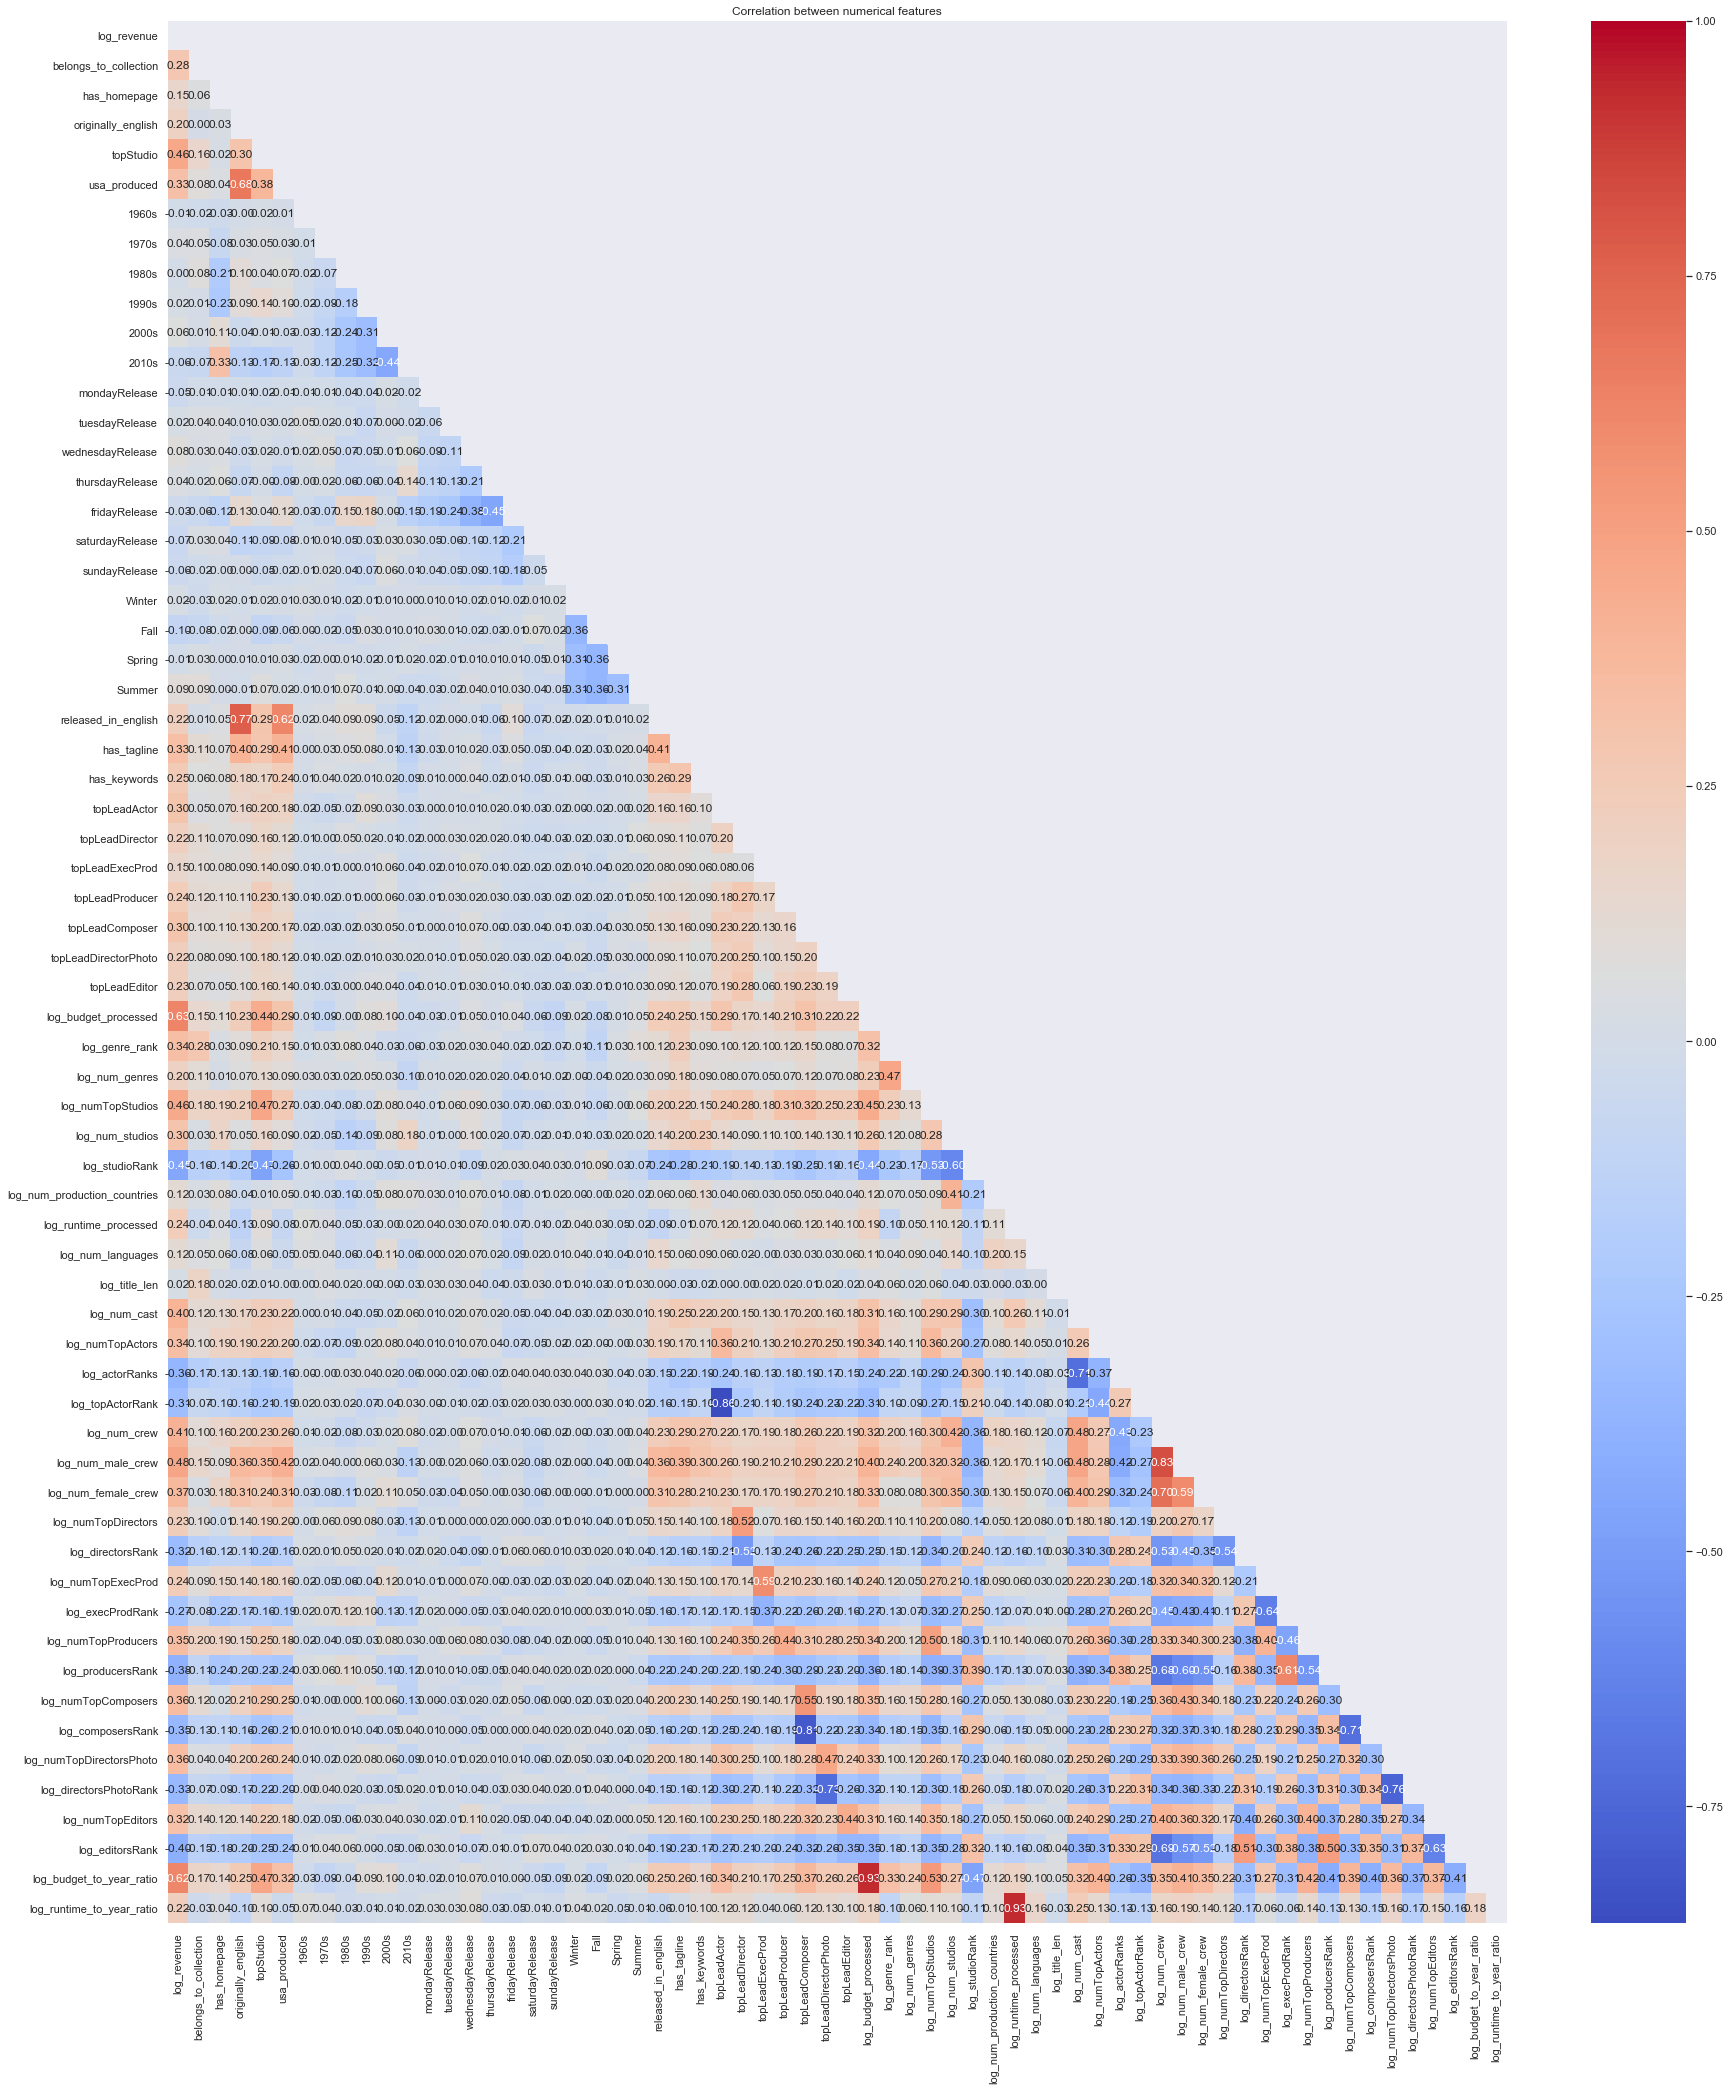

In [234]:
# Correlation matrix
sns.set(rc={'figure.figsize':(30,35)})

# Compute the correlation matrix
corr = train[['log_revenue', *train_features]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')

plt.title("Correlation between numerical features")

## Modeling

In [235]:
#Set up our X and y
X = train[train_features]
y = train['log_revenue']

In [236]:
# create a 80/20 stratified split of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

In [237]:
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (2399, 63) (2399,)
Test set: (600, 63) (600,)


In [238]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_root_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [239]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%'.format(accuracy))
    
    return accuracy

In [240]:
def metrics(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    errors = abs(y_pred - y_test)
    mae = np.mean(errors)
    mape = 100 * (errors / y_test)
    print('Mean Squared Error: ', round(mse, 4))
    print('Root Mean Squared Error: ', round(rmse, 4))
    print('Mean Absolute Error: ', round(mae, 4))

    
    # Calculate and display accuracy
    test_accuracy = 100 - np.mean(mape)
    print('Test Set Accuracy (from Mean Absolute Percentage Error):', round(test_accuracy, 2), '%')

### Random Forest

#### Baseline

In [241]:
rfr_base_model = RandomForestRegressor(random_state=42)
rfr_base_model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [242]:
y_pred = rfr_base_model.predict(X_test)

In [243]:
errors = abs(np.expm1(y_pred) - np.expm1(y_test.values))
# Print out the mean absolute error (mae)
print('Average Error:', round(np.mean(errors), 2))

Average Error: 34860429.06


In [244]:
print('Random Forest Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Random Forest Baseline Model Metrics:
Mean Squared Error:  2.4306
Root Mean Squared Error:  1.559
Mean Absolute Error:  1.0914
Test Set Accuracy (from Mean Absolute Percentage Error): 91.62 %


#### Grid Search Hyperparameter Tuning

In [245]:

param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 25, 30],
    'max_features': [.4, 'auto'],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [1, 3, 5],
    'n_estimators': [100,400]
}

# Create a based model
rfr = RandomForestRegressor(random_state=42)
# Instantiate the grid search model
rfr, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, rfr, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-rfr.best_score_))
print(rfr.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 11.1min finished


1.2821148898057488
{'bootstrap': True, 'max_depth': 25, 'max_features': 0.4, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 400}


In [246]:
print('Base Model:')
base_accuracy = evaluate(rfr_base_model, X_test, y_test.values)
print()
print('Model after Tuning:')
rfr_best_model = rfr.best_estimator_
best_accuracy = evaluate(rfr_best_model, X_test, y_test.values)

print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Base Model:
Average Error: 1.0914
Accuracy = 91.62%

Model after Tuning:
Average Error: 1.0724
Accuracy = 91.72%
Improvement of 0.11%.


Base Model:
Average Error: 1.0914
Accuracy = 91.62%

Model after Tuning:
Average Error: 1.0724
Accuracy = 91.72%
Improvement of 0.11%.

In [247]:
y_pred = rfr_best_model.predict(X_test)
print('Random Forest Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

Random Forest Model (After Tuning) Metrics:
Mean Squared Error:  2.3974
Root Mean Squared Error:  1.5483
Mean Absolute Error:  1.0724
Test Set Accuracy (from Mean Absolute Percentage Error): 91.72 %


#### Feature Importances

In [248]:
feature_importances = rfr_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_budget_to_year_ratio (0.235128)
2. log_budget_processed (0.187253)
3. log_num_male_crew (0.057917)
4. topStudio (0.049170)
5. log_num_studios (0.038020)
6. log_actorRanks (0.034679)
7. log_runtime_to_year_ratio (0.034262)
8. log_numTopStudios (0.027567)
9. log_studioRank (0.027137)
10. log_runtime_processed (0.025080)
11. log_genre_rank (0.024846)
12. log_num_cast (0.023645)
13. log_num_crew (0.021753)
14. log_title_len (0.018864)
15. log_editorsRank (0.013546)
16. log_producersRank (0.013513)
17. belongs_to_collection (0.012568)
18. log_directorsRank (0.008590)
19. log_topActorRank (0.008508)
20. log_num_production_countries (0.008446)
21. log_directorsPhotoRank (0.008123)
22. log_num_genres (0.008073)
23. log_composersRank (0.007654)
24. log_num_female_crew (0.006886)
25. log_numTopDirectorsPhoto (0.006115)
26. 2010s (0.005477)
27. has_tagline (0.005049)
28. log_numTopProducers (0.005008)
29. log_execProdRank (0.004672)
30. mondayRelease (0.004484)
31. log_num

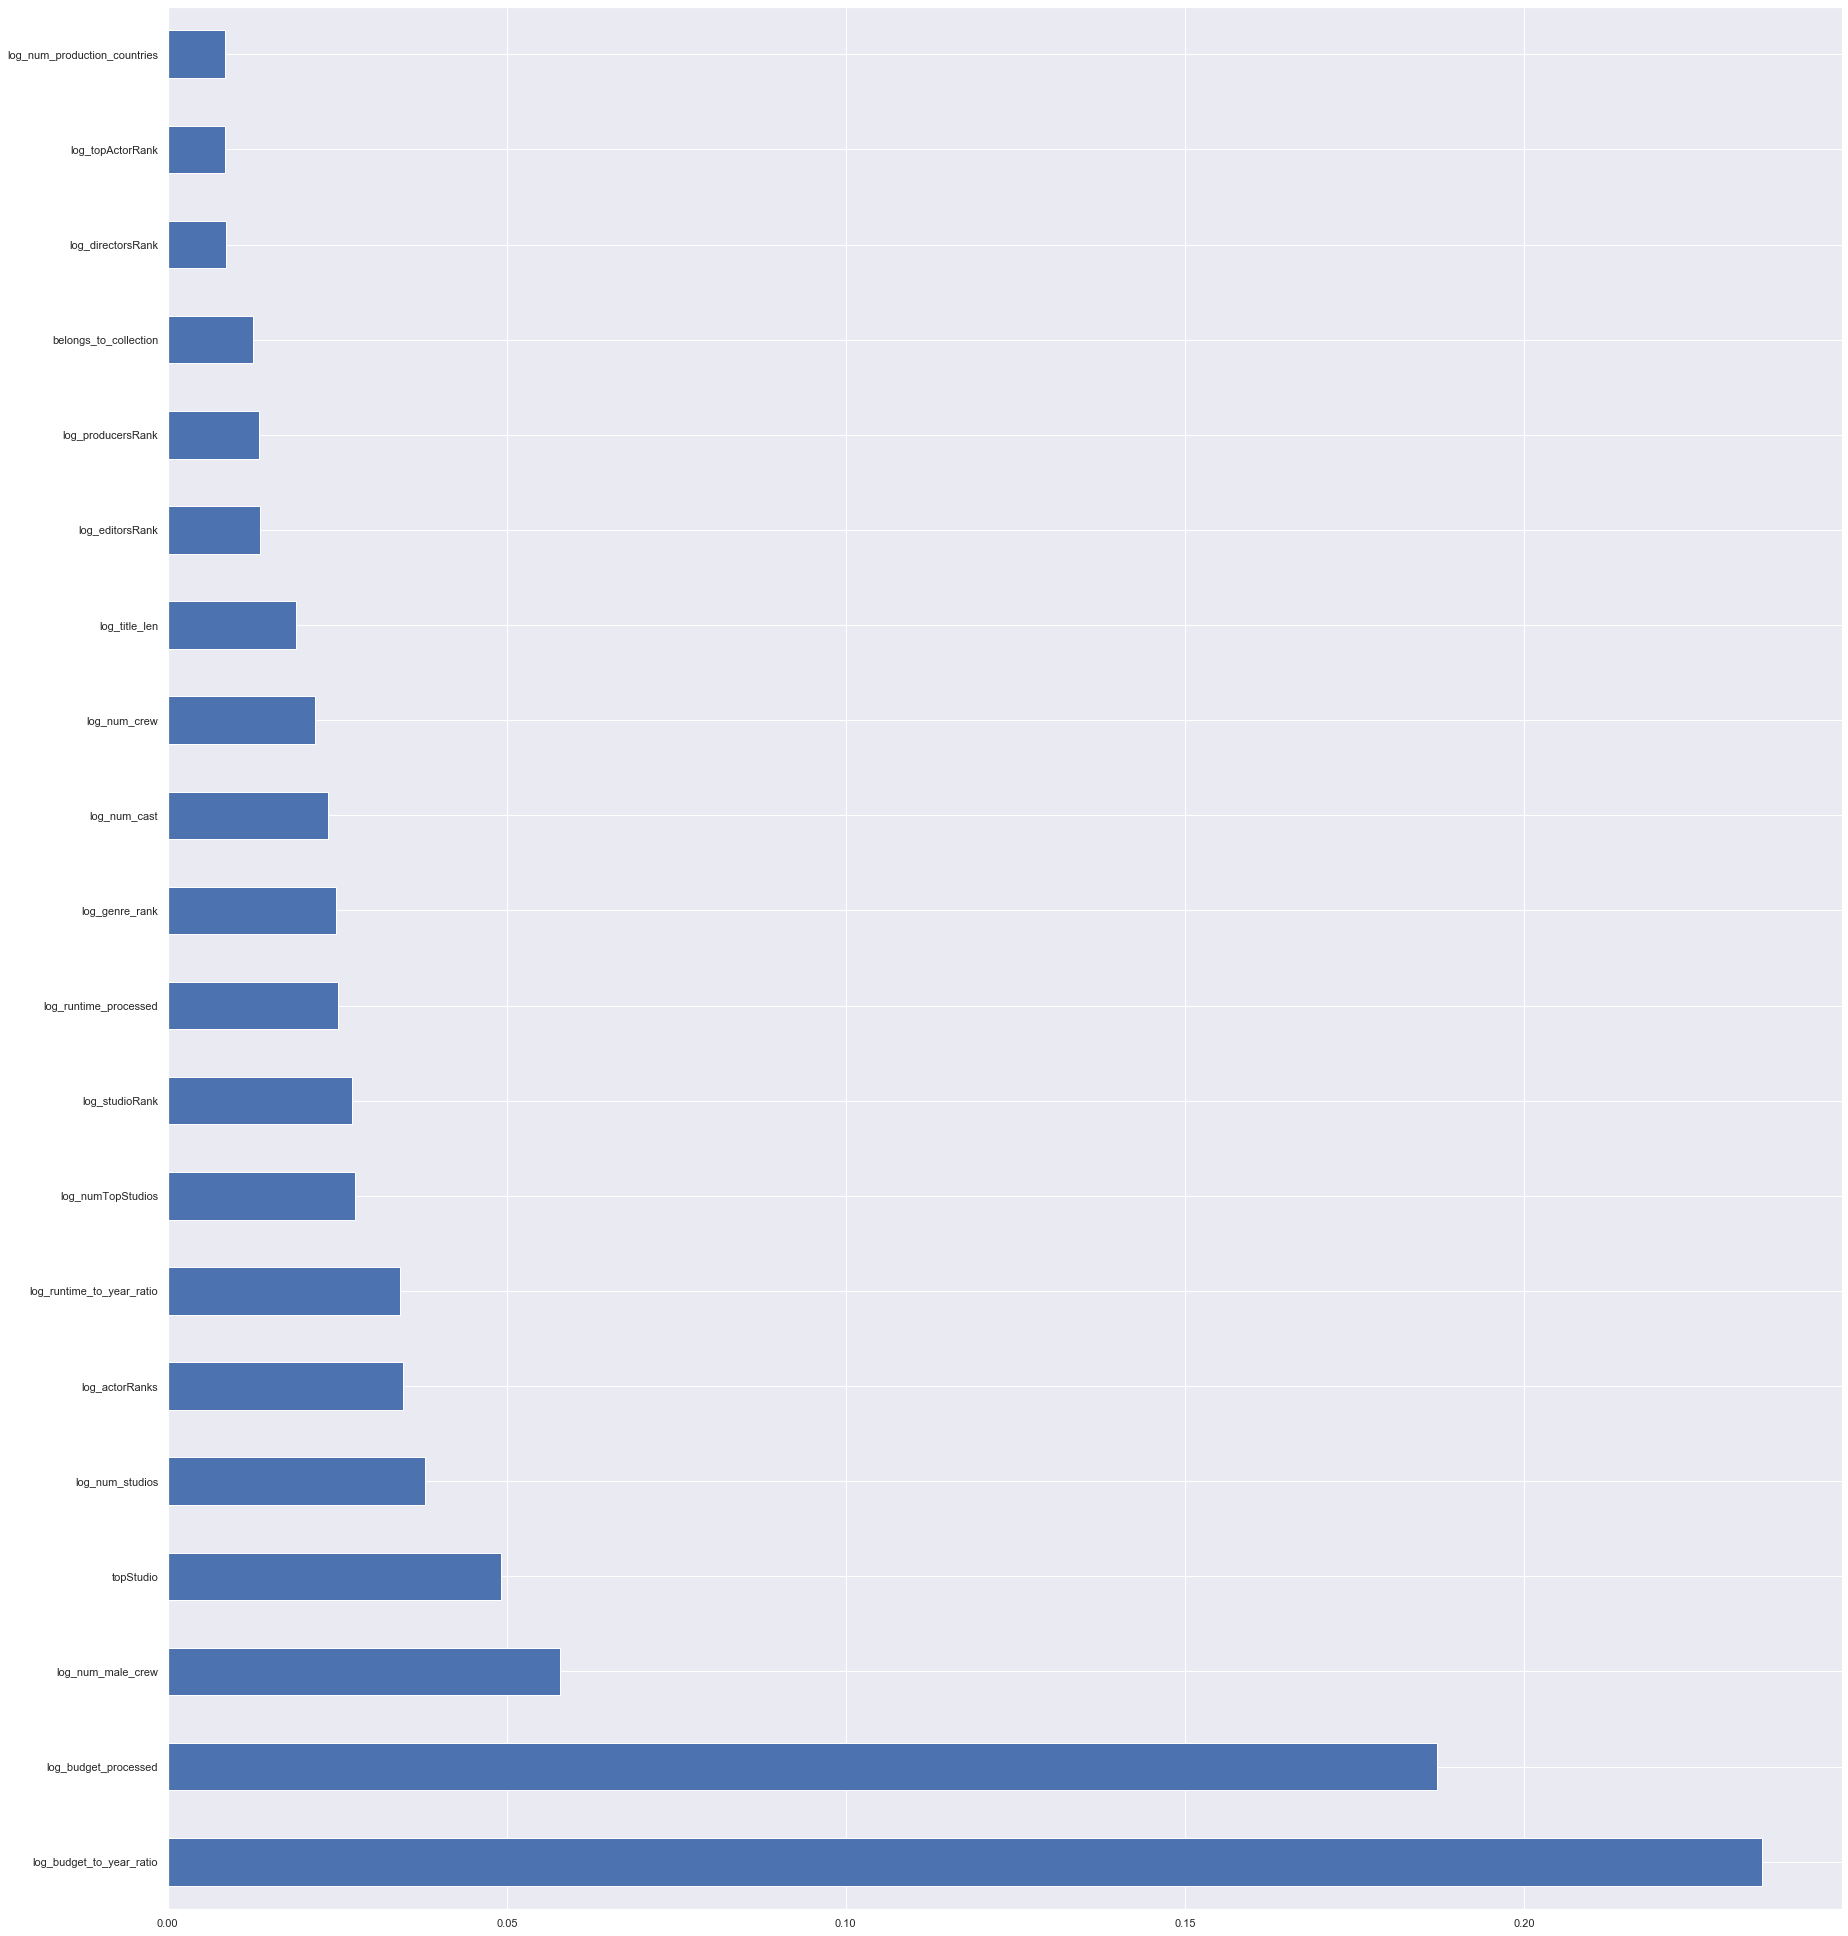

In [249]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


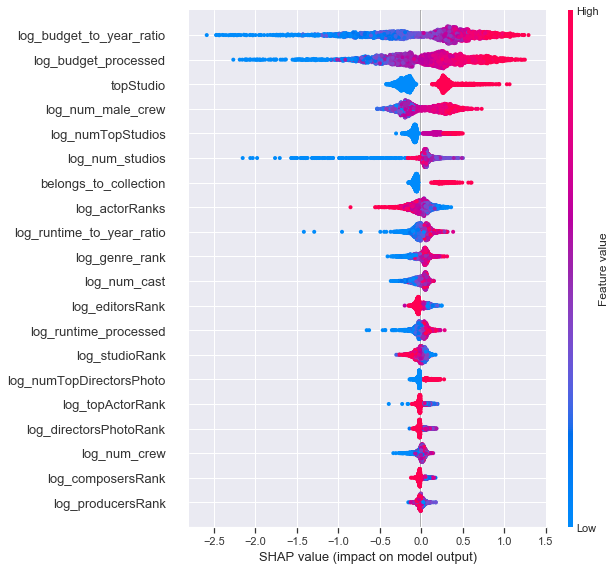

In [250]:

explainer = shap.TreeExplainer(rfr_best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

### Extra Trees

#### Baseline

In [251]:
et_base_model = ExtraTreesRegressor(random_state = 42)
et_base_model.fit(X_train, y_train.values.ravel())

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features='auto', max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=100, n_jobs=None, oob_score=False,
                    random_state=42, verbose=0, warm_start=False)

In [252]:
y_pred = et_base_model.predict(X_test)

In [253]:
print('Extra Trees Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Extra Trees Baseline Model Metrics:
Mean Squared Error:  2.5944
Root Mean Squared Error:  1.6107
Mean Absolute Error:  1.1208
Test Set Accuracy (from Mean Absolute Percentage Error): 91.39 %


#### Grid Search Hyperparameter Tuning

In [254]:
et_model = ExtraTreesRegressor(random_state = 42)
param_grid = {
    'bootstrap': [True],
    'max_depth': [35, 40, 45],
    'max_features': [.4, .6, 'auto'],
    'min_samples_leaf': [1, 2],
    'min_samples_split': [4, 5, 7],
    'n_estimators': [100, 250, 400]
}

et_model, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, et_model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-et_model.best_score_))
print(et_model.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  8.4min finished


1.2710189198659958
{'bootstrap': True, 'max_depth': 40, 'max_features': 0.6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}


In [255]:
base_accuracy = evaluate(et_base_model, X_test, y_test.values)

et_best_model = et_model.best_estimator_
best_accuracy = evaluate(et_best_model, X_test, y_test.values)


print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Average Error: 1.1208
Accuracy = 91.39%
Average Error: 1.0978
Accuracy = 91.51%
Improvement of 0.12%.


Average Error: 1.1208
Accuracy = 91.39%
Average Error: 1.0978
Accuracy = 91.51%
Improvement of 0.12%.

In [256]:
y_pred = et_best_model.predict(X_test)
print('Extra Trees Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

Extra Trees Model (After Tuning) Metrics:
Mean Squared Error:  2.5049
Root Mean Squared Error:  1.5827
Mean Absolute Error:  1.0978
Test Set Accuracy (from Mean Absolute Percentage Error): 91.51 %


#### Feature Importances

In [257]:
feature_importances = et_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. topStudio (0.137906)
2. log_budget_to_year_ratio (0.136228)
3. log_budget_processed (0.126447)
4. log_numTopStudios (0.039905)
5. log_num_studios (0.036553)
6. log_num_male_crew (0.030496)
7. log_numTopDirectorsPhoto (0.024913)
8. belongs_to_collection (0.024318)
9. log_runtime_processed (0.016433)
10. log_runtime_to_year_ratio (0.015849)
11. log_actorRanks (0.015770)
12. has_homepage (0.014936)
13. log_numTopComposers (0.014750)
14. log_num_production_countries (0.014201)
15. has_tagline (0.013869)
16. log_studioRank (0.013584)
17. log_num_crew (0.013437)
18. log_genre_rank (0.013035)
19. log_num_cast (0.012556)
20. log_numTopProducers (0.012448)
21. mondayRelease (0.012037)
22. log_editorsRank (0.012037)
23. has_keywords (0.011787)
24. 2010s (0.010879)
25. log_numTopActors (0.010751)
26. log_producersRank (0.010319)
27. log_title_len (0.009212)
28. log_directorsRank (0.009068)
29. log_num_genres (0.009007)
30. log_composersRank (0.008630)
31. log_num_female_crew (

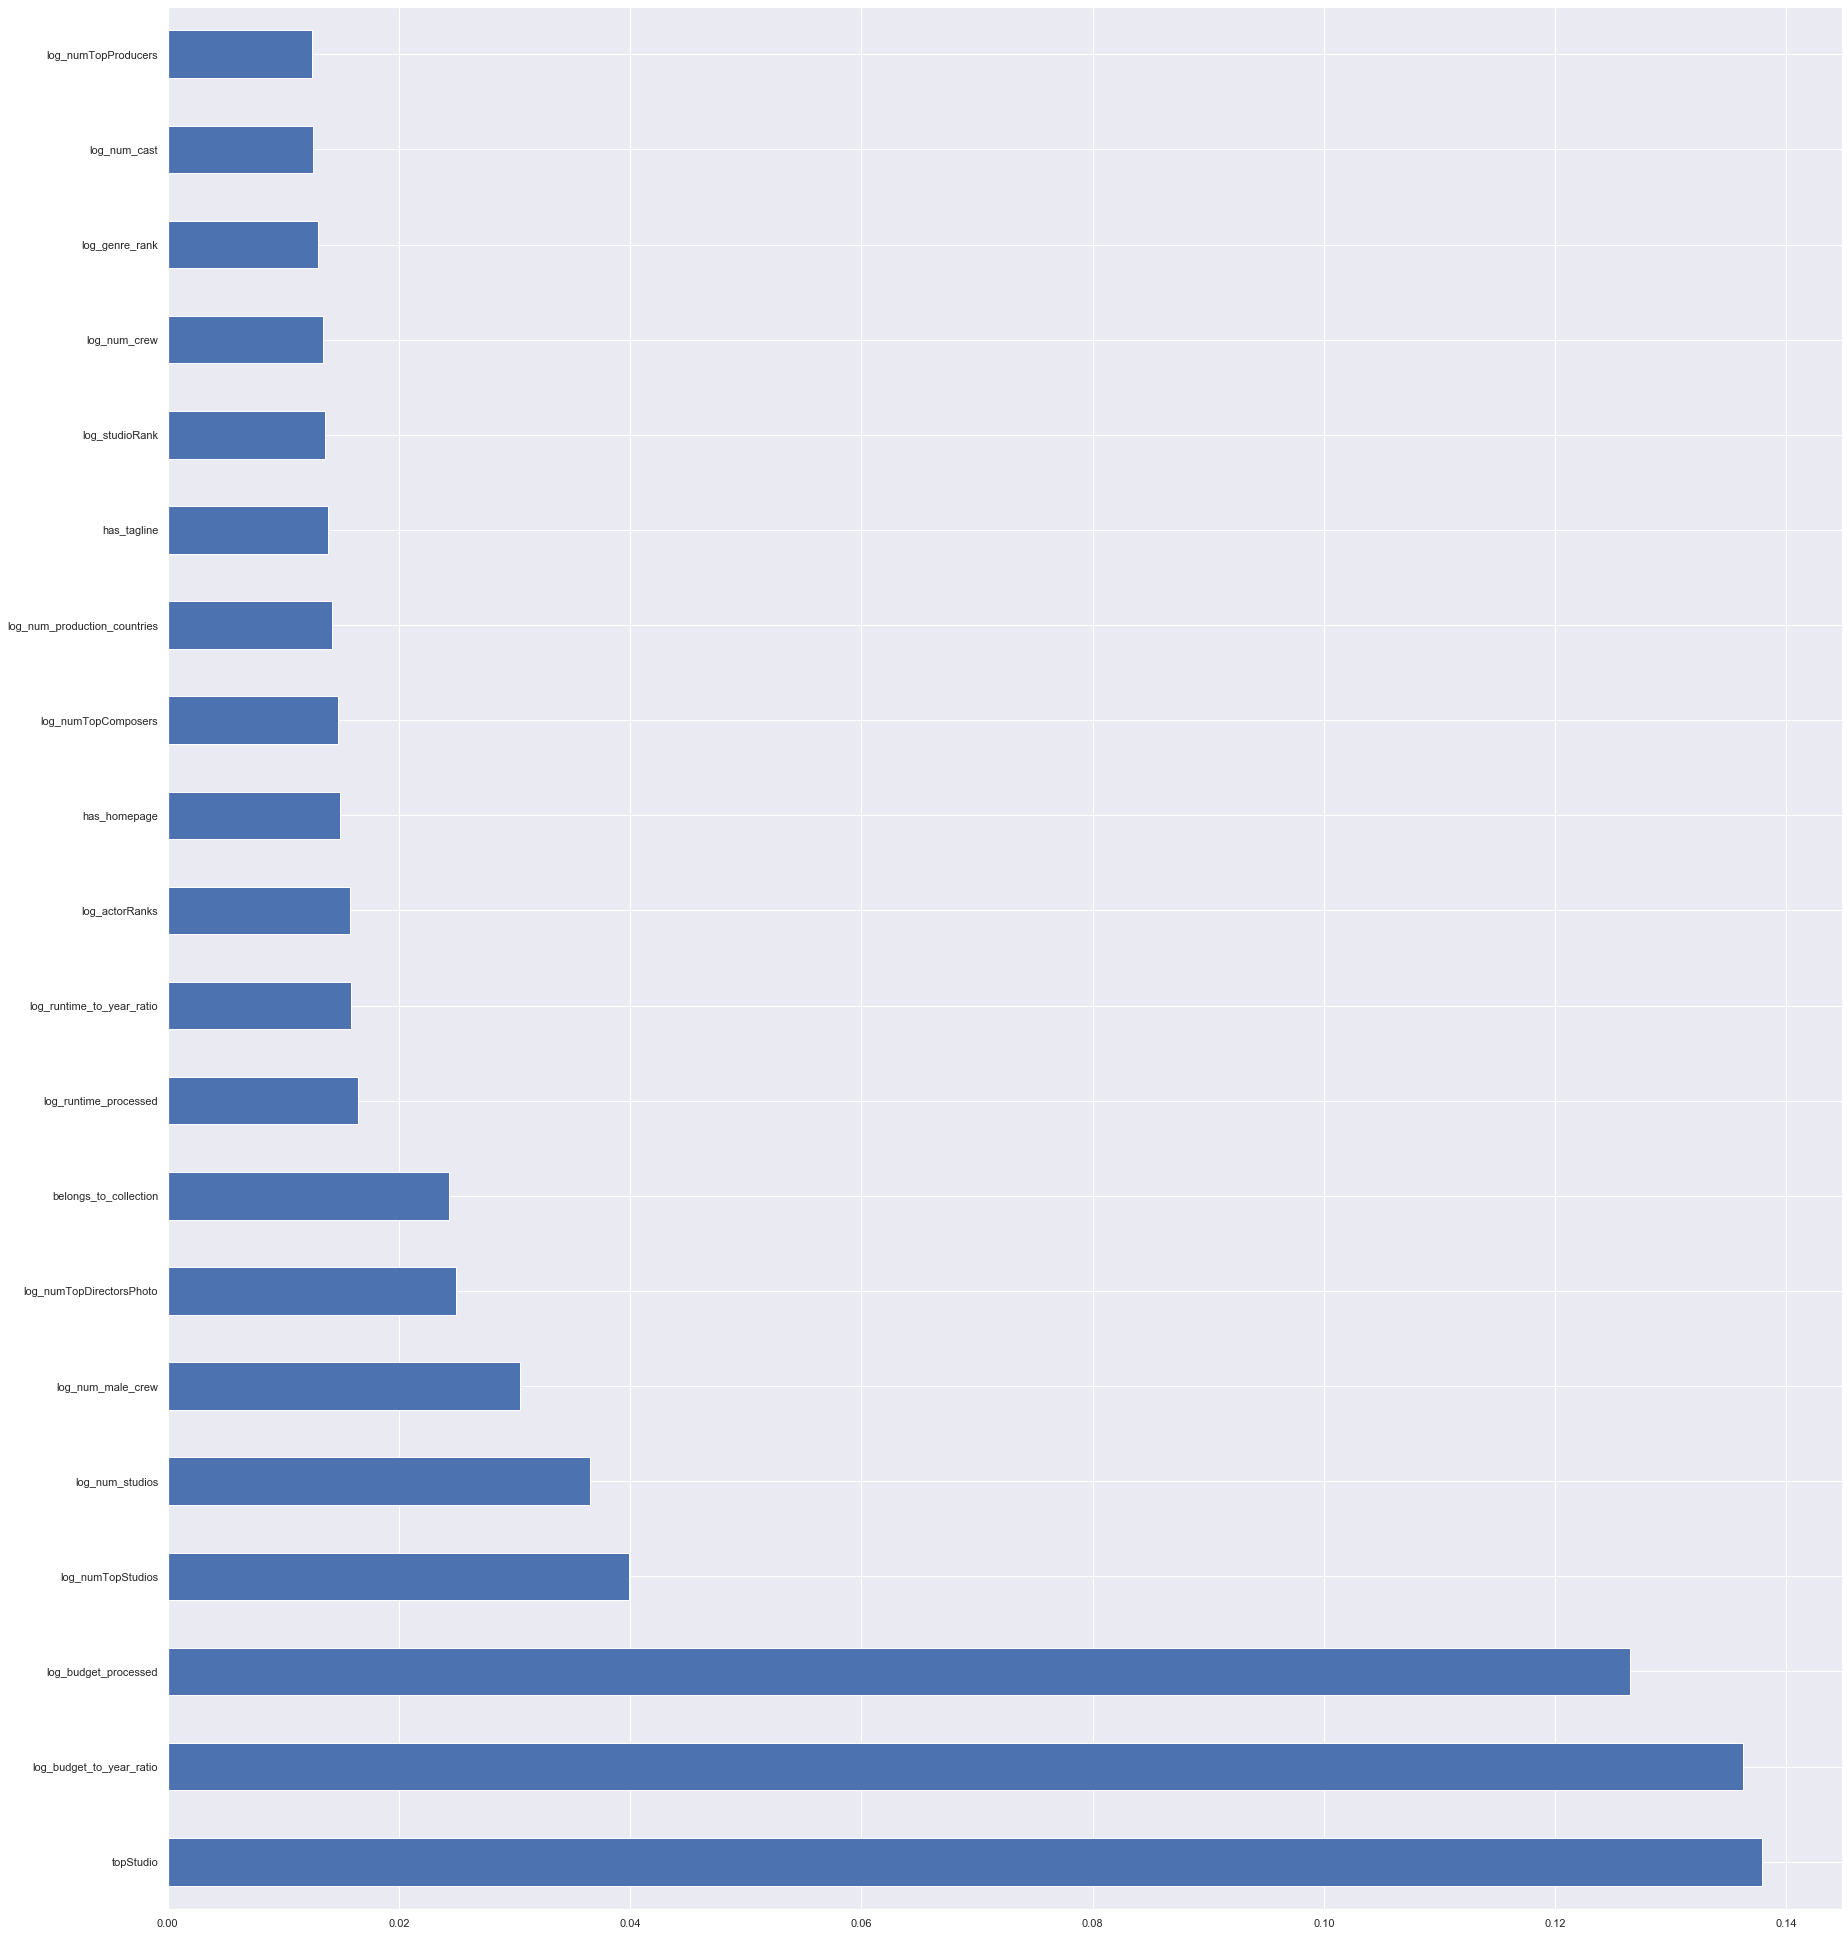

In [258]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


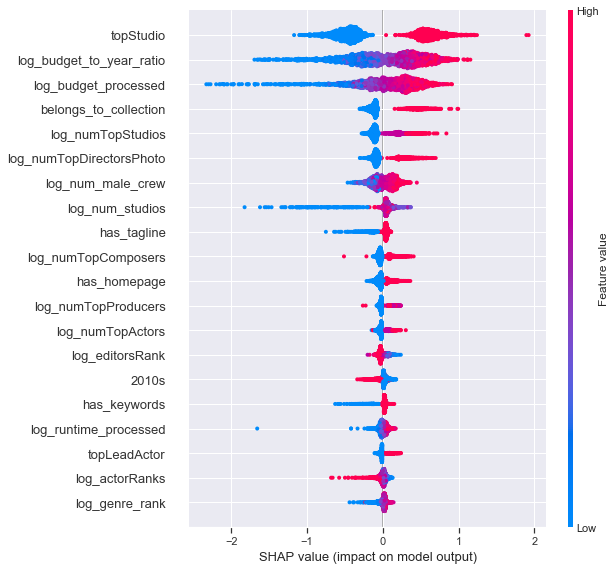

In [259]:

explainer = shap.TreeExplainer(et_best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

### XGBoost

#### Baseline

In [299]:
xgb_base_model = xgb.XGBRegressor(random_state = 42)
xgb_base_model.fit(X_train, y_train.values.ravel())

TypeError: fit() missing 1 required positional argument: 'y'

In [262]:
y_pred = xgb_base_model.predict(dtest)

In [263]:
print('XGBoost Baseline Model Metrics:')
metrics(y_pred, y_test.values)

XGBoost Baseline Model Metrics:
Mean Squared Error:  2.7543
Root Mean Squared Error:  1.6596
Mean Absolute Error:  1.1935
Test Set Accuracy (from Mean Absolute Percentage Error): 91.0 %


#### Grid Search Hyperparameter Tuning

In [ ]:
xgb_model = xgb.XGBRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 300],
    'colsample_bytree': [0.9, 1.0, 1.1],
    'max_depth': [2, 5, 10],
    'reg_alpha': [1.0, 1.2, 1.3],
    'reg_lambda': [ 1.2, 1.3, 1.4],
    'subsample': [0.9, 1.0]
}

xgb_model, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, xgb_model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-xgb_model.best_score_))
print(xgb_model.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.0min


In [ ]:
print('Base Model:')
base_accuracy = evaluate(xgb_base_model, X_test, y_test.values)
print()
print('Model after Tuning:')
xgb_best_model = xgb_model.best_estimator_
best_accuracy = evaluate(xgb_best_model, X_test, y_test.values)


print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))


Base Model:
Average Error: 1.1935
Accuracy = 91.00%

Model after Tuning:
Average Error: 1.1433
Accuracy = 91.40%
Improvement of 0.44%.

In [266]:
y_pred = xgb_best_model.predict(X_test)
print('XGBoost Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

XGBoost Model (After Tuning) Metrics:
Mean Squared Error:  2.5564
Root Mean Squared Error:  1.5989
Mean Absolute Error:  1.1433
Test Set Accuracy (from Mean Absolute Percentage Error): 91.4 %


#### Feature Importances

In [267]:
feature_importances = xgb_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_budget_to_year_ratio (0.141803)
2. log_numTopStudios (0.079844)
3. belongs_to_collection (0.054590)
4. topStudio (0.054422)
5. log_num_male_crew (0.049466)
6. log_budget_processed (0.036334)
7. log_num_studios (0.034188)
8. 1970s (0.027710)
9. mondayRelease (0.025827)
10. log_numTopProducers (0.025775)
11. log_numTopComposers (0.024549)
12. log_num_production_countries (0.023056)
13. log_runtime_to_year_ratio (0.016283)
14. log_topActorRank (0.016209)
15. has_tagline (0.016105)
16. topLeadProducer (0.015675)
17. has_homepage (0.015671)
18. Spring (0.015567)
19. log_composersRank (0.014510)
20. has_keywords (0.014243)
21. log_numTopActors (0.013840)
22. log_numTopExecProd (0.012328)
23. 2010s (0.011691)
24. log_directorsPhotoRank (0.010963)
25. log_genre_rank (0.010945)
26. log_actorRanks (0.010309)
27. released_in_english (0.010280)
28. log_runtime_processed (0.010270)
29. log_num_languages (0.009997)
30. log_num_cast (0.009790)
31. Fall (0.009143)
32. log_studi

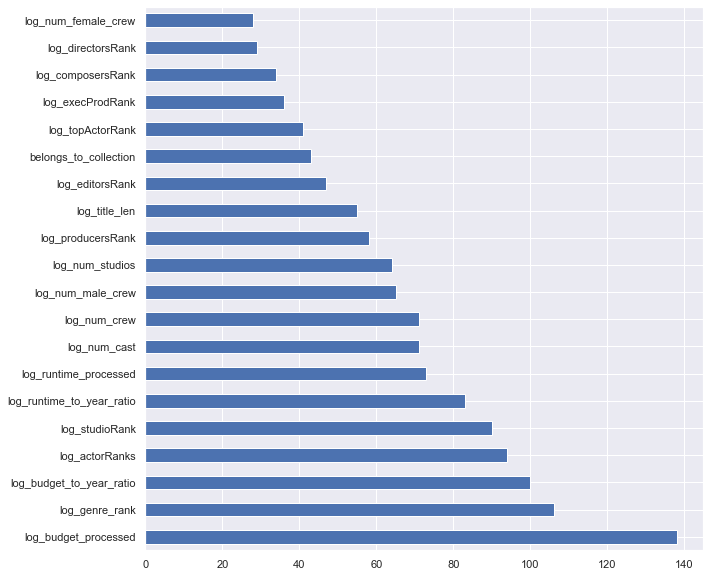

In [302]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

In [308]:
mybooster = xgb_best_model.get_booster()
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray

mybooster.save_raw = myfun

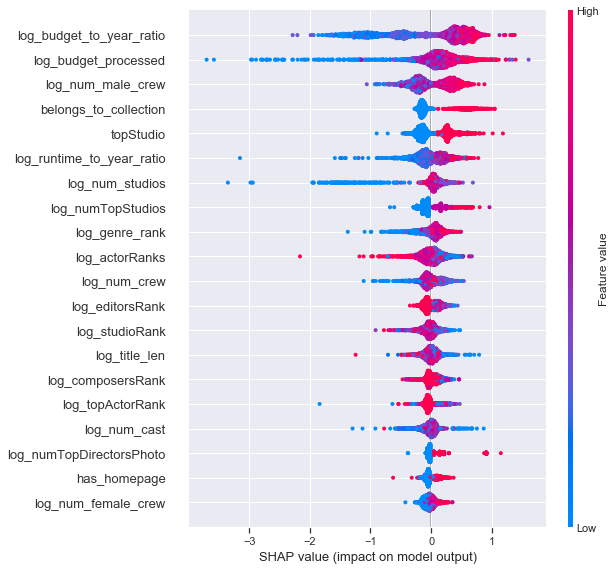

In [309]:
explainer = shap.TreeExplainer(xgb_best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [298]:
shap_values=predict(xgb_best_model, input_data, predcontrib = TRUE, approxcontrib = F)

### LightGBM

#### Baseline

In [272]:
# fit the model on the whole dataset
lgbm_base_model = LGBMRegressor(random_state=42)
lgbm_base_model.fit(X_train, y_train.values.ravel())

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [273]:
y_pred = lgbm_base_model.predict(X_test)

In [274]:
print('LightGBM Baseline Model Metrics:')
metrics(y_pred, y_test.values)

LightGBM Baseline Model Metrics:
Mean Squared Error:  2.3769
Root Mean Squared Error:  1.5417
Mean Absolute Error:  1.0836
Test Set Accuracy (from Mean Absolute Percentage Error): 91.72 %


#### Grid Search Hyperparameter Tuning

In [275]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [100, 150],
    'colsample_bytree': [0.8, 1.0, 1.2],
    'max_depth': [-1, 5, 10],
    'reg_alpha': [0.4, 0.5, 0.6],
    'reg_lambda': [0.2, 0.3, 0.4,],
    'subsample': [0.8, 0.9, 1],
    'num_leaves': [30,31,32]
}
# Create a based model
lgbm = LGBMRegressor(random_state=42)
lgbm, pred = algorithm_pipeline(X_train, X_test, y_train.values.ravel(), y_test.values, lgbm, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-lgbm.best_score_))
print(lgbm.best_params_)

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   57.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 6837 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 7930 tasks      | elapsed: 28.8min
[Parallel(n_jobs=-1)]: Done 9105 tasks      | 

1.278104180007343
{'colsample_bytree': 1.0, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 30, 'reg_alpha': 0.5, 'reg_lambda': 0.3, 'subsample': 0.8}


In [276]:
lgbm_base_model = LGBMRegressor()
lgbm_base_model.fit(X_train, y_train.values.ravel())
base_accuracy = evaluate(lgbm_base_model, X_test, y_test.values)

lgbm_best_model = lgbm.best_estimator_
best_accuracy = evaluate(lgbm_best_model, X_test, y_test.values)


print('Improvement of {:0.2f}%.'.format( 100 * (best_accuracy - base_accuracy) / base_accuracy))

Average Error: 1.0836
Accuracy = 91.72%
Average Error: 1.0602
Accuracy = 91.79%
Improvement of 0.08%.


In [277]:
y_pred = lgbm_best_model.predict(X_test)
print('LightGBM Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

LightGBM Model (After Tuning) Metrics:
Mean Squared Error:  2.3365
Root Mean Squared Error:  1.5286
Mean Absolute Error:  1.0602
Test Set Accuracy (from Mean Absolute Percentage Error): 91.79 %


#### Feature Importances

In [278]:
feature_importances = lgbm_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_budget_processed (138.000000)
2. log_genre_rank (106.000000)
3. log_budget_to_year_ratio (100.000000)
4. log_actorRanks (94.000000)
5. log_studioRank (90.000000)
6. log_runtime_to_year_ratio (83.000000)
7. log_runtime_processed (73.000000)
8. log_num_cast (71.000000)
9. log_num_crew (71.000000)
10. log_num_male_crew (65.000000)
11. log_num_studios (64.000000)
12. log_producersRank (58.000000)
13. log_title_len (55.000000)
14. log_editorsRank (47.000000)
15. belongs_to_collection (43.000000)
16. log_topActorRank (41.000000)
17. log_execProdRank (36.000000)
18. log_composersRank (34.000000)
19. log_directorsRank (29.000000)
20. log_num_female_crew (28.000000)
21. log_directorsPhotoRank (27.000000)
22. log_numTopStudios (25.000000)
23. log_num_production_countries (25.000000)
24. has_homepage (22.000000)
25. topStudio (22.000000)
26. 1970s (22.000000)
27. log_num_genres (19.000000)
28. has_tagline (18.000000)
29. has_keywords (17.000000)
30. log_numTopActors (15.00

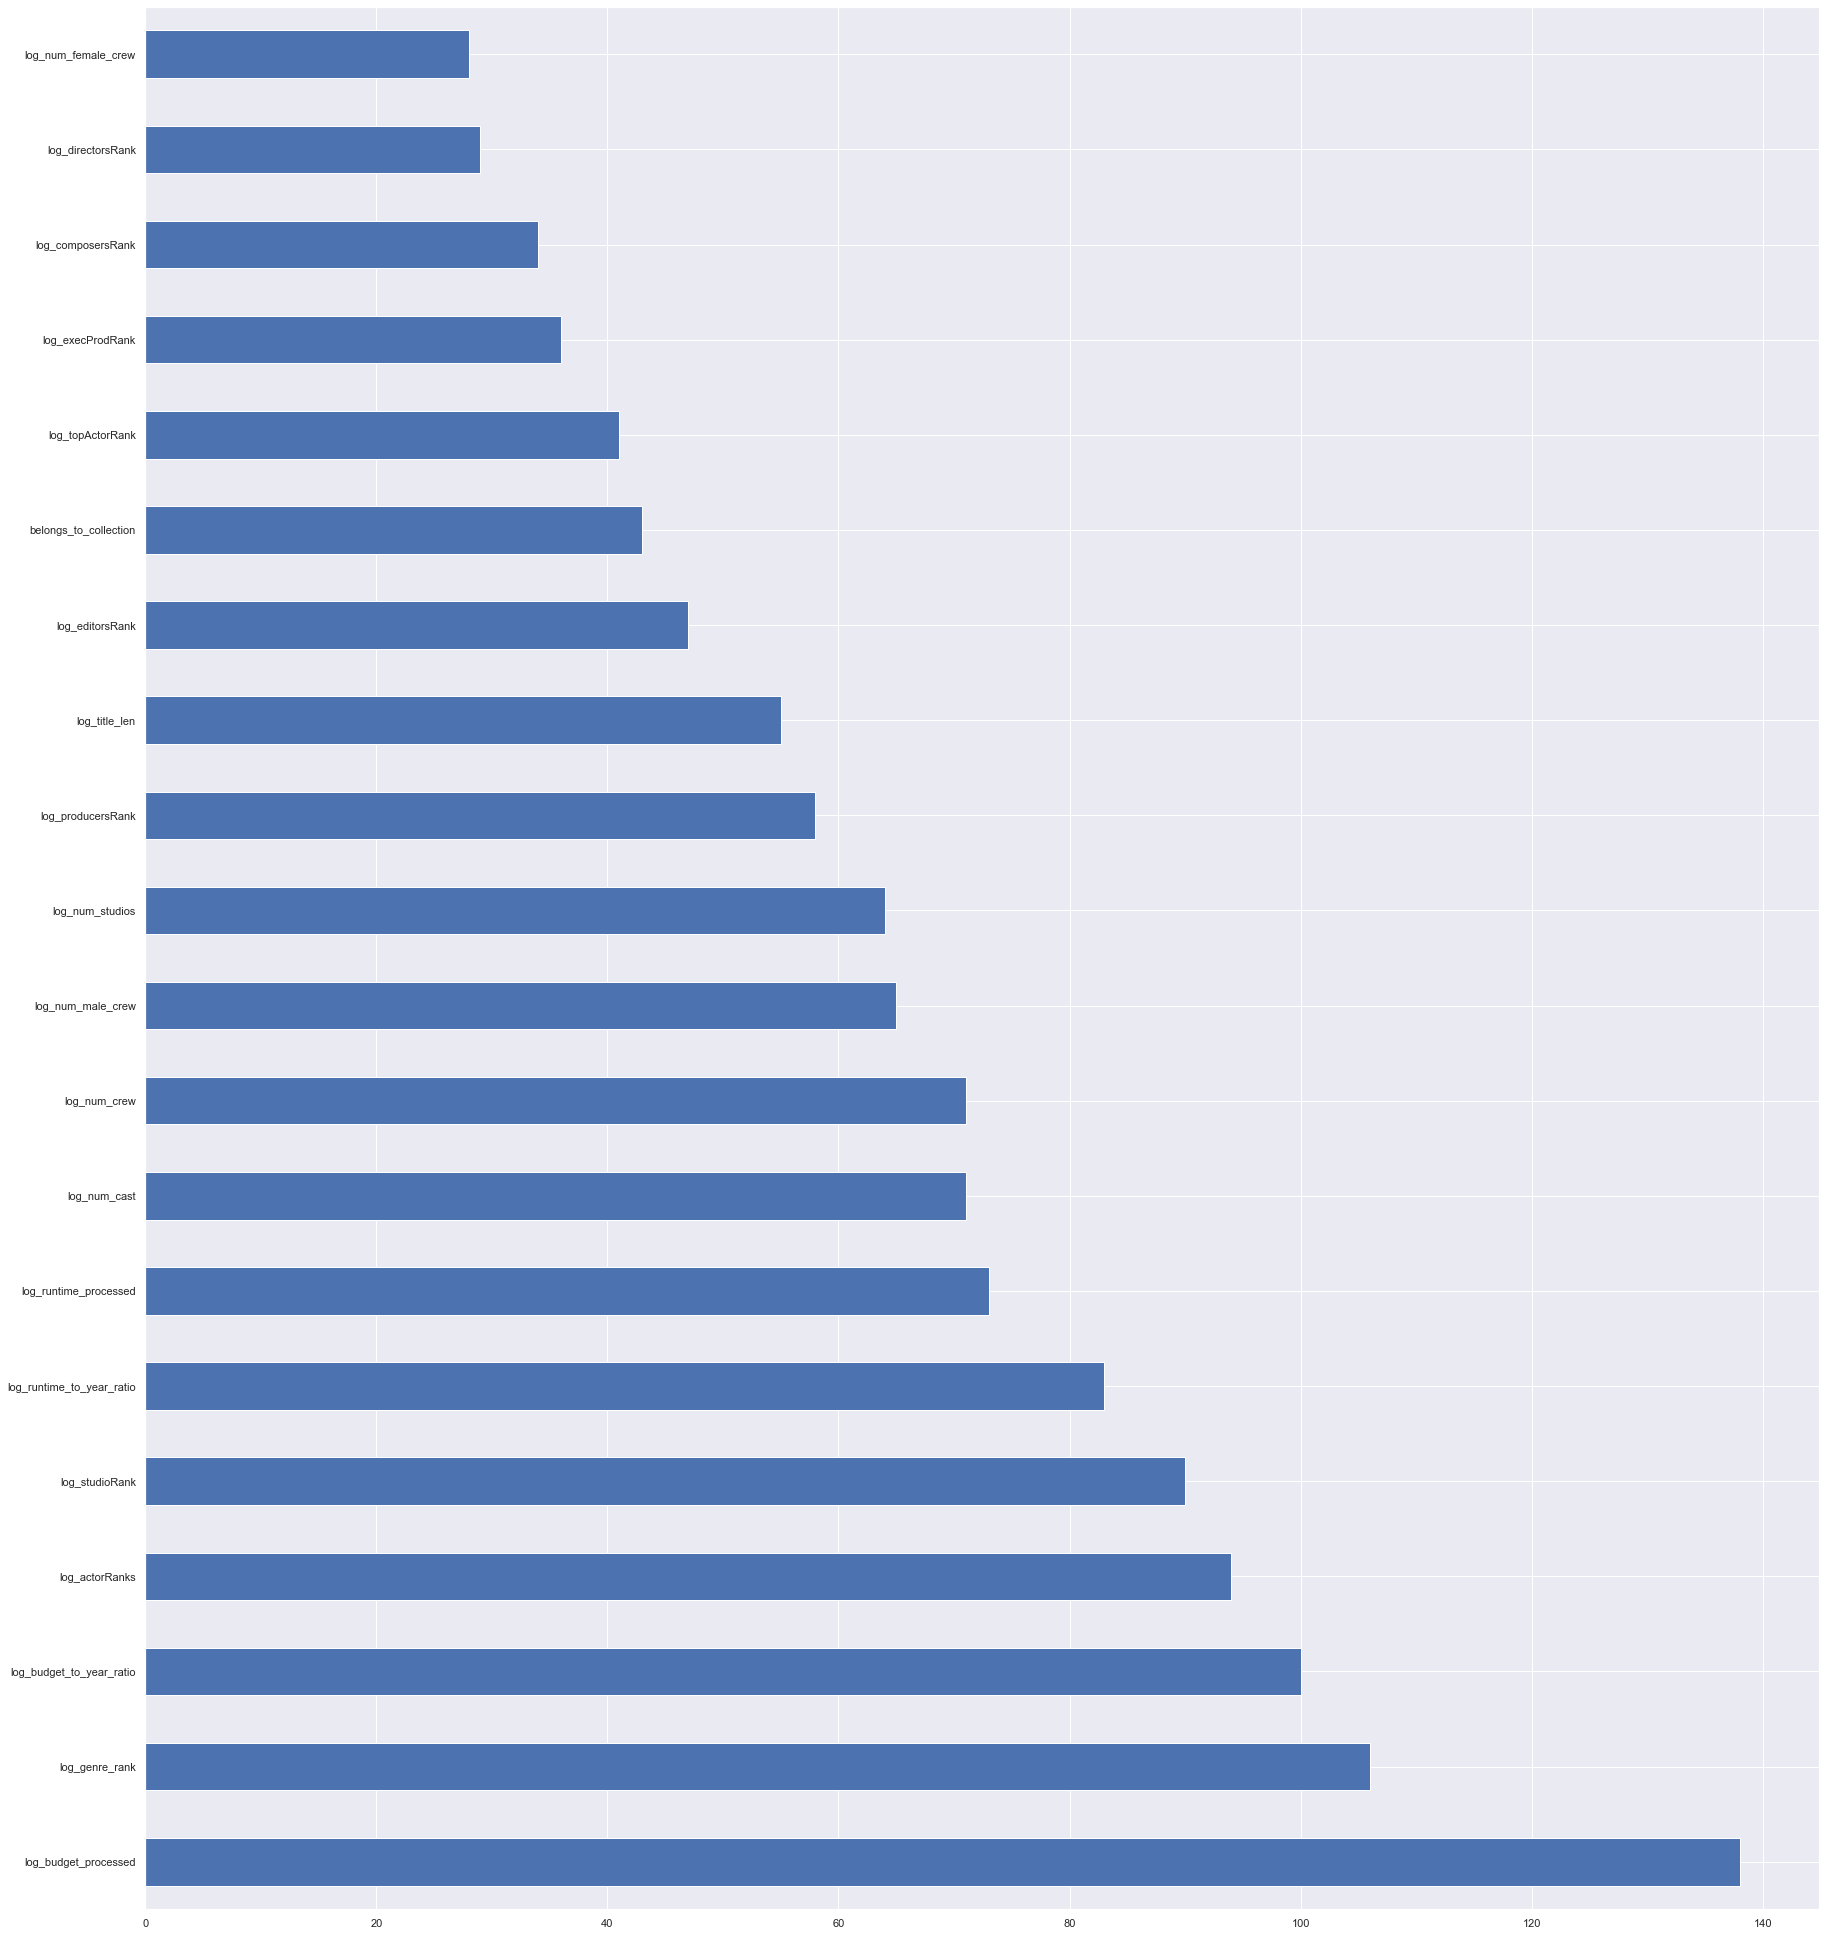

In [279]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

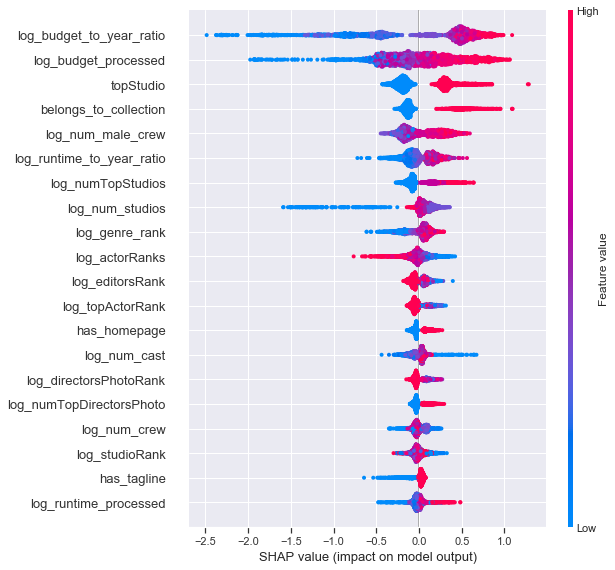

In [311]:
explainer = shap.TreeExplainer(lgbm_best_model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

## Conclusion

#### Key Findings

#### Limitations and Potential Improvements

In [281]:
# Text analysis, external data, neural networks for poster path etc, plugging missing values with regression

#### Final Words